In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asteroid-dataset/dataset.csv


# Introduction
This Jupyter Notebook is dedicated to exploring distribution of the properties and targets that make up the Asteroid Dataset. Univariate Analysis is first performed to identity the types of data that exist in this dataset and the shape of their distributions. Multivariate Analysis is then performed to capture the relationships between the features, targets, and the corelationships between feature and targets. These insights form the basis of the analysis done in the Classification, Regression and Neural Network Notebooks

# Rough Breakdown of the Column Definitions
SPK-ID: Object primary SPK-ID \
Object ID: Object internal database ID \
Object fullname: Object full name/designation \
pdes: Object primary designation \
name: Object IAU name \
NEO: Near-Earth Object (NEO) flag \
PHA: Potentially Hazardous Asteroid (PHA) flag \
H: Absolute magnitude parameter \
Diameter: object diameter (from equivalent sphere) km Unit \
Albedo: Geometric albedo \
Diameter_sigma: 1-sigma uncertainty in object diameter km Unit \
Orbit_id: Orbit solution ID \
Epoch: Epoch of osculation in modified Julian day form \
Equinox: Equinox of reference frame \
e: Eccentricity \
a: Semi-major axis au Unit \
q: perihelion distance au Unit \
i: inclination; angle with respect to x-y ecliptic plane \
tp: Time of perihelion passage TDB Unit \
moid_ld: Earth Minimum Orbit Intersection Distance au Unit \

In [2]:
# Install LazyPredictions to speed up model selection
!pip install lazypredict

In [3]:
# Install Relevant Libraries

# Linear Algebra and Scientific Computation
import numpy
import math
import scipy

# Machine Learning:
import sklearn as sk
import pandas as pd

# Feature Engineeering:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import f_classif

#Scanner 
import lazypredict

# Visualisation Modules:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
rcParams["figure.figsize"] = (20,20)

# Deep learning
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.distributions as td

#Metrics for both Regression and Classification
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Machine Learning Explainability
import shap



In [4]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y, categoric_values):
    mi_scores = mutual_info_regression(X,y, discrete_features = categoric_values)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores,cmap = "autumn"):
    scores = scores.sort_values(ascending = False)
    graphic =  sns.heatmap(data = pd.DataFrame(scores.values.reshape(-1,1), index = mutual_information_reg.index),  annot = True, cbar = True, cmap = cmap)
    plt.title("Mutual Informarion Scores")
    plt.show()

In [5]:
# Read the Asteroid Dataset
Dataset = pd.read_csv("/kaggle/input/asteroid-dataset/dataset.csv")
Dataset.info()

Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17  e         

In [6]:
# Split into the Train and Test Set:
Train_Dataset, Test_Dataset = train_test_split(Dataset, test_size = 0.20, random_state = 42)
Train_Dataset.shape, Test_Dataset.shape

((766819, 45), (191705, 45))

In [7]:
# Overview the first few columns
Train_Dataset.head(10)

id    spkid            full_name        pdes name prefix neo  \
307413  a0307414  2307414  307414 (2002 TY191)      307414  NaN    NaN   N   
376242  a0376243  2376243   376243 (2011 EA69)      376243  NaN    NaN   N   
850738  bK15RP5W  3795825         (2015 RW255)  2015 RW255  NaN    NaN   N   
355661  a0355662  2355662  355662 (2008 EC114)      355662  NaN    NaN   N   
632100  bK08CN5A  3997587         (2008 CA235)  2008 CA235  NaN    NaN   N   
941351  bK18U10Q  3836561          (2018 UQ10)   2018 UQ10  NaN    NaN   N   
27902   a0027903  2027903    27903 (1996 RS11)       27903  NaN    NaN   N   
419908  a0419909  2419909    419909 (2011 BC6)      419909  NaN    NaN   N   
779641  bK14N49J  3899217          (2014 NJ49)   2014 NJ49  NaN    NaN   N   
512903  a0512904  2512904   512904 (2016 WN49)      512904  NaN    NaN   N   

       pha       H  diameter  ...   sigma_i  sigma_om   sigma_w  sigma_ma  \
307413   N  16.000     2.312  ...  0.000007  0.000019  0.000082  0.000116   
376242   N  16.200       NaN  ...  0.000006  0.000054  0.000062  0.000032   
850738   N  17.400       NaN  ...  0.000009  0.000109  0.000114  0.000048   
355661   N  16.100       NaN  ...  0.000009  0.000084  0.000088  0.000022   
632100   N  17.161       NaN  ...  0.000015  0.000097  0.000112  0.000055   
941351   N  16.300       NaN  ...  0.000012  0.000022  0.000042  0.000034   
27902    N  13.700     5.211  ...  0.000005  0.000028  0.000033  0.000018   
419908   N  17.700       NaN  ...  0.000006  0.000479  0.000481  0.000041   
779641   N  16.110       NaN  ...  0.000011  0.000034  0.000069  0.000070   
512903   N  16.000       NaN  ...  0.000011  0.000029  0.000072  0.000067   

            sigma_ad       sigma_n  sigma_tp  sigma_per  class      rms  
307413  1.994600e-08  2.717100e-09  0.000475   0.000016    MBA  0.59534  
376242  4.426100e-08  4.602600e-09  0.000149   0.000037    MBA  0.59109  
850738  8.299100e-08  1.080200e-08  0.000171   0.000064    MBA  0.53880  
355661  5.911200e-08  3.887900e-09  0.000123   0.000046    MBA  0.48429  
632100  1.141400e-07  8.387500e-09  0.000311   0.000097    MBA  0.63627  
941351  6.071100e-08  4.848800e-09  0.000182   0.000050    MBA  0.60337  
27902   2.383400e-08  1.772600e-09  0.000105   0.000021    MBA  0.53167  
419908  2.832500e-08  3.193600e-09  0.000176   0.000022    MBA  0.62223  
779641  1.872300e-07  1.544400e-08  0.000410   0.000165    MBA  0.41381  
512903  8.692200e-08  7.430900e-09  0.000369   0.000077    MBA  0.50670  

[10 rows x 45 columns]

In [8]:
# Create an initial Dataset to explore

# Drop columns which cant be saved/not relevant
Train_Dataset.drop(columns = ["prefix", "name", "full_name", "pdes", "id", "equinox"], inplace = True)

# Drop nans from the target
Train_Dataset.dropna(subset = ["diameter"], inplace = True)

#Evaluate New Train_Dataset
Train_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108998 entries, 307413 to 121958
Data columns (total 39 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   spkid           108998 non-null  int64  
 1   neo             108998 non-null  object 
 2   pha             108998 non-null  object 
 3   H               105669 non-null  float64
 4   diameter        108998 non-null  float64
 5   albedo          108110 non-null  float64
 6   diameter_sigma  108903 non-null  float64
 7   orbit_id        108998 non-null  object 
 8   epoch           108998 non-null  float64
 9   epoch_mjd       108998 non-null  int64  
 10  epoch_cal       108998 non-null  float64
 11  e               108998 non-null  float64
 12  a               108998 non-null  float64
 13  q               108998 non-null  float64
 14  i               108998 non-null  float64
 15  om              108998 non-null  float64
 16  w               108998 non-null  float64
 17  ma        

In [9]:
# Overview the first few columns
Train_Dataset.head(10)

spkid neo pha     H  diameter  albedo  diameter_sigma orbit_id  \
307413  2307414   N   N  16.0     2.312   0.158           0.590   JPL 18   
27902   2027903   N   N  13.7     5.211   0.284           0.479   JPL 31   
34613   2034614   N   N  13.8     5.731   0.214           0.700   JPL 31   
99892   2099893   N   N  14.7     5.556   0.091           0.099       18   
3671    2003672   N   N  13.2     5.616   0.268           0.137   JPL 30   
402014  2402015   N   N  16.3     3.862   0.047           0.147       12   
241103  2241104   N   N  16.2     3.602   0.054           0.378   JPL 16   
38461   2038462   N   N  14.5     8.862   0.030           0.528   JPL 22   
137310  2137311   N   N  13.8     3.858   0.338           0.622   JPL 22   
45375   2045376   N   N  15.1     4.759   0.103           0.456   JPL 20   

            epoch  epoch_mjd  ...   sigma_i  sigma_om   sigma_w  sigma_ma  \
307413  2459000.5      59000  ...  0.000007  0.000019  0.000082  0.000116   
27902   2459000.5      59000  ...  0.000005  0.000028  0.000033  0.000018   
34613   2459000.5      59000  ...  0.000004  0.000016  0.000019  0.000012   
99892   2459000.5      59000  ...  0.000006  0.000058  0.000141  0.000125   
3671    2459000.5      59000  ...  0.000005  0.000028  0.000033  0.000017   
402014  2459000.5      59000  ...  0.000010  0.000039  0.000049  0.000026   
241103  2459000.5      59000  ...  0.000004  0.000035  0.000045  0.000034   
38461   2459000.5      59000  ...  0.000005  0.001048  0.001048  0.000023   
137310  2459000.5      59000  ...  0.000009  0.000012  0.000016  0.000015   
45375   2459000.5      59000  ...  0.000006  0.000044  0.000047  0.000014   

            sigma_ad       sigma_n  sigma_tp  sigma_per  class      rms  
307413  1.994600e-08  2.717100e-09  0.000475   0.000016    MBA  0.59534  
27902   2.383400e-08  1.772600e-09  0.000105   0.000021    MBA  0.53167  
34613   1.565900e-08  1.678300e-09  0.000057   0.000012    MBA  0.48828  
99892   3.877700e-08  2.951700e-09  0.000738   0.000037    OMB  0.59388  
3671    7.024900e-09  1.293200e-09  0.000056   0.000005    MBA  0.46355  
402014  5.307000e-08  3.507700e-09  0.000156   0.000043    OMB  0.62787  
241103  2.355900e-08  2.984900e-09  0.000140   0.000018    MBA  0.58399  
38461   2.420700e-08  1.758400e-09  0.000132   0.000021    MBA  0.56025  
137310  1.689000e-08  2.400800e-09  0.000056   0.000011    MBA  0.52926  
45375   1.496400e-08  1.820900e-09  0.000061   0.000011    MBA  0.52849  

[10 rows x 39 columns]

In [10]:
# Review the categorical columns, recogonize unbalanced classes!
print(Train_Dataset.neo.value_counts(normalize = True))
print(Train_Dataset.pha.value_counts(normalize = True))
print(Train_Dataset.orbit_id.value_counts(normalize = True))
print(Train_Dataset["class"].value_counts())

neo
N    0.993807
Y    0.006193
Name: proportion, dtype: float64
pha
N    0.998413
Y    0.001587
Name: proportion, dtype: float64
orbit_id
JPL 19     0.038037
JPL 20     0.038028
JPL 18     0.037909
JPL 17     0.037790
JPL 21     0.037404
             ...   
656        0.000009
132        0.000009
JPL 139    0.000009
235        0.000009
JPL 184    0.000009
Name: proportion, Length: 379, dtype: float64
class
MBA    100048
OMB      5980
TJN      1495
IMB       451
APO       390
MCA       291
AMO       211
ATE        74
CEN        39
TNO        12
AST         7
Name: count, dtype: int64


In [11]:
# Convert the classes Numerical Encodings using OneHotEncoding and LabelEncoding
NEO_OHE = OneHotEncoder().fit(Train_Dataset.neo.values.reshape(-1,1))
PHA_OHE = OneHotEncoder().fit(Train_Dataset.pha.values.reshape(-1,1))
Class_OHE = OneHotEncoder().fit(Train_Dataset["class"].values.reshape(-1,1))
Orbit_LE = LabelEncoder().fit(Train_Dataset.orbit_id.values.reshape(-1,1))

NEO = pd.DataFrame(NEO_OHE.transform(Train_Dataset.neo.values.reshape(-1,1)).toarray(), index = Train_Dataset.index, columns = ["neo_n", "neo"])
PHA = pd.DataFrame(PHA_OHE.transform(Train_Dataset.pha.values.reshape(-1,1)).toarray(), index = Train_Dataset.index, columns = ["pha_n", "pha"])
Class = pd.DataFrame(Class_OHE.transform(Train_Dataset["class"].values.reshape(-1,1)).toarray(), index = Train_Dataset.index, columns = ["AMO", "APO", "AST", "ATE", "CEN", "IMB", "MBA", "MCA", "OMB", "TJN", "TNO"])
orbit_id = pd.DataFrame(Orbit_LE.transform(Train_Dataset.orbit_id.values), index = Train_Dataset.index, columns = ["orbit_id"])

OneHotEmbeddings = pd.concat([NEO, PHA, Class], axis = 1)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [12]:
# Drop the now redundant classifications.
Train_Dataset.drop(columns = ["pha", "neo", "class", "orbit_id"], inplace = True)
Train_Dataset = pd.concat([Train_Dataset, OneHotEmbeddings, orbit_id], axis = 1)
Train_Dataset.drop(columns = ["neo_n", "pha_n"], inplace = True)
Train_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108998 entries, 307413 to 121958
Data columns (total 49 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   spkid           108998 non-null  int64  
 1   H               105669 non-null  float64
 2   diameter        108998 non-null  float64
 3   albedo          108110 non-null  float64
 4   diameter_sigma  108903 non-null  float64
 5   epoch           108998 non-null  float64
 6   epoch_mjd       108998 non-null  int64  
 7   epoch_cal       108998 non-null  float64
 8   e               108998 non-null  float64
 9   a               108998 non-null  float64
 10  q               108998 non-null  float64
 11  i               108998 non-null  float64
 12  om              108998 non-null  float64
 13  w               108998 non-null  float64
 14  ma              108998 non-null  float64
 15  ad              108998 non-null  float64
 16  n               108998 non-null  float64
 17  tp        

In [13]:
# Reduce the number of target columns for the class based on it's unbalanced nature
func = lambda x : 1.0 if not(x.MBA != 0.0 or x.OMB != 0.0) else 0.0
Train_Dataset["Other"] = Train_Dataset.apply(func, axis = 1)
Train_Dataset["Other"].value_counts()

# Display the new proportions
print(Train_Dataset[["MBA", "OMB", "Other"]].value_counts())

# Filter the Dataset
Train_Dataset.drop(columns = ["AMO", "APO", "AST", "ATE", "CEN", "IMB", "MCA", "TJN", "TNO"], inplace = True)
Train_Dataset.info()

MBA  OMB  Other
1.0  0.0  0.0      100048
0.0  1.0  0.0        5980
     0.0  1.0        2970
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 108998 entries, 307413 to 121958
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   spkid           108998 non-null  int64  
 1   H               105669 non-null  float64
 2   diameter        108998 non-null  float64
 3   albedo          108110 non-null  float64
 4   diameter_sigma  108903 non-null  float64
 5   epoch           108998 non-null  float64
 6   epoch_mjd       108998 non-null  int64  
 7   epoch_cal       108998 non-null  float64
 8   e               108998 non-null  float64
 9   a               108998 non-null  float64
 10  q               108998 non-null  float64
 11  i               108998 non-null  float64
 12  om              108998 non-null  float64
 13  w               108998 non-null  float64
 14  ma              108998 non-n

In [14]:
# Perform KNN Imputation on the data
Train_Dataset = pd.DataFrame(KNNImputer().fit_transform(Train_Dataset), columns = Train_Dataset.columns)

# Obtain Statistics about the Dataset:
Train_Dataset.describe()

spkid              H       diameter         albedo  \
count  1.089980e+05  108998.000000  108998.000000  108998.000000   
mean   2.255311e+06      15.182784       5.514344       0.130309   
std    5.610143e+05       1.407870       9.336154       0.110178   
min    2.000002e+06       3.000000       0.008000       0.001000   
25%    2.049300e+06      14.500000       2.776000       0.053000   
50%    2.129428e+06      15.300000       3.969000       0.079000   
75%    2.260742e+06      16.100000       5.759000       0.189000   
max    5.400002e+07      27.500000     900.000000       1.000000   

       diameter_sigma         epoch      epoch_mjd     epoch_cal  \
count   108998.000000  1.089980e+05  108998.000000  1.089980e+05   
mean         0.480454  2.458883e+06   58882.259574  2.019733e+07   
std          0.836203  6.476335e+02     647.633499  1.760983e+04   
min          0.001000  2.452464e+06   52464.000000  2.002071e+07   
25%          0.180000  2.459000e+06   59000.000000  2.020053e+07   
50%          0.332000  2.459000e+06   59000.000000  2.020053e+07   
75%          0.620000  2.459000e+06   59000.000000  2.020053e+07   
max        140.000000  2.459000e+06   59000.000000  2.020053e+07   

                   e              a  ...       sigma_n      sigma_tp  \
count  108998.000000  108998.000000  ...  1.089980e+05  1.089980e+05   
mean        0.145685       2.820842  ...  1.249874e-01  6.116106e+02   
std         0.077517       1.651872  ...  1.564999e+00  1.814603e+04   
min         0.000808       0.626210  ...  2.860900e-11  5.708000e-07   
25%         0.089860       2.542027  ...  1.734500e-09  7.346625e-05   
50%         0.138935       2.754471  ...  2.296950e-09  1.187500e-04   
75%         0.191242       3.094649  ...  3.423400e-09  2.225575e-04   
max         0.983789     376.133297  ...  1.312600e+02  3.984600e+06   

          sigma_per            rms            neo            pha  \
count  1.089980e+05  108998.000000  108998.000000  108998.000000   
mean   7.808303e+02       0.544051       0.006193       0.001587   
std    1.072177e+04       0.073859       0.078450       0.039808   
min    3.000700e-08       0.054414       0.000000       0.000000   
25%    1.182600e-05       0.508910       0.000000       0.000000   
50%    1.948800e-05       0.544190       0.000000       0.000000   
75%    3.323375e-05       0.579230       0.000000       0.000000   
max    1.034600e+06       7.725100       1.000000       1.000000   

                 MBA            OMB       orbit_id          Other  
count  108998.000000  108998.000000  108998.000000  108998.000000  
mean        0.917888       0.054863     189.006486       0.027248  
std         0.274536       0.227714      99.998259       0.162807  
min         0.000000       0.000000       0.000000       0.000000  
25%         1.000000       0.000000      70.000000       0.000000  
50%         1.000000       0.000000     226.000000       0.000000  
75%         1.000000       0.000000     260.000000       0.000000  
max         1.000000       1.000000     378.000000       1.000000  

[8 rows x 41 columns]

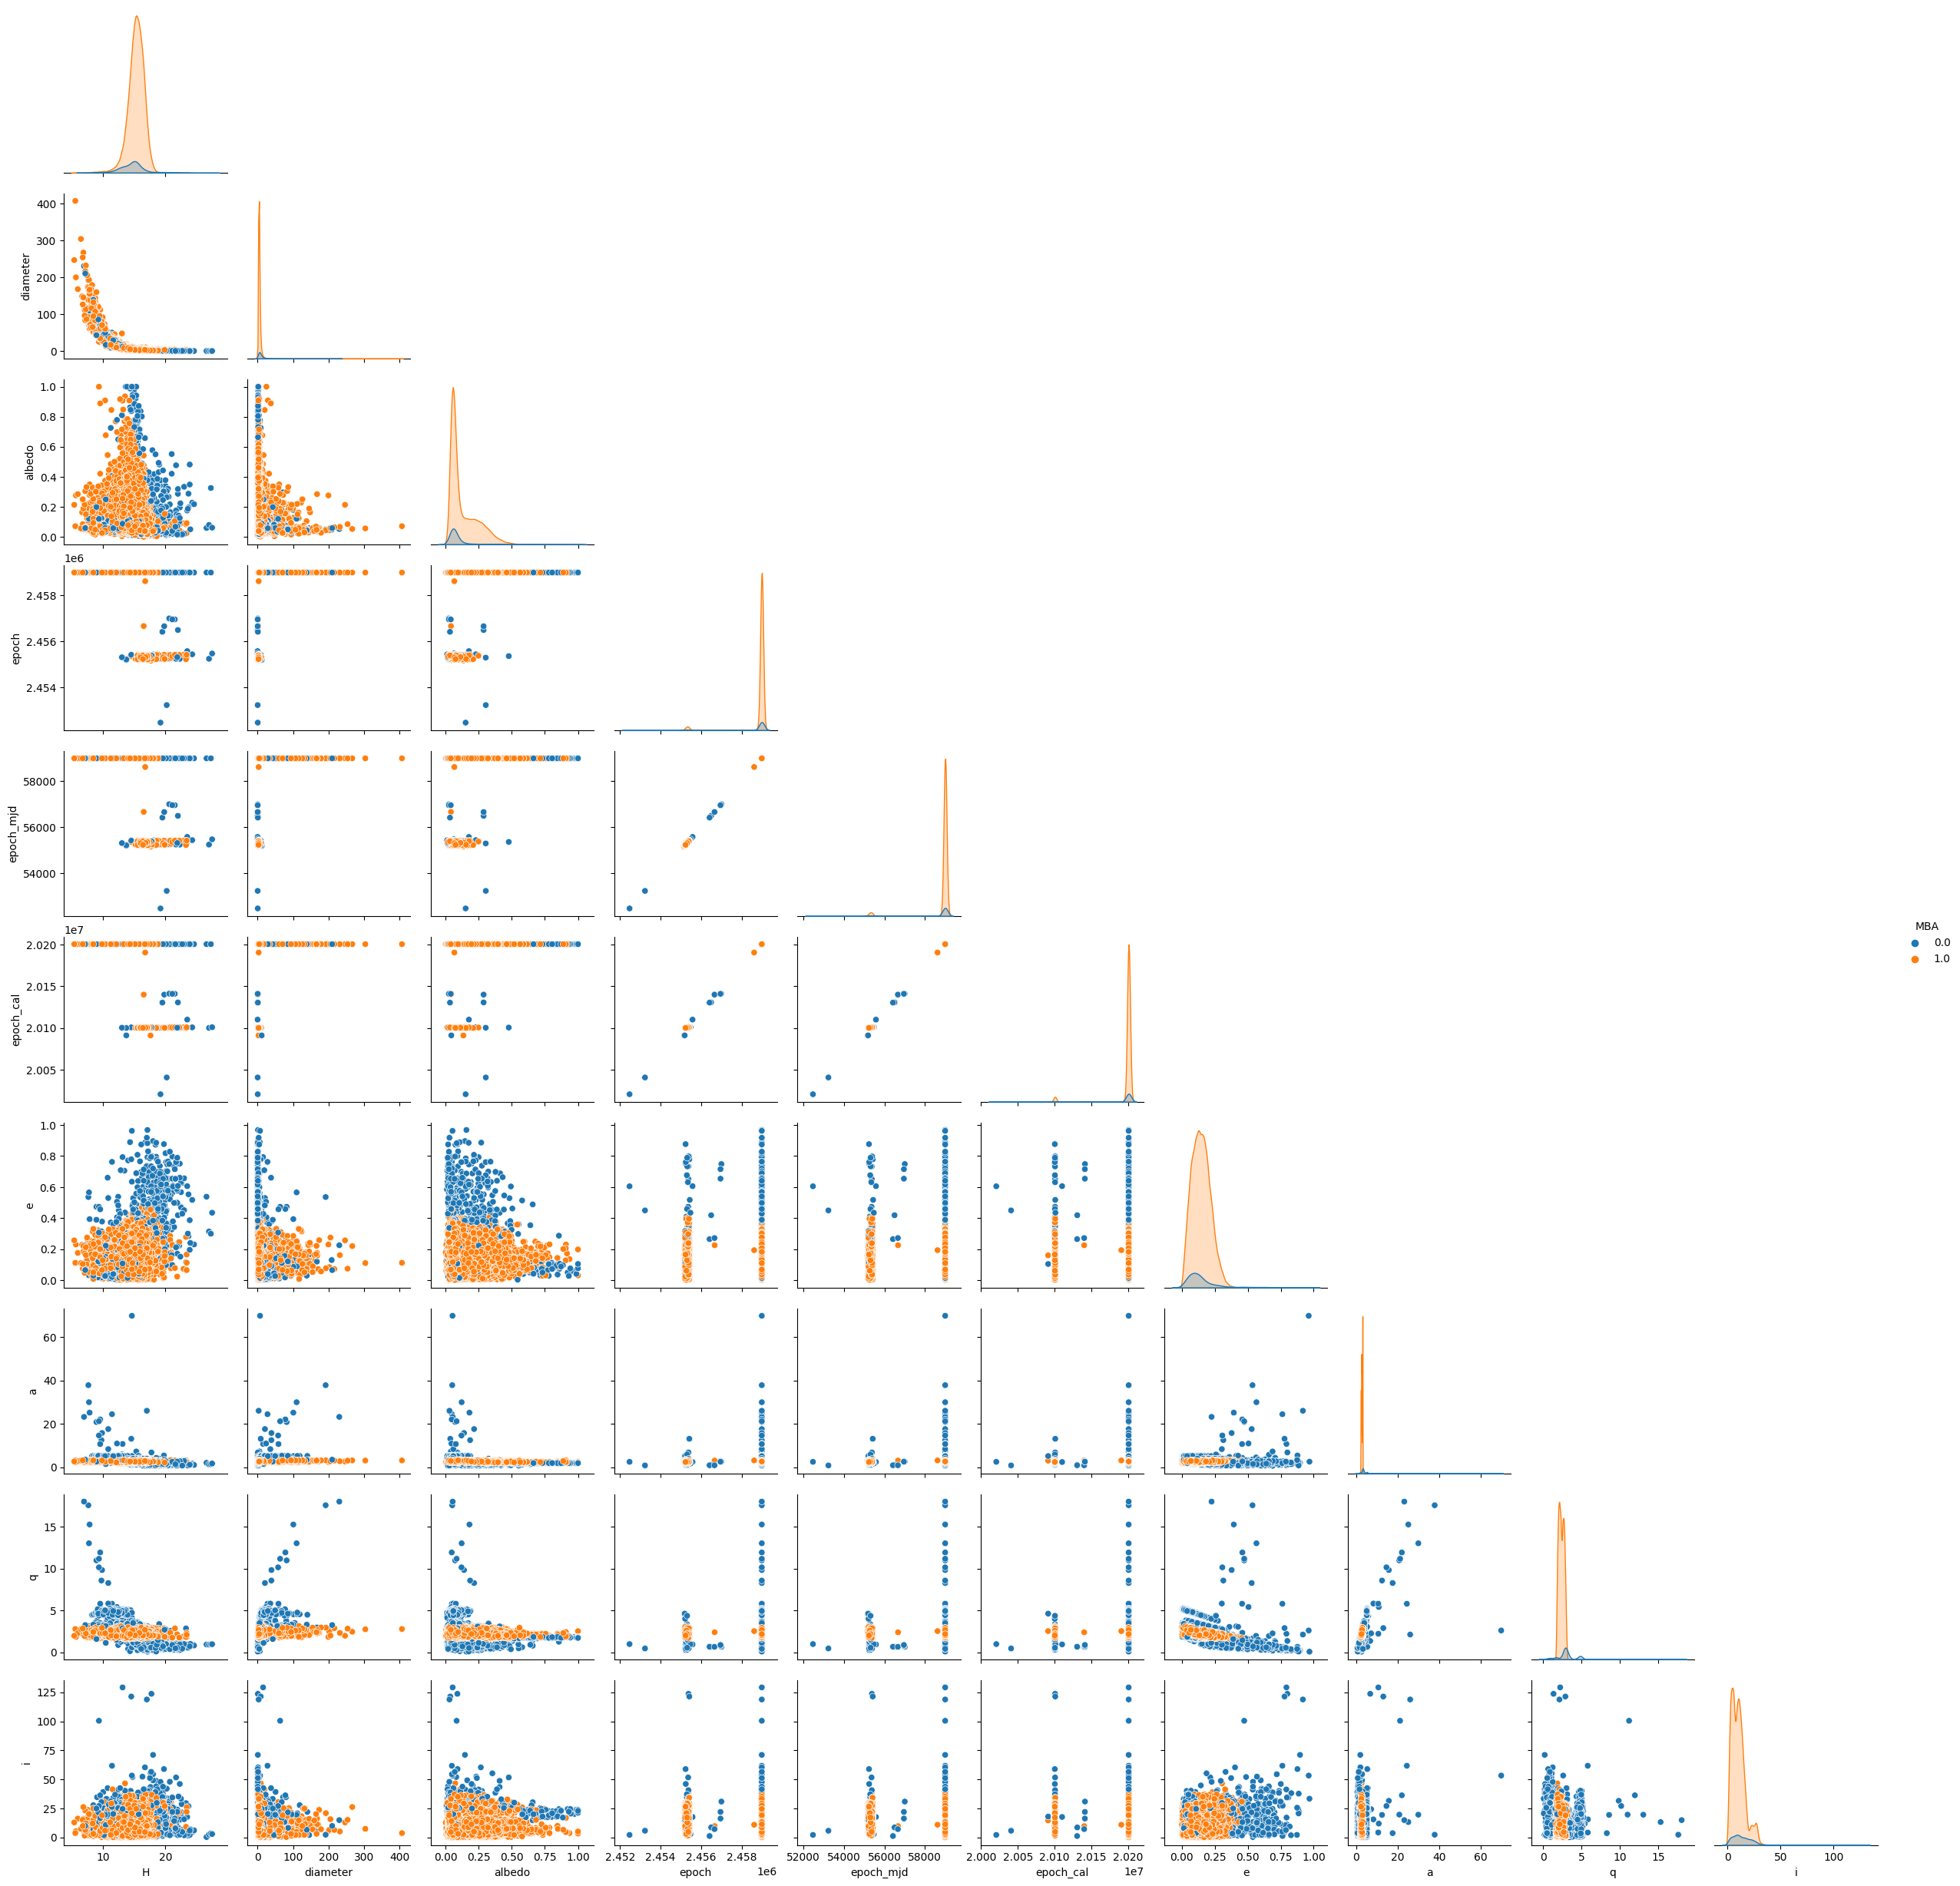

In [15]:
# Visualise the correlations between features and targets:

# Pairplot for Numerical Continuous Features
sns.pairplot(data = Train_Dataset.iloc[:50000][["H", "diameter", "albedo", "epoch", "epoch_mjd", "epoch_cal", "e", "a", "q", "i", "MBA"]], hue = "MBA", corner = True) 

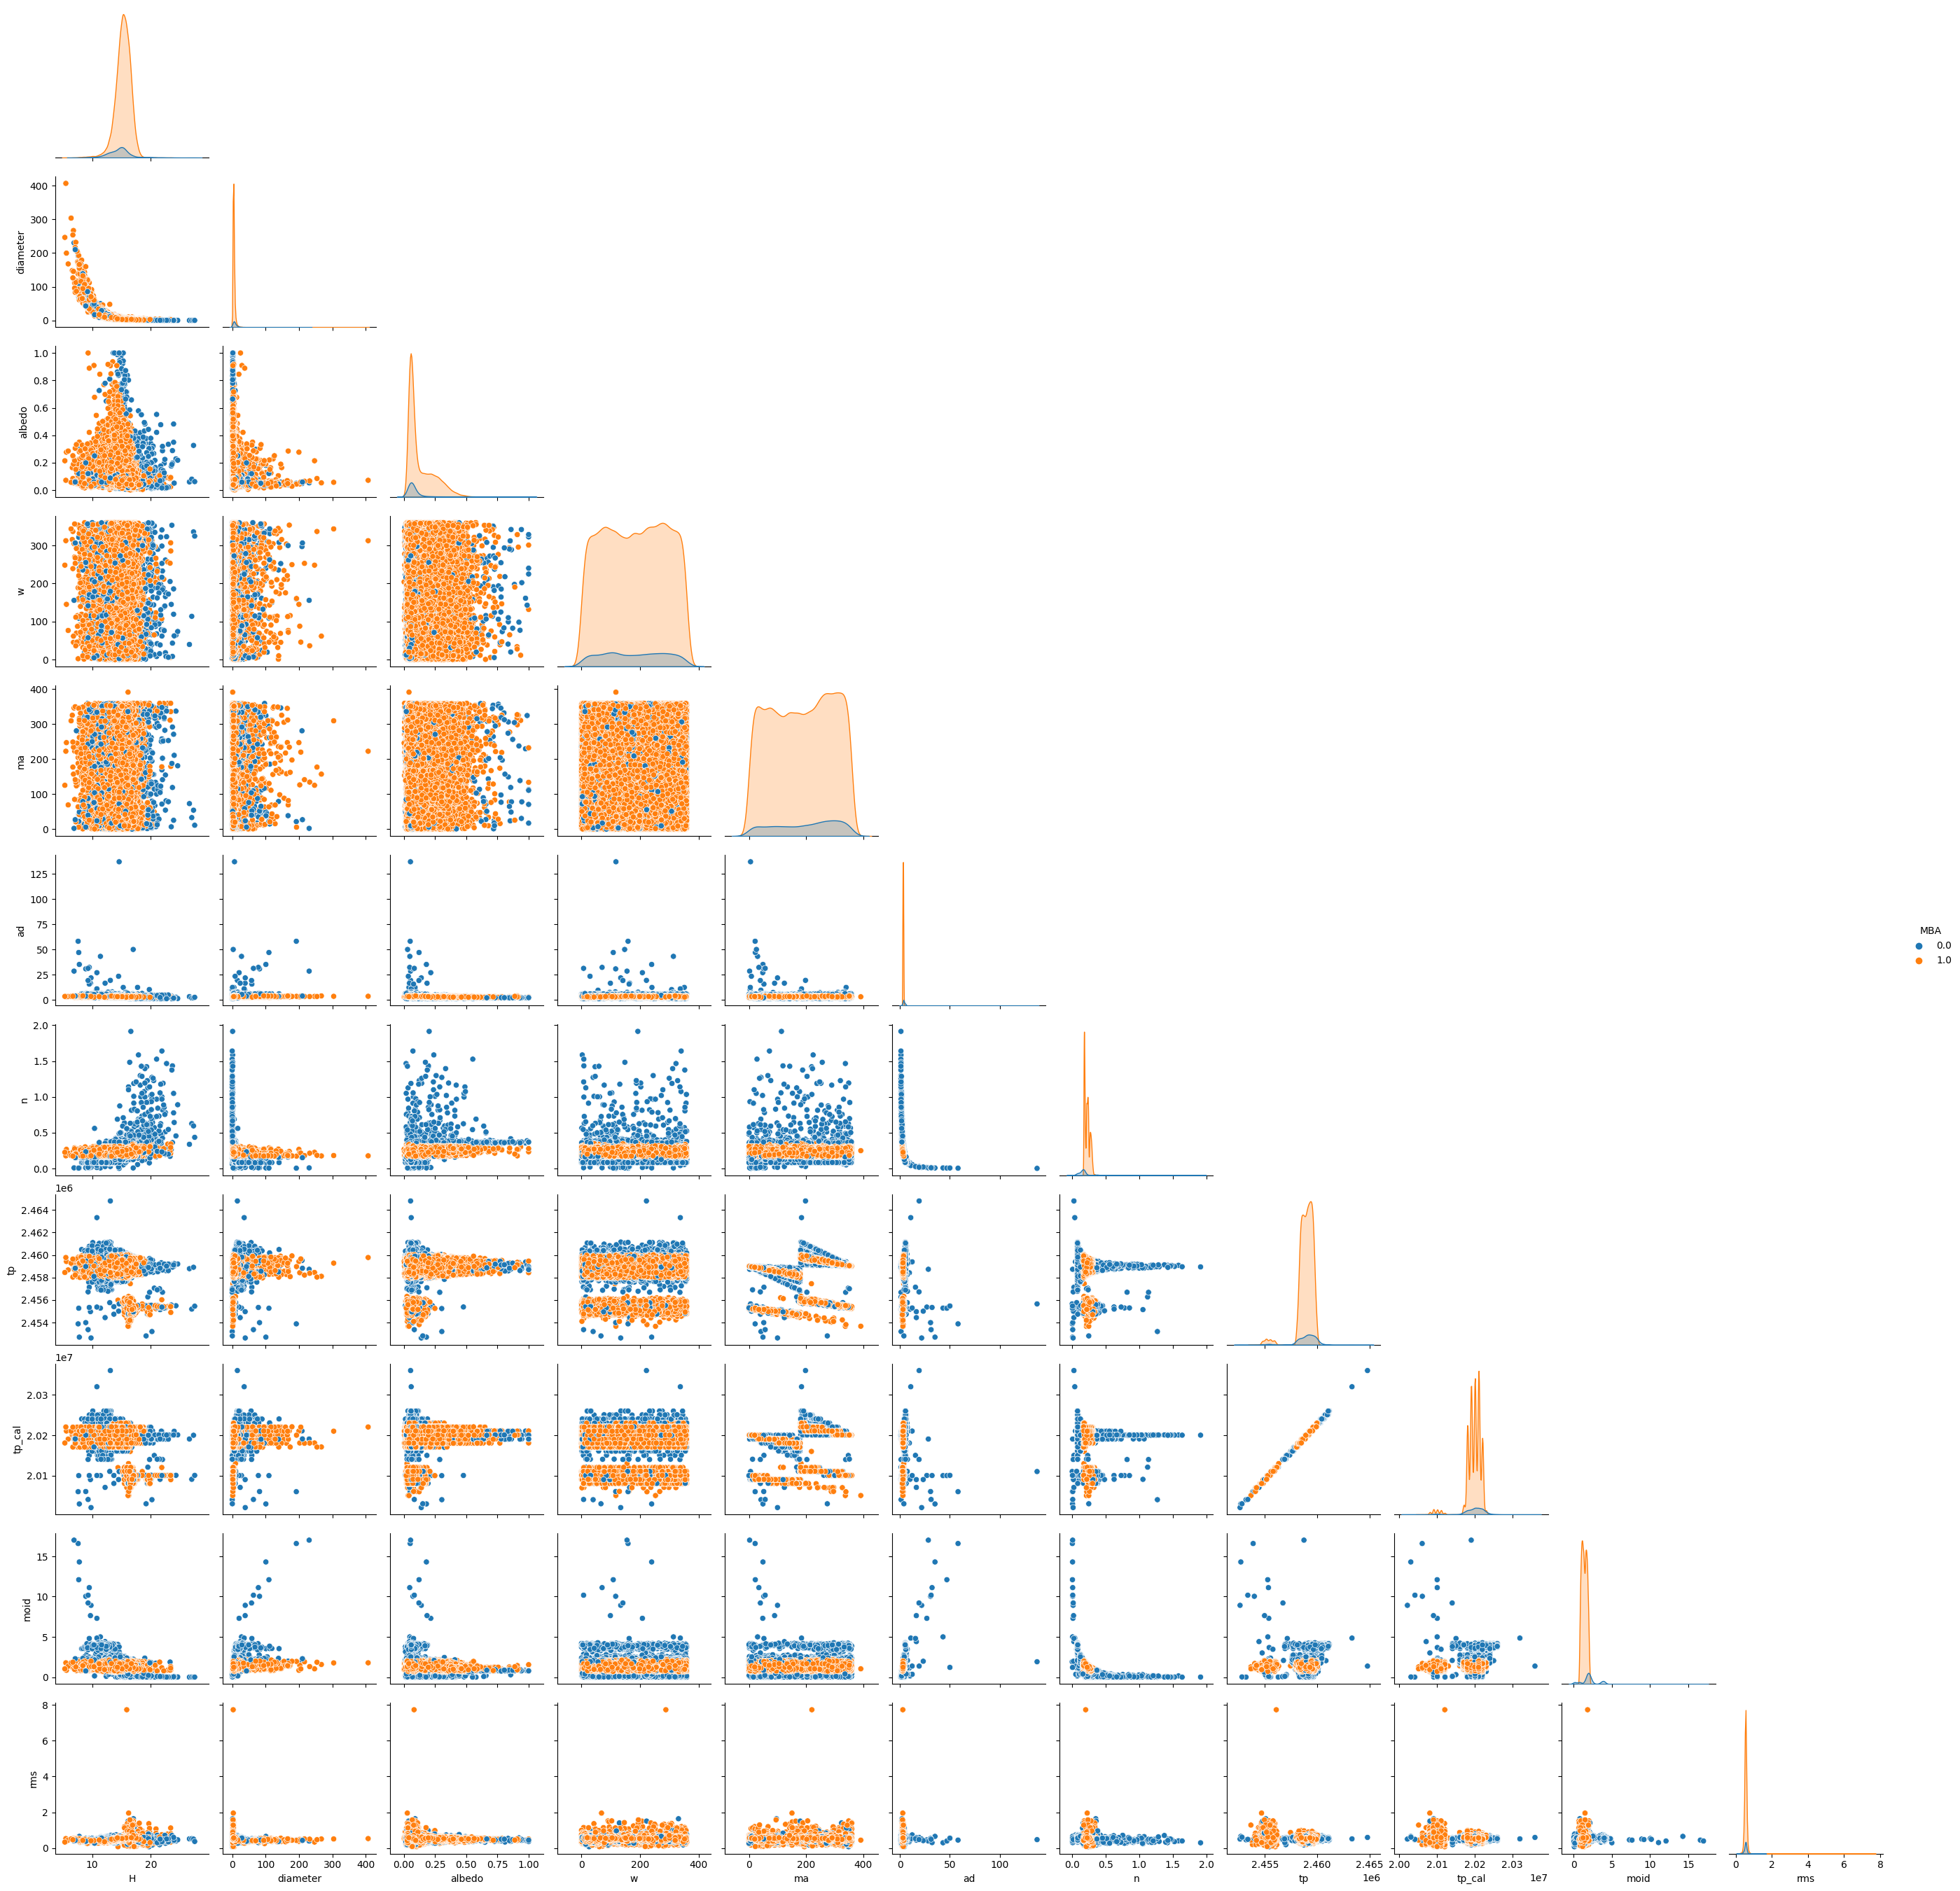

In [16]:
# Visualise the correlations between features and targets:

# Pairplot for Numerical Continuous Features
sns.pairplot(data = Train_Dataset.iloc[:50000][["H", "diameter", "albedo", "w", "ma", "ad", "n", "tp", "tp_cal", "moid", "rms", "MBA"]], hue = "MBA", corner = True)

In [17]:
# Ensure that the imputation has been conducted correctly 
# and that the object datatypes have been encoded.
Train_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108998 entries, 0 to 108997
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   spkid           108998 non-null  float64
 1   H               108998 non-null  float64
 2   diameter        108998 non-null  float64
 3   albedo          108998 non-null  float64
 4   diameter_sigma  108998 non-null  float64
 5   epoch           108998 non-null  float64
 6   epoch_mjd       108998 non-null  float64
 7   epoch_cal       108998 non-null  float64
 8   e               108998 non-null  float64
 9   a               108998 non-null  float64
 10  q               108998 non-null  float64
 11  i               108998 non-null  float64
 12  om              108998 non-null  float64
 13  w               108998 non-null  float64
 14  ma              108998 non-null  float64
 15  ad              108998 non-null  float64
 16  n               108998 non-null  float64
 17  tp        

In [18]:
# Identify the Initial Set of Features:
Classification_Targets = ["MBA", "OMB", "Other", "neo", "pha"] 
Regression_Targets = ["diameter", "diameter_sigma"]

# Identify the Features:
columns = set(Train_Dataset.columns)
Features = list(columns - set(Classification_Targets) - set(Regression_Targets))

<Axes: xlabel='H', ylabel='Proportion'>

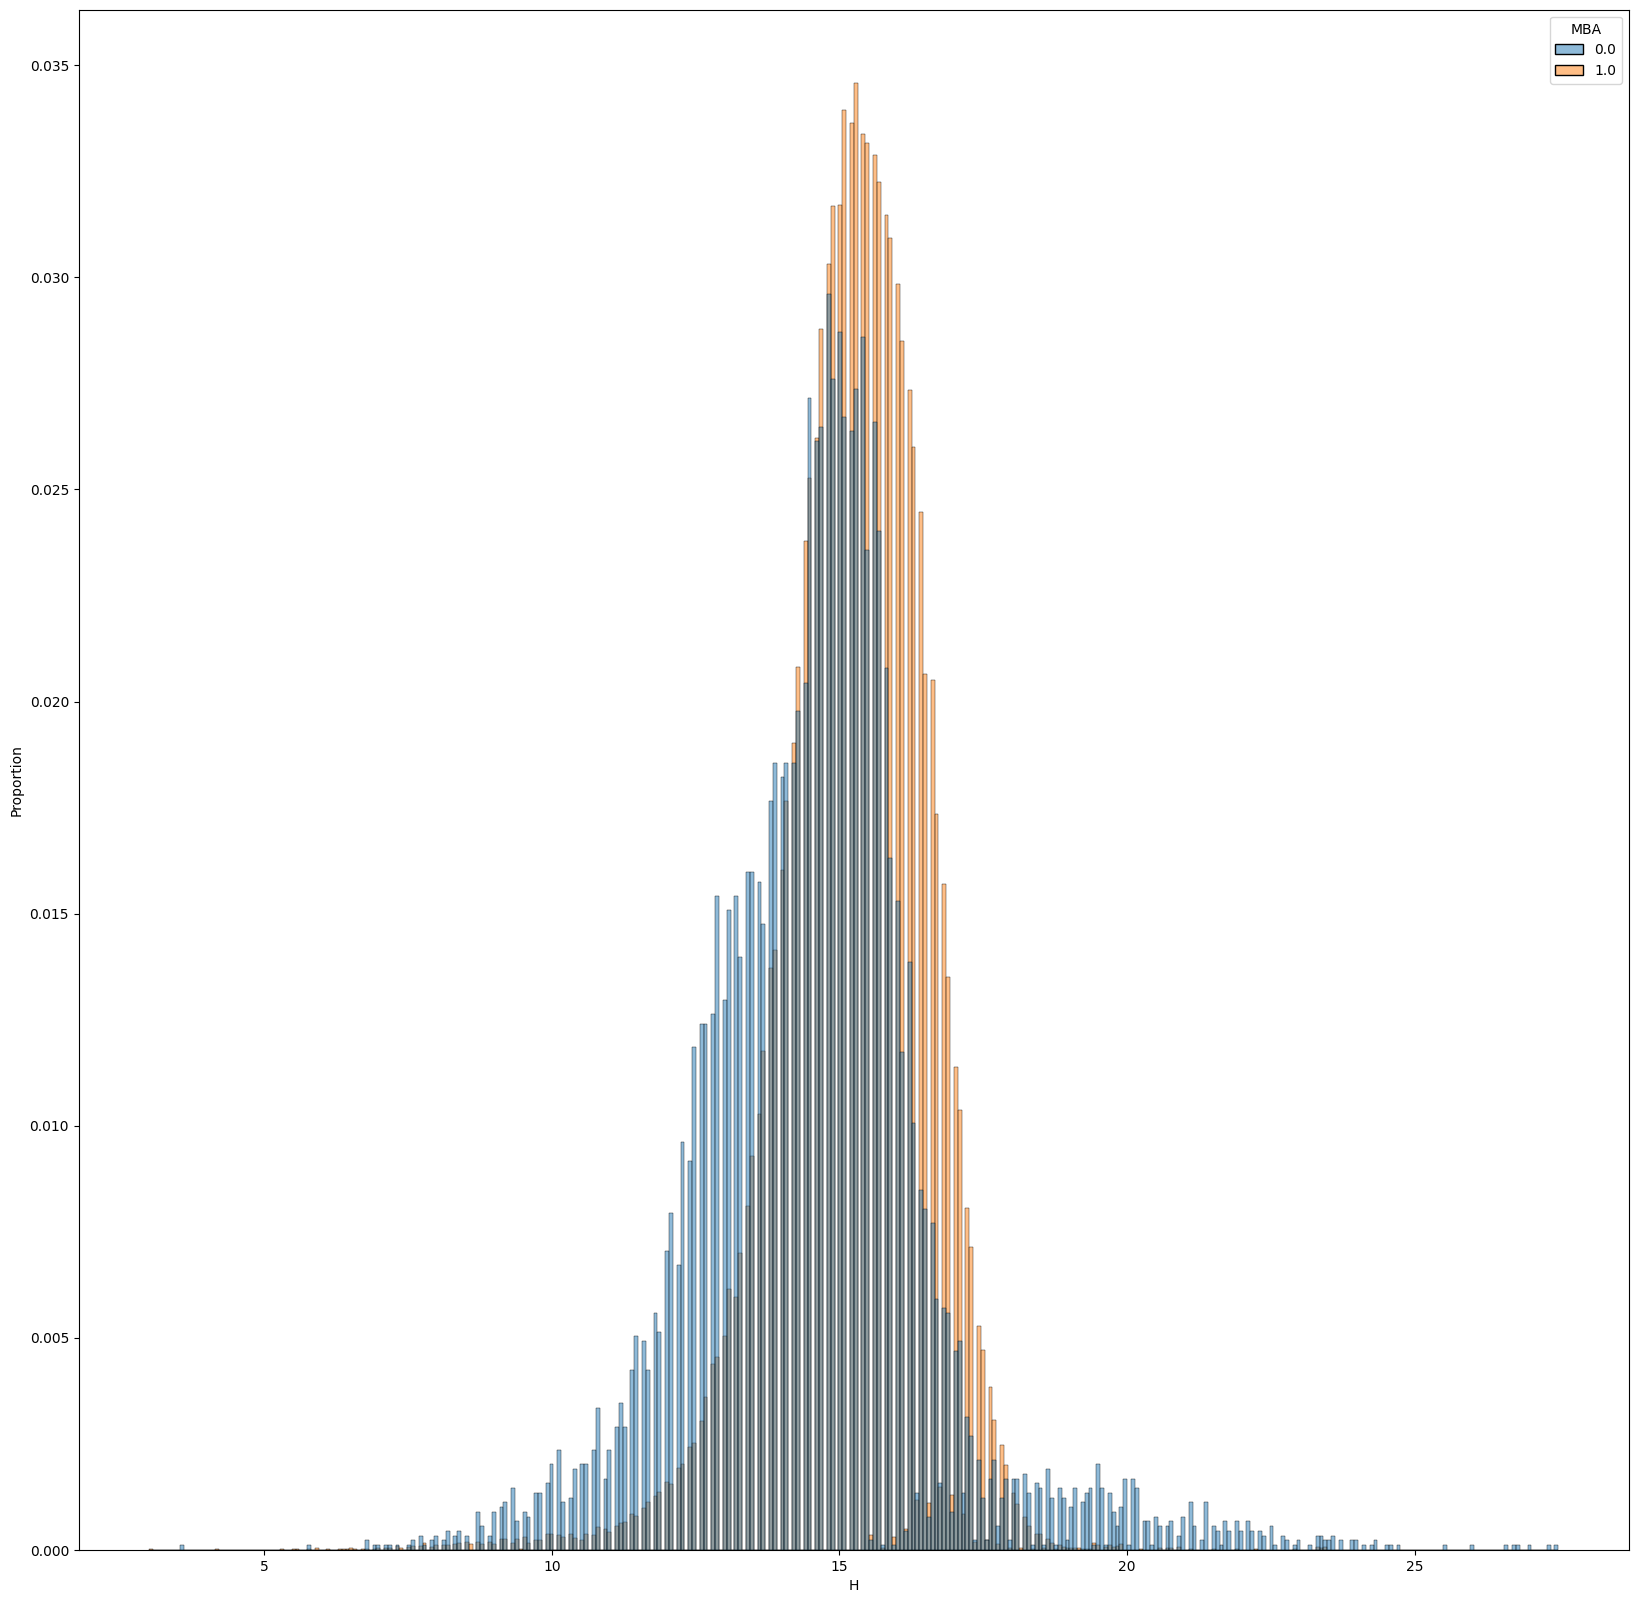

In [19]:
# Visualise potential differences in classes
sns.histplot(data = Train_Dataset, x = "H", hue = "MBA", stat = "proportion", common_norm  = False)

In [20]:
# Print the Features for the Classification Tasks
Train_Dataset.loc[:, ~Train_Dataset.columns.isin([Classification_Targets])].columns

Index(['spkid', 'H', 'diameter', 'albedo', 'diameter_sigma', 'epoch',
       'epoch_mjd', 'epoch_cal', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad',
       'n', 'tp', 'tp_cal', 'per', 'per_y', 'moid', 'moid_ld', 'sigma_e',
       'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma',
       'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'rms', 'neo', 'pha',
       'MBA', 'OMB', 'orbit_id', 'Other'],
      dtype='object')

<Axes: xlabel='diameter', ylabel='Proportion'>

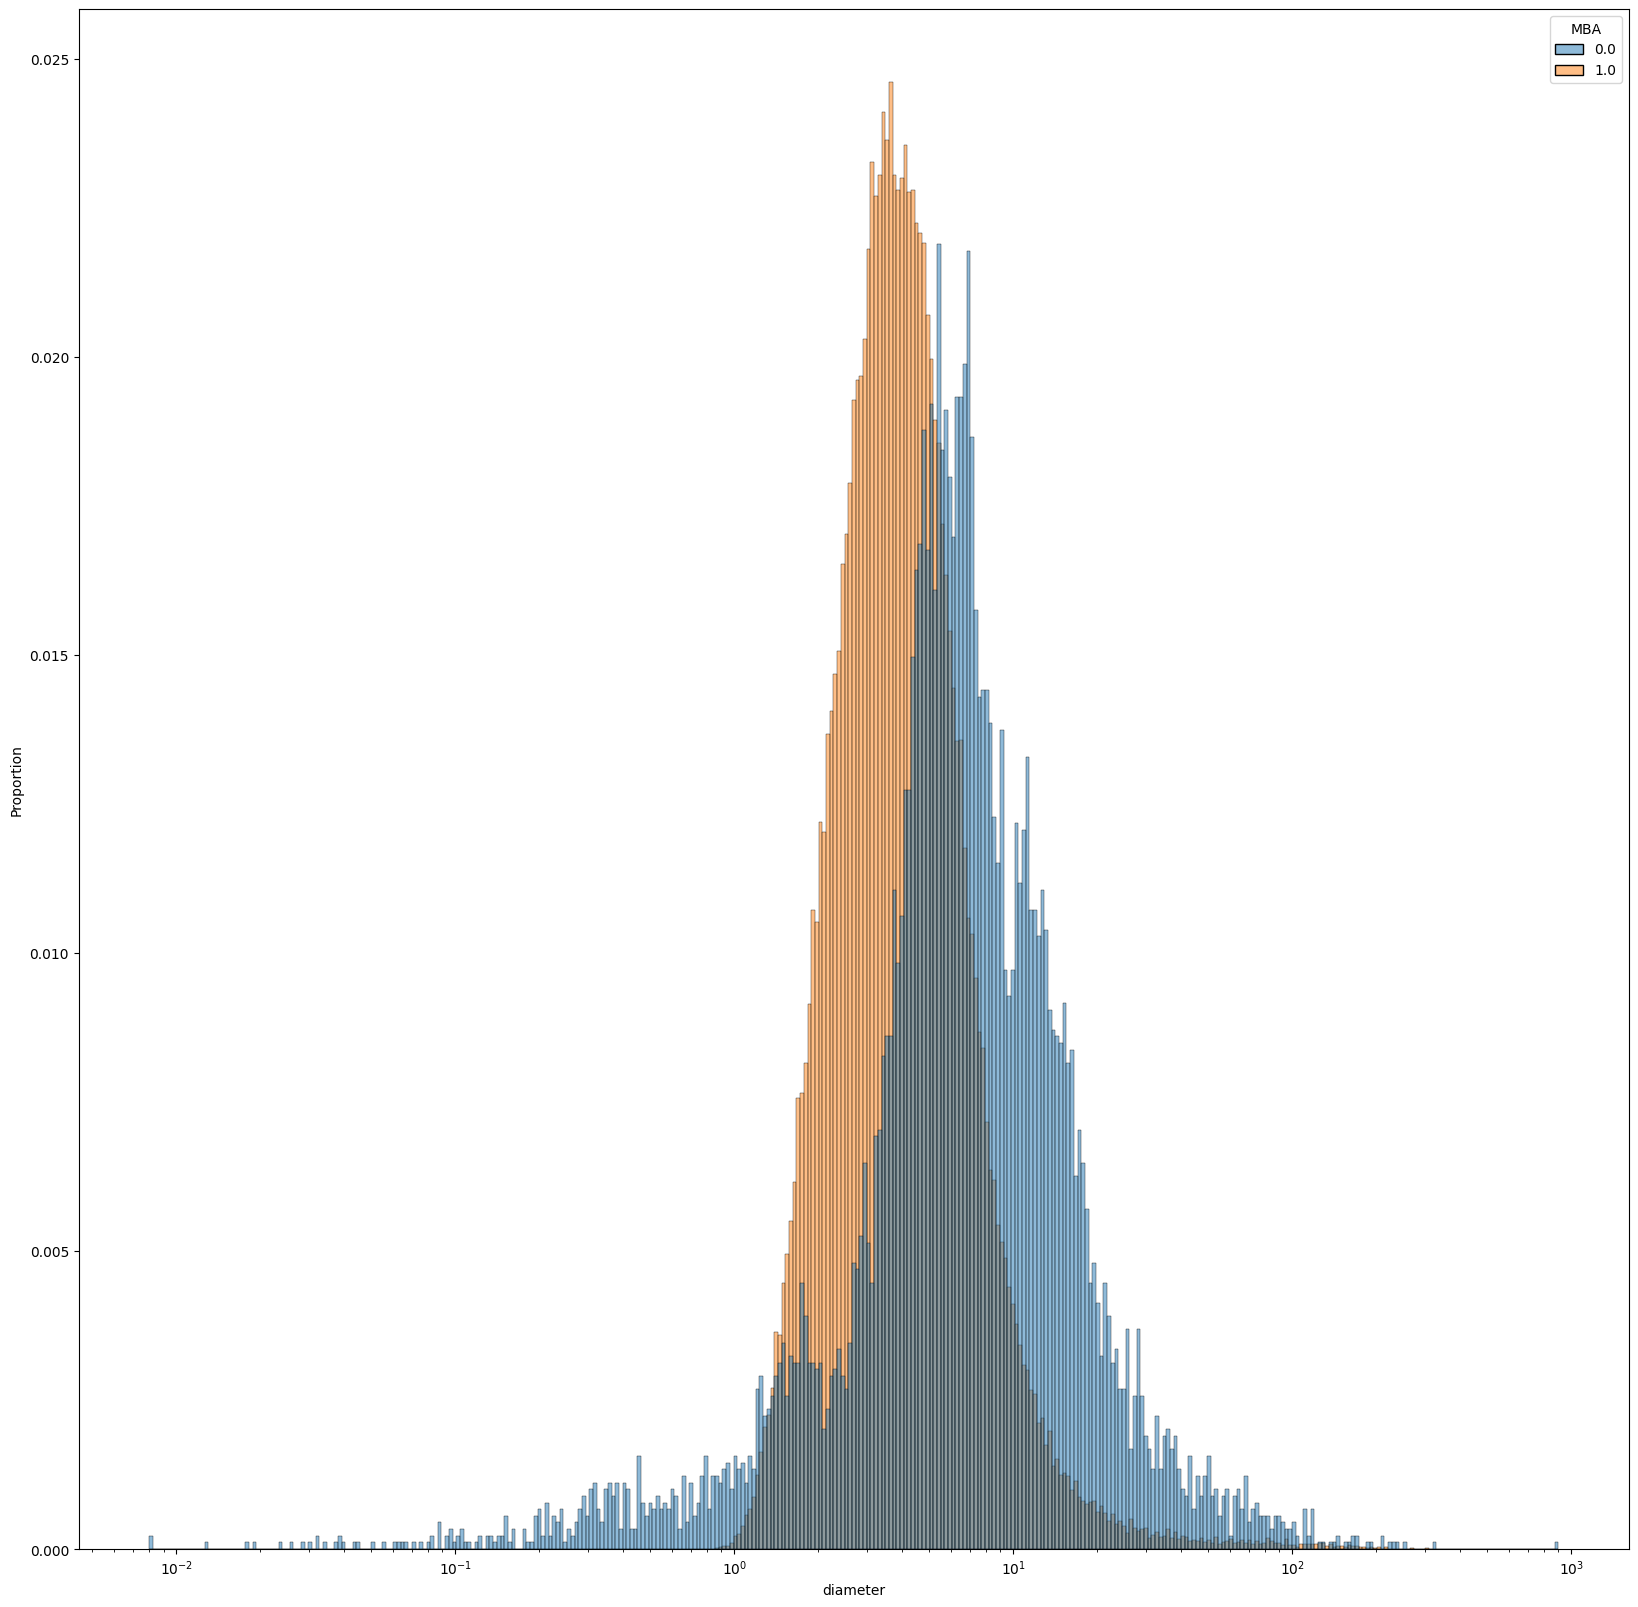

In [21]:
# Visualise potential differences in classes
sns.histplot(data = Train_Dataset, x = "diameter", hue = "MBA", stat = "proportion", log_scale = True, common_norm = False)

<Axes: xlabel='e', ylabel='Proportion'>

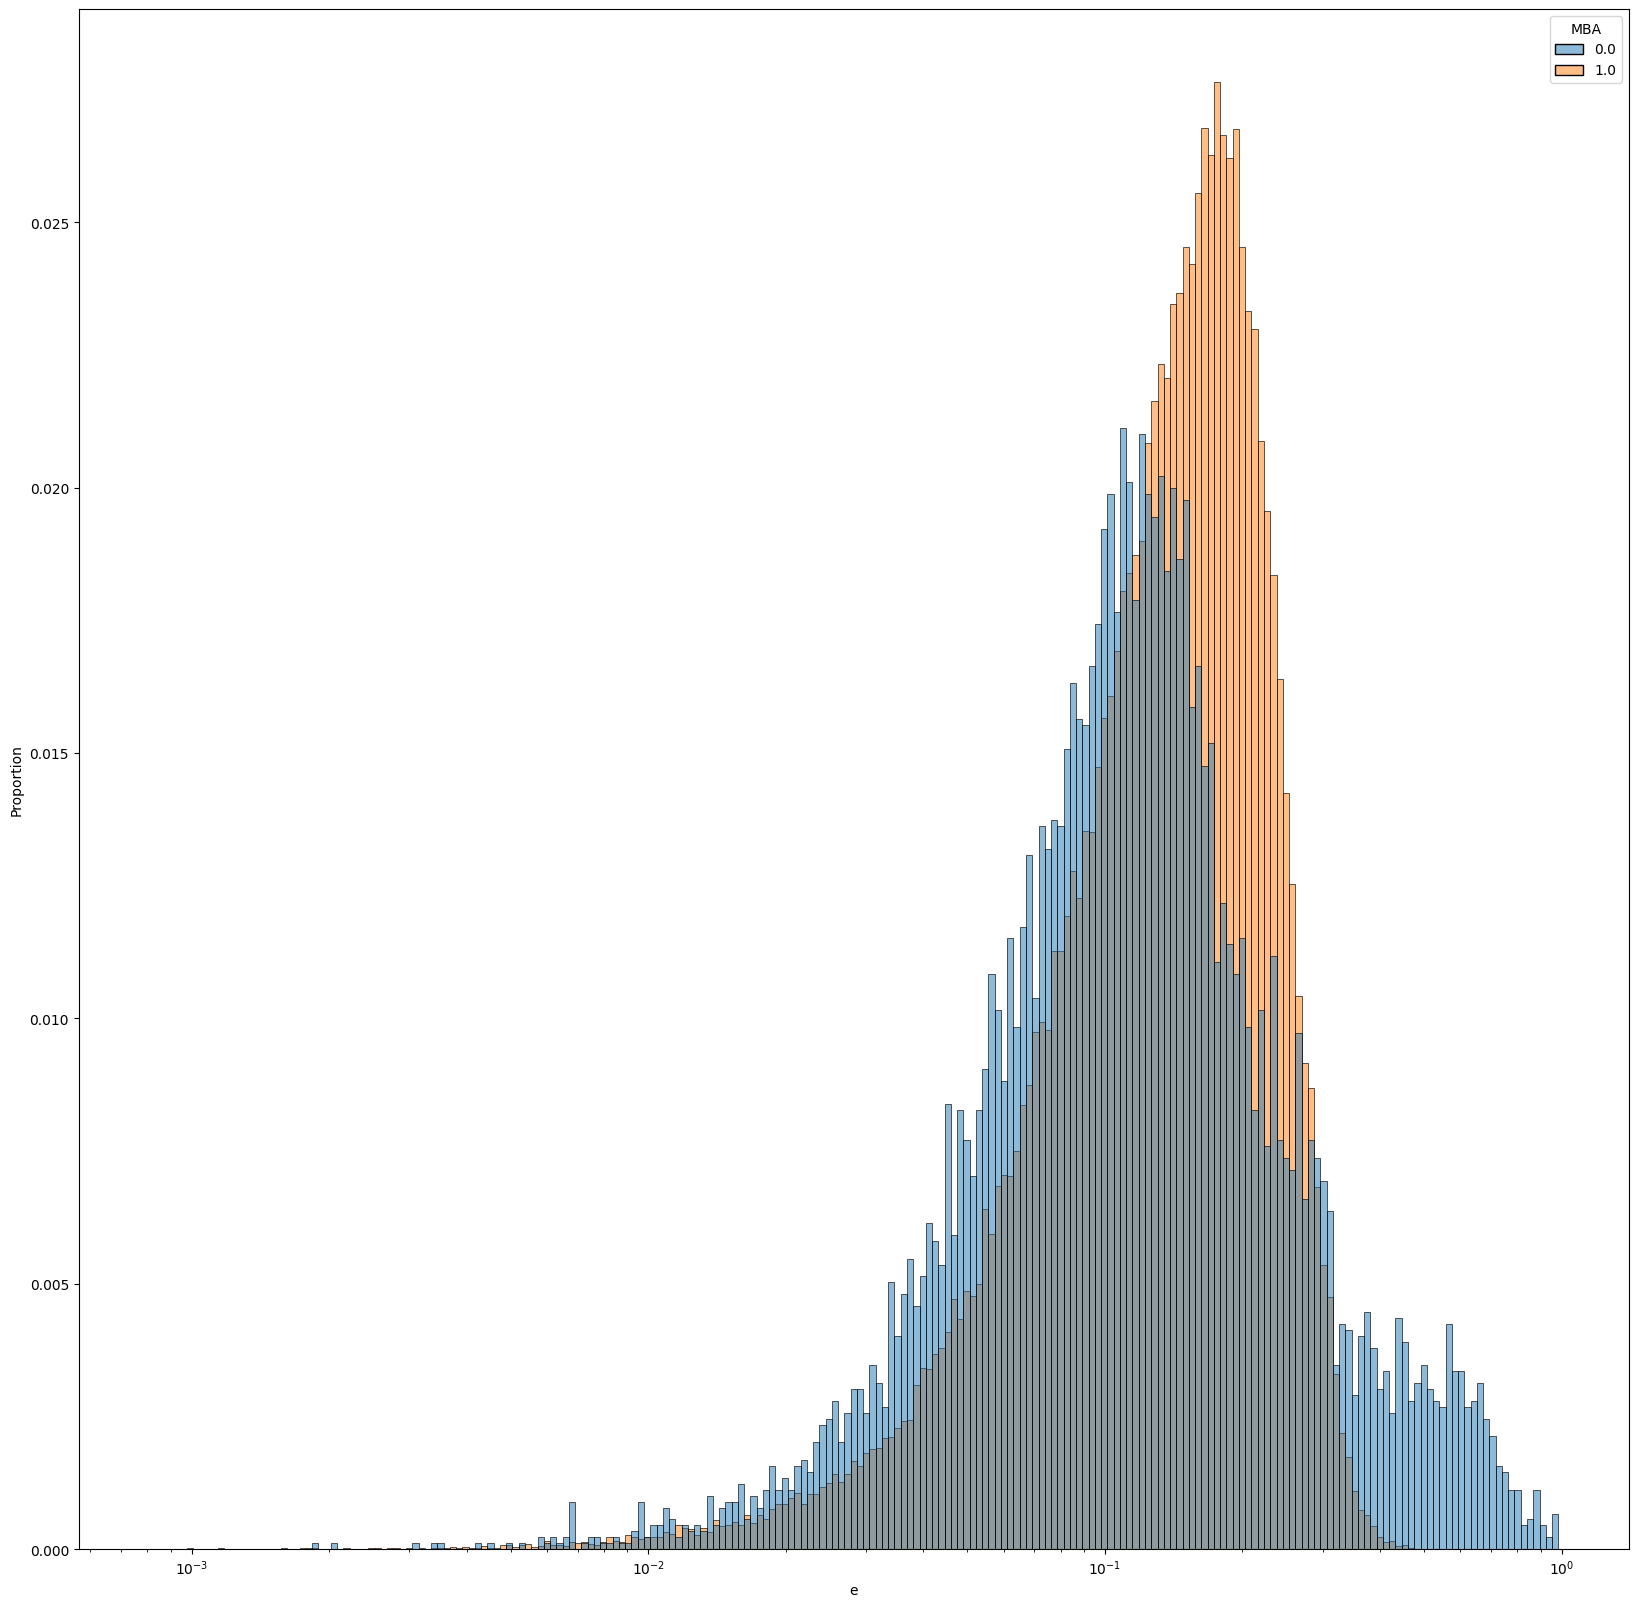

In [22]:
# Visualise potential differences in classes
sns.histplot(data = Train_Dataset, x = "e", hue = "MBA", stat = "proportion", log_scale = True, common_norm = False)

<Axes: xlabel='H', ylabel='Proportion'>

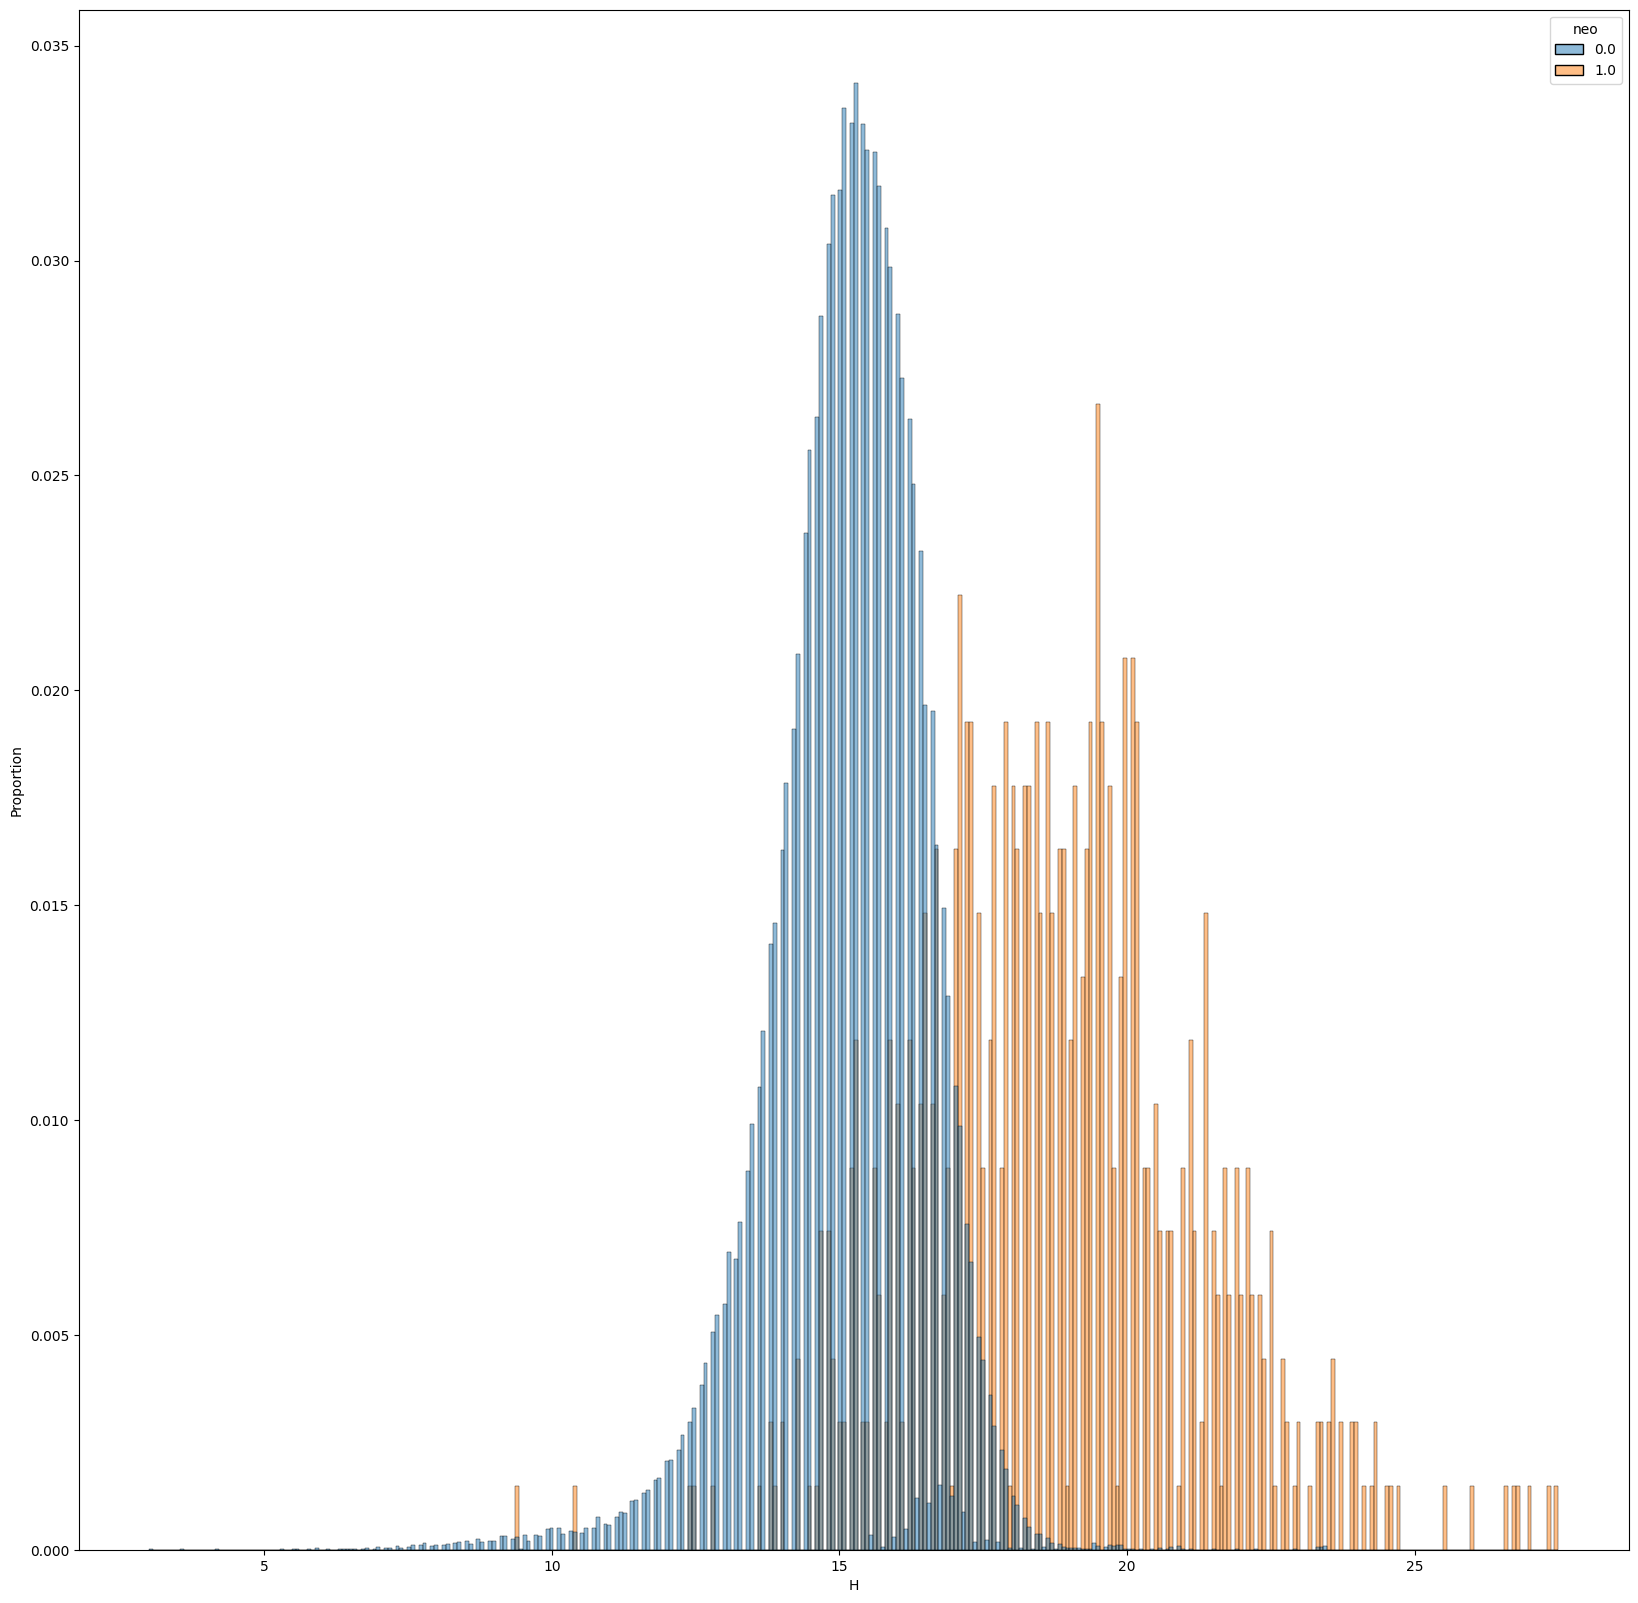

In [23]:
# Visualise potential differences in classes
sns.histplot(data = Train_Dataset, x = "H", hue = "neo", stat = "proportion", common_norm = False)

<Axes: xlabel='diameter', ylabel='Proportion'>

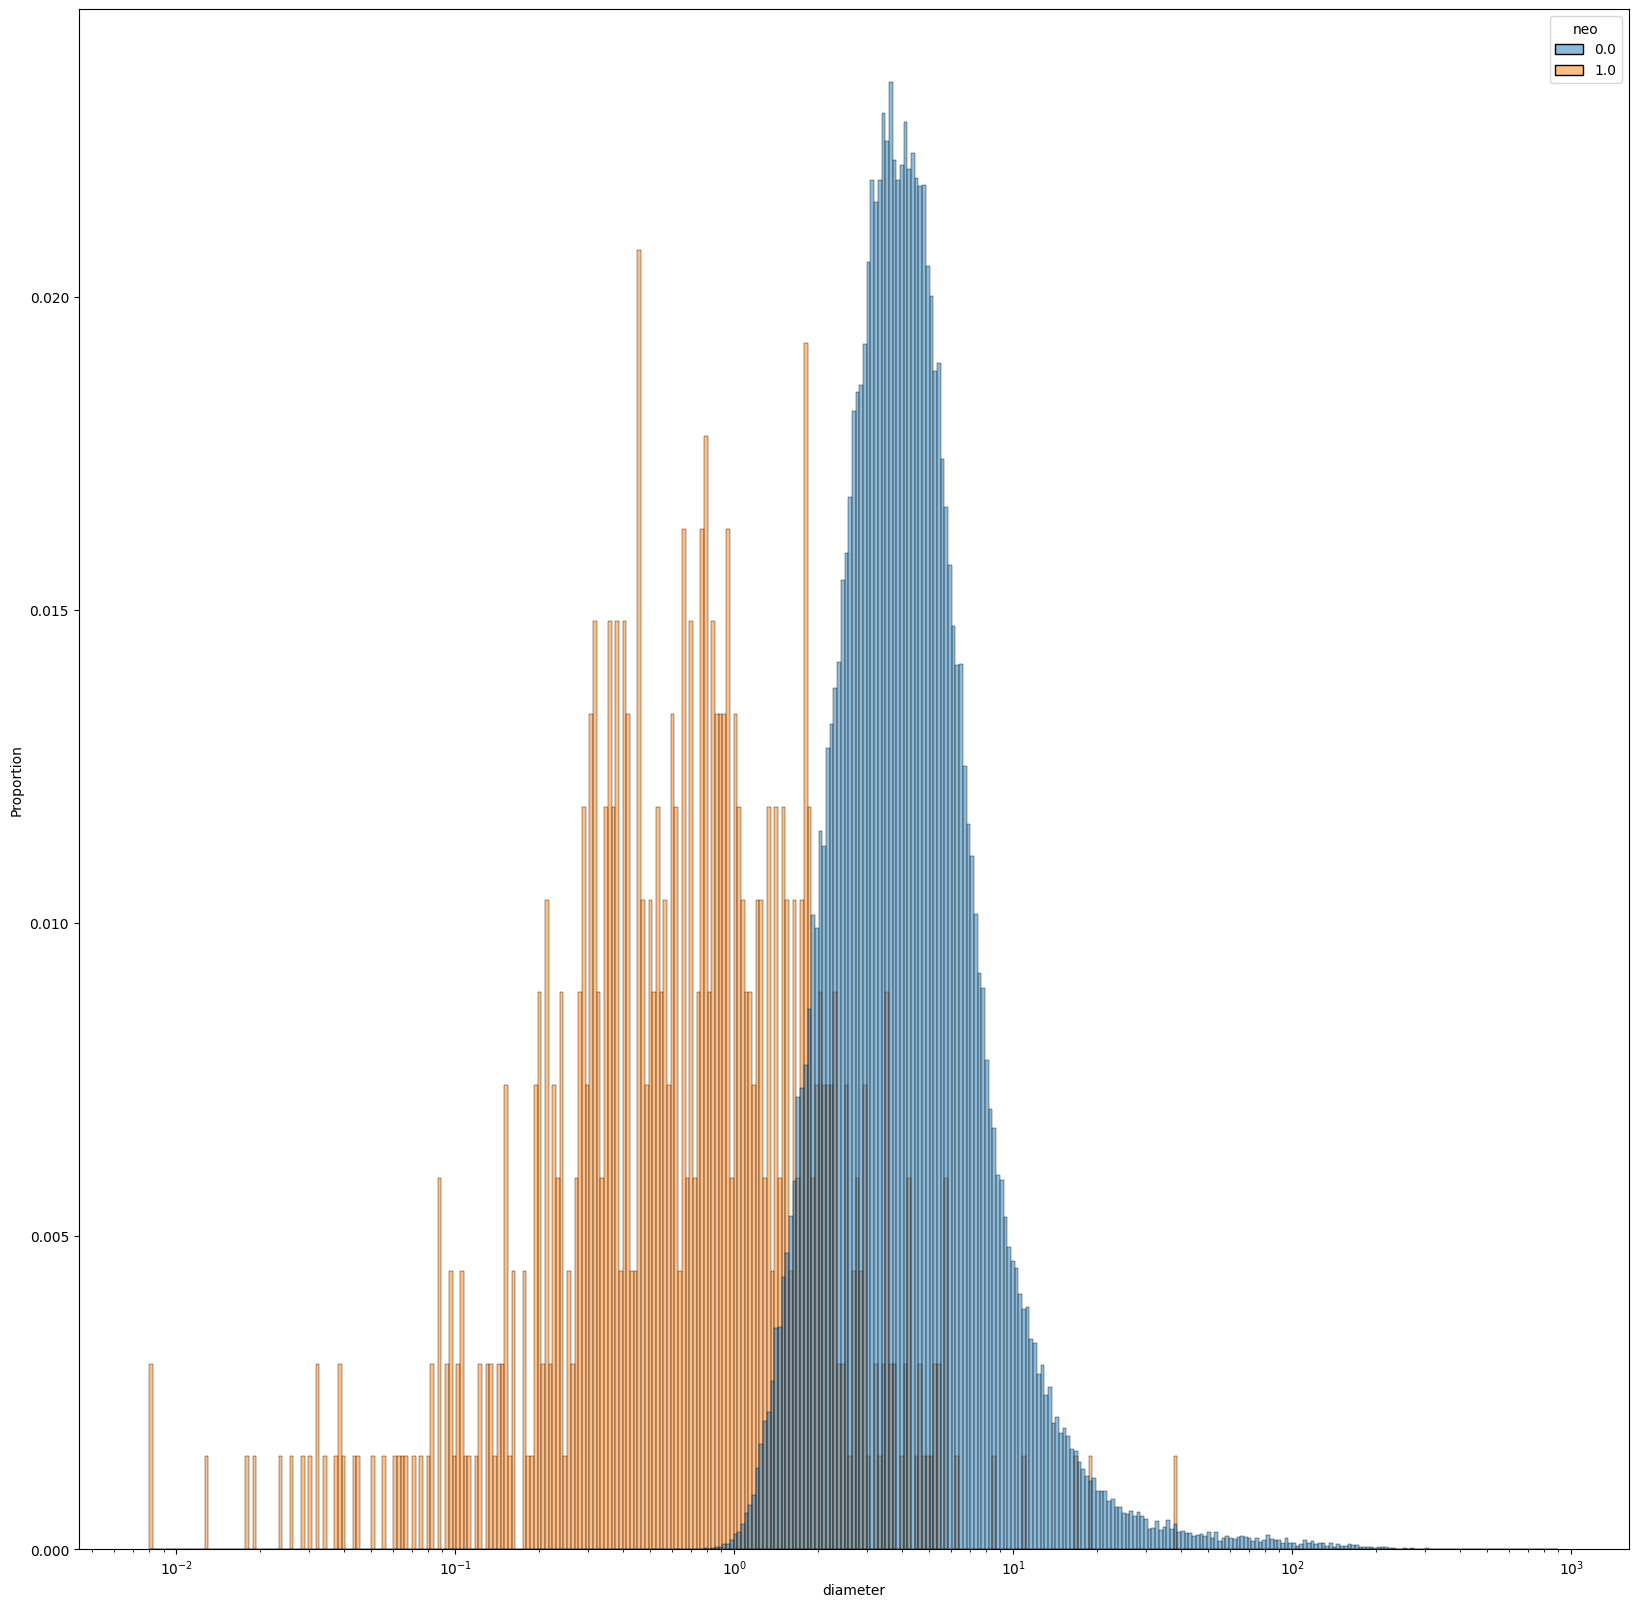

In [24]:
# Visualise potential differences in classes
sns.histplot(data = Train_Dataset, x = "diameter", hue = "neo", stat = "proportion", common_norm = False, log_scale = True)

<Axes: xlabel='e', ylabel='Proportion'>

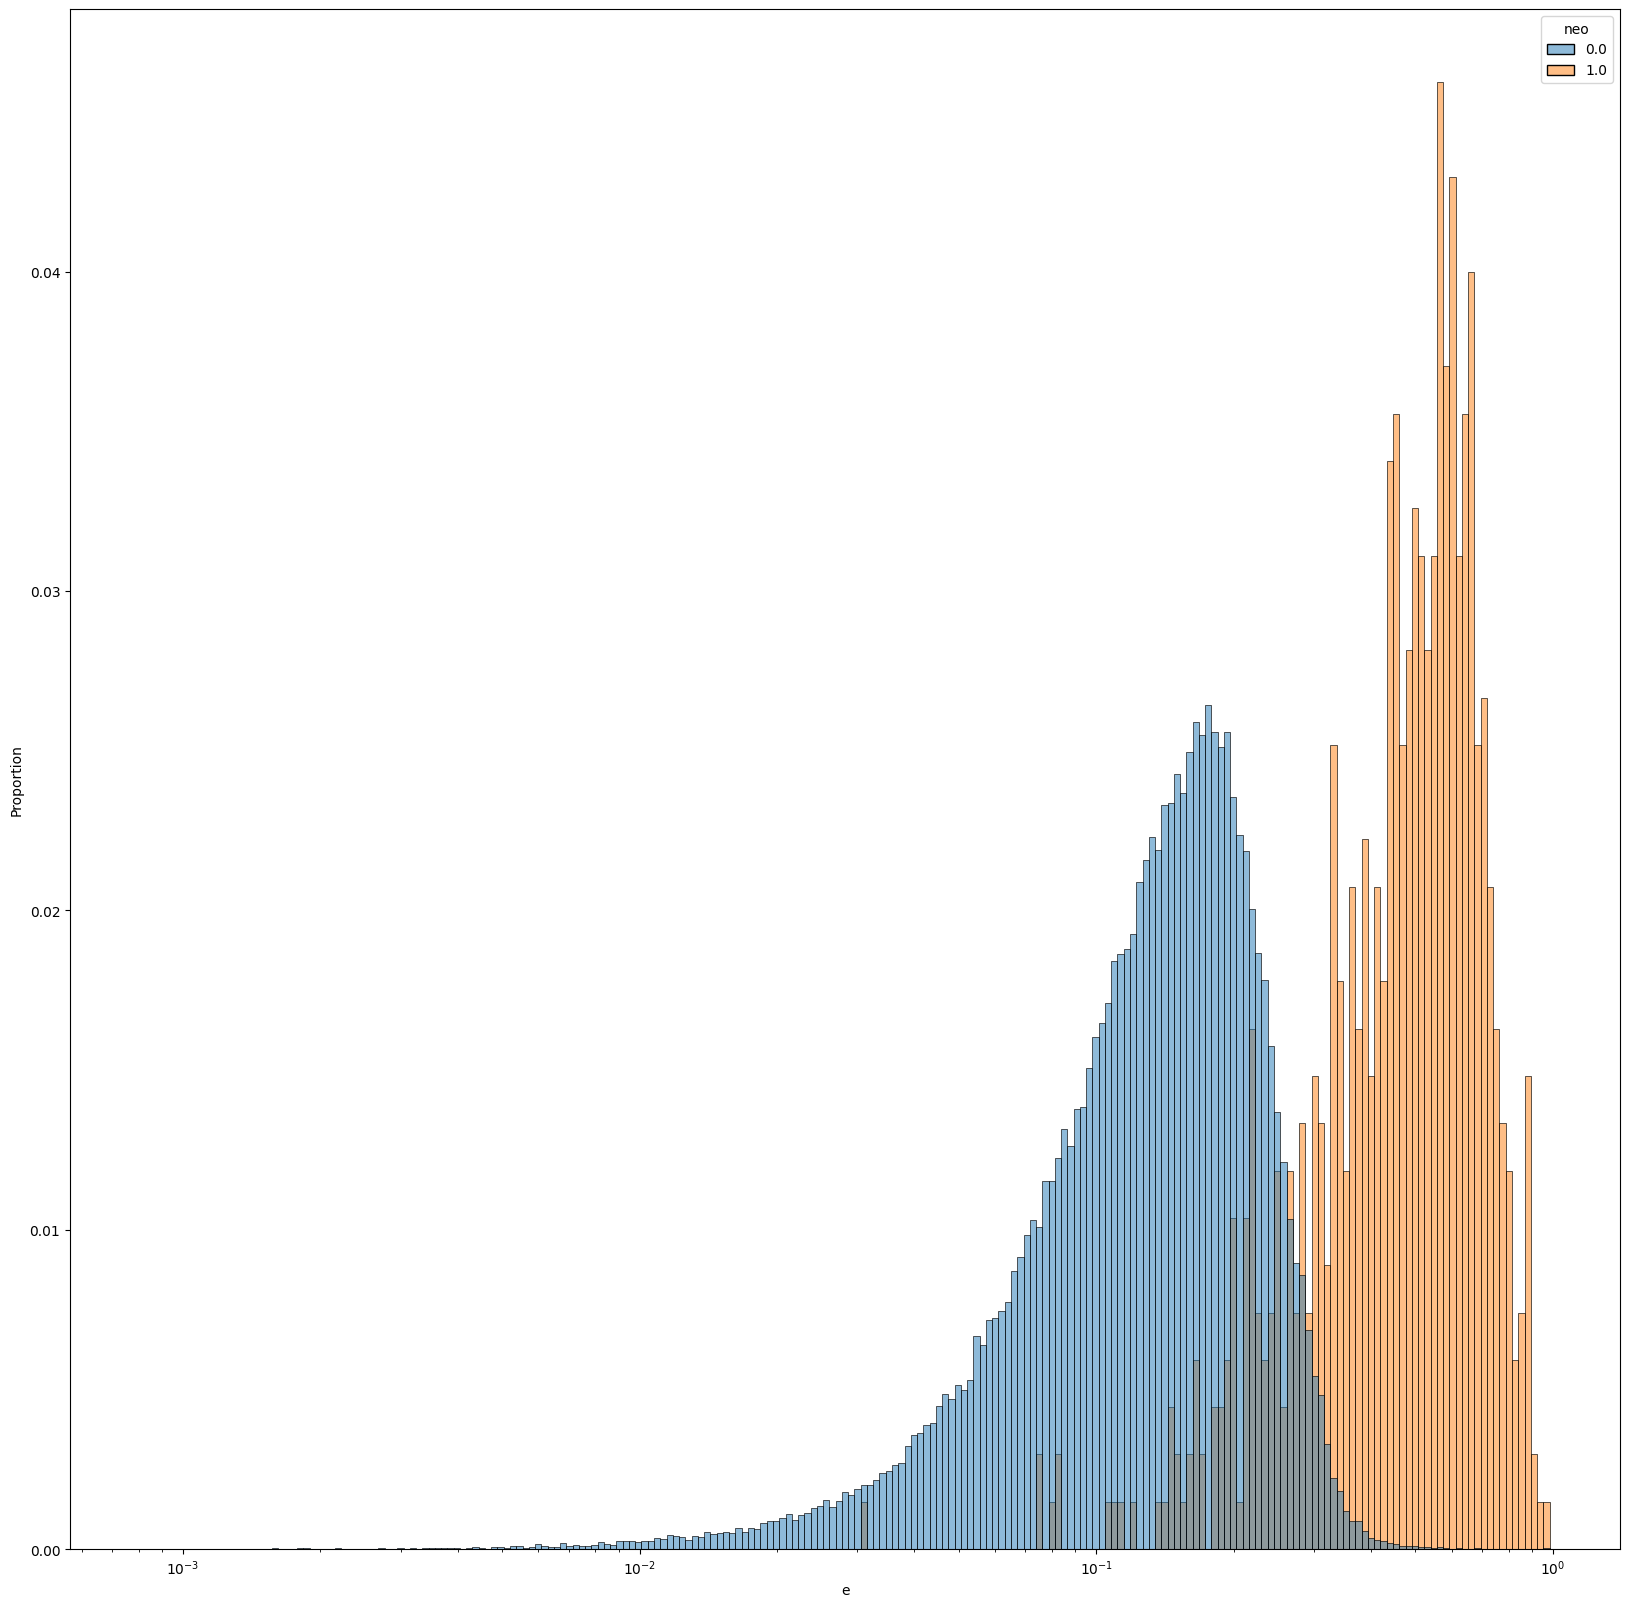

In [25]:
# Visualise potential differences in classes
sns.histplot(data = Train_Dataset, x = "e", hue = "neo", stat = "proportion", common_norm = False, log_scale = True)

<Axes: xlabel='H', ylabel='diameter'>

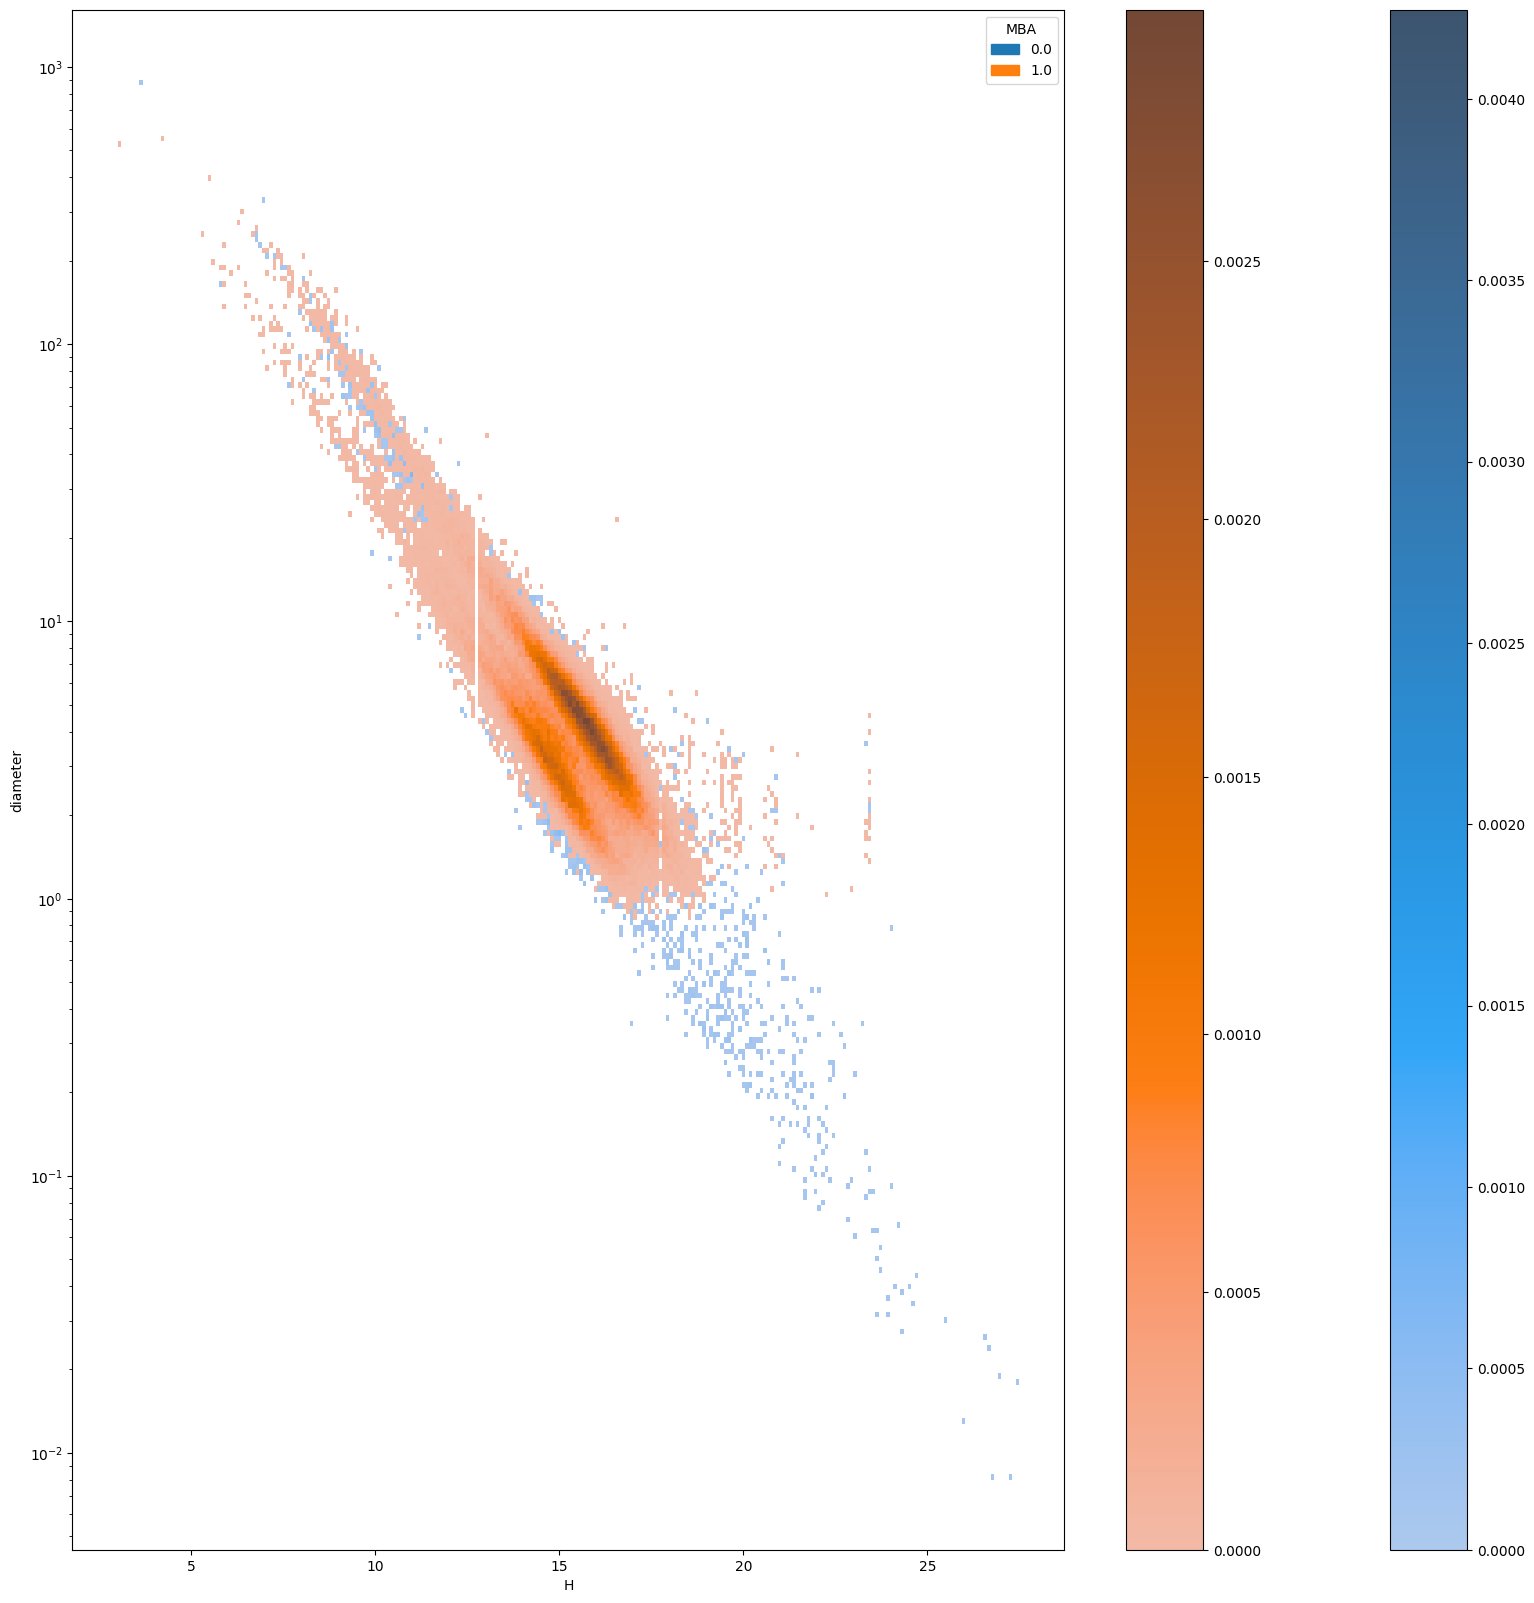

In [26]:
# Visualise the 2D histplot distributions:
sns.histplot(data = Train_Dataset, x = "H", y = "diameter", stat = "proportion", hue = "MBA", common_norm = False, log_scale = (False, True), cbar = True, bins = 250)

<Axes: xlabel='ad', ylabel='n'>

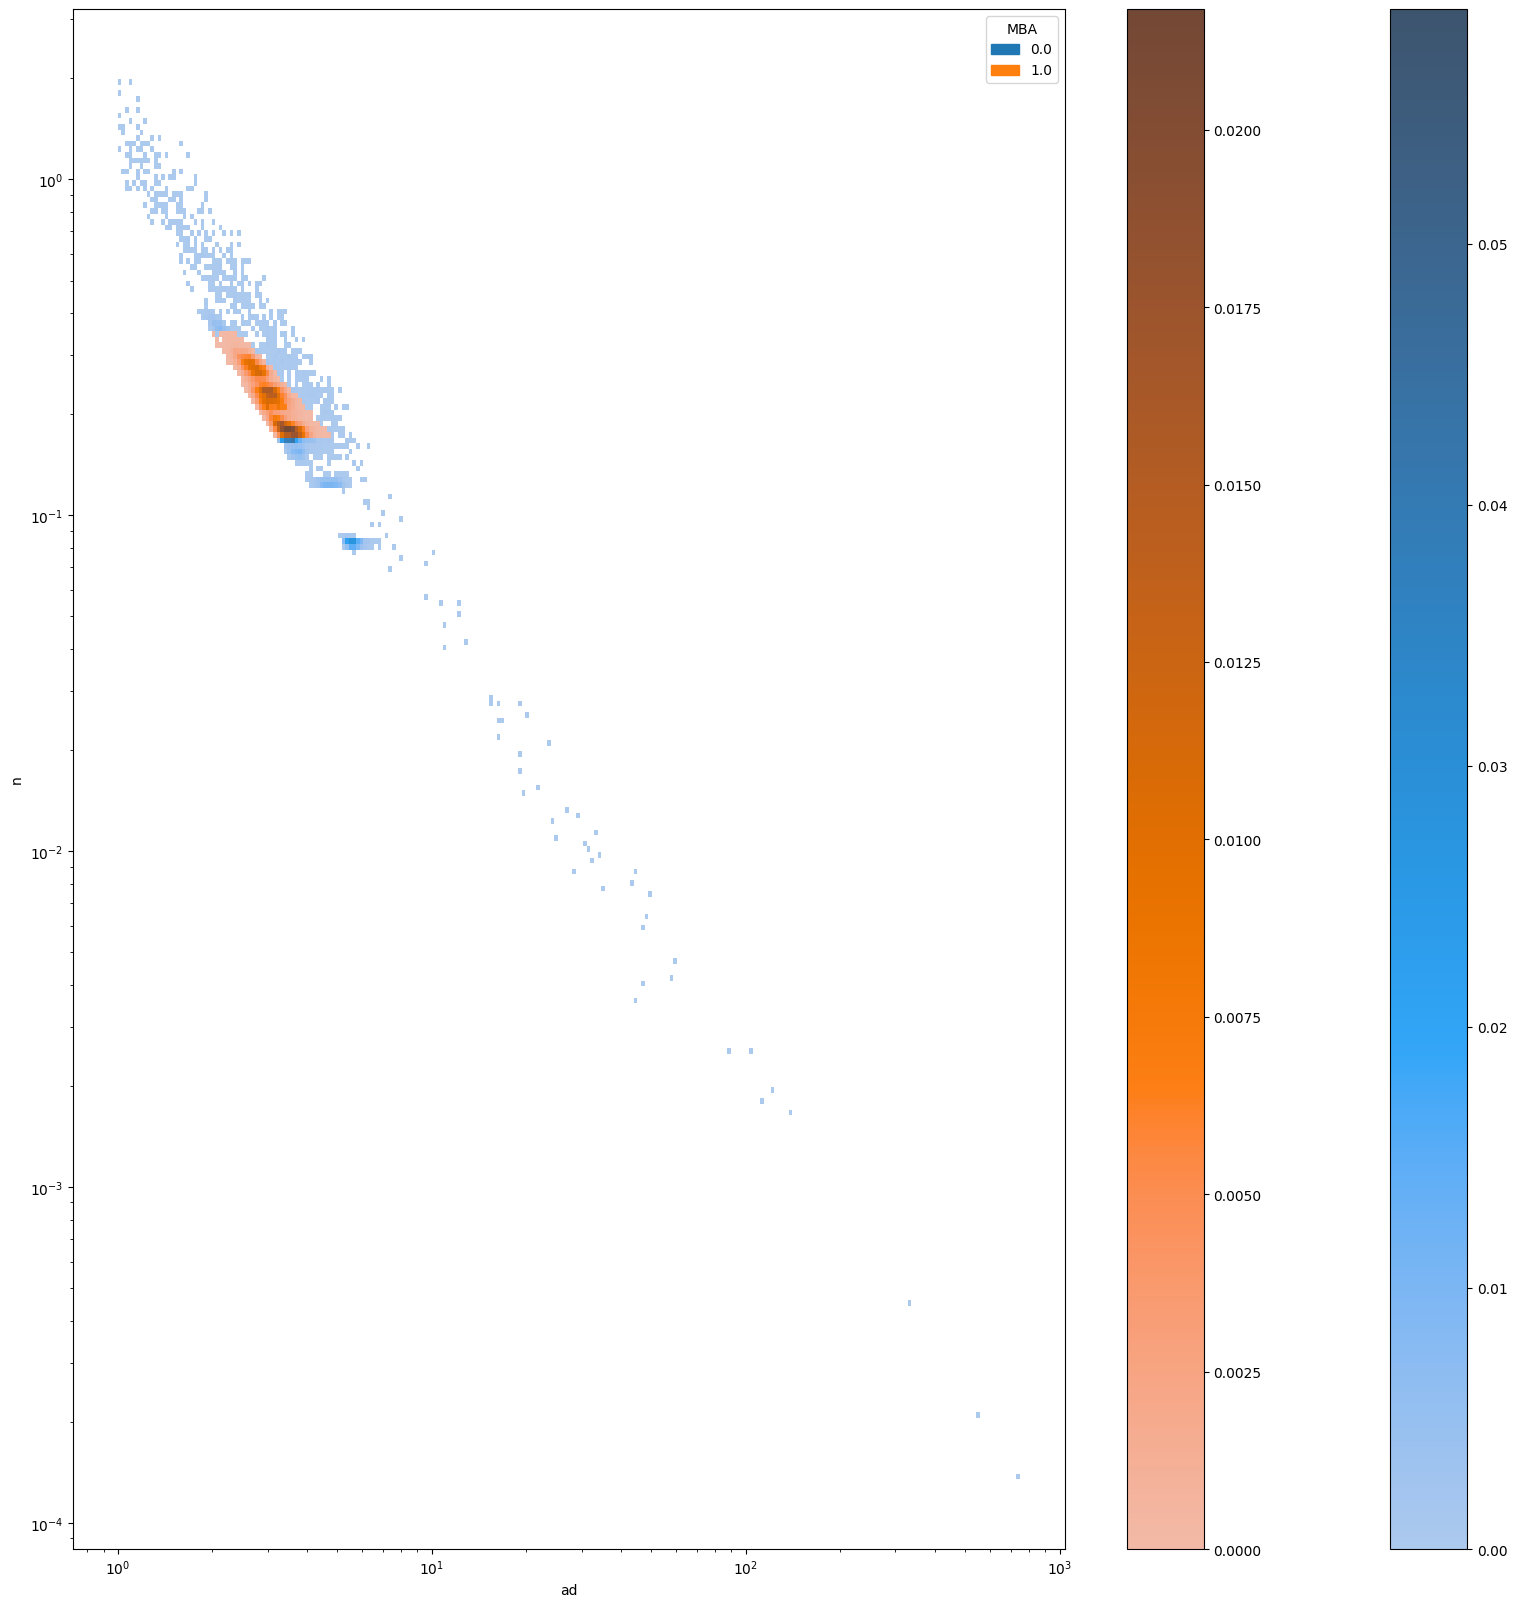

In [27]:
# Visualise the 2D histplot distributions:
sns.histplot(data = Train_Dataset, x = "ad", y = "n", stat = "proportion", hue = "MBA", common_norm = False, log_scale = (True, True), cbar = True, bins = 250)

<Axes: xlabel='e', ylabel='q'>

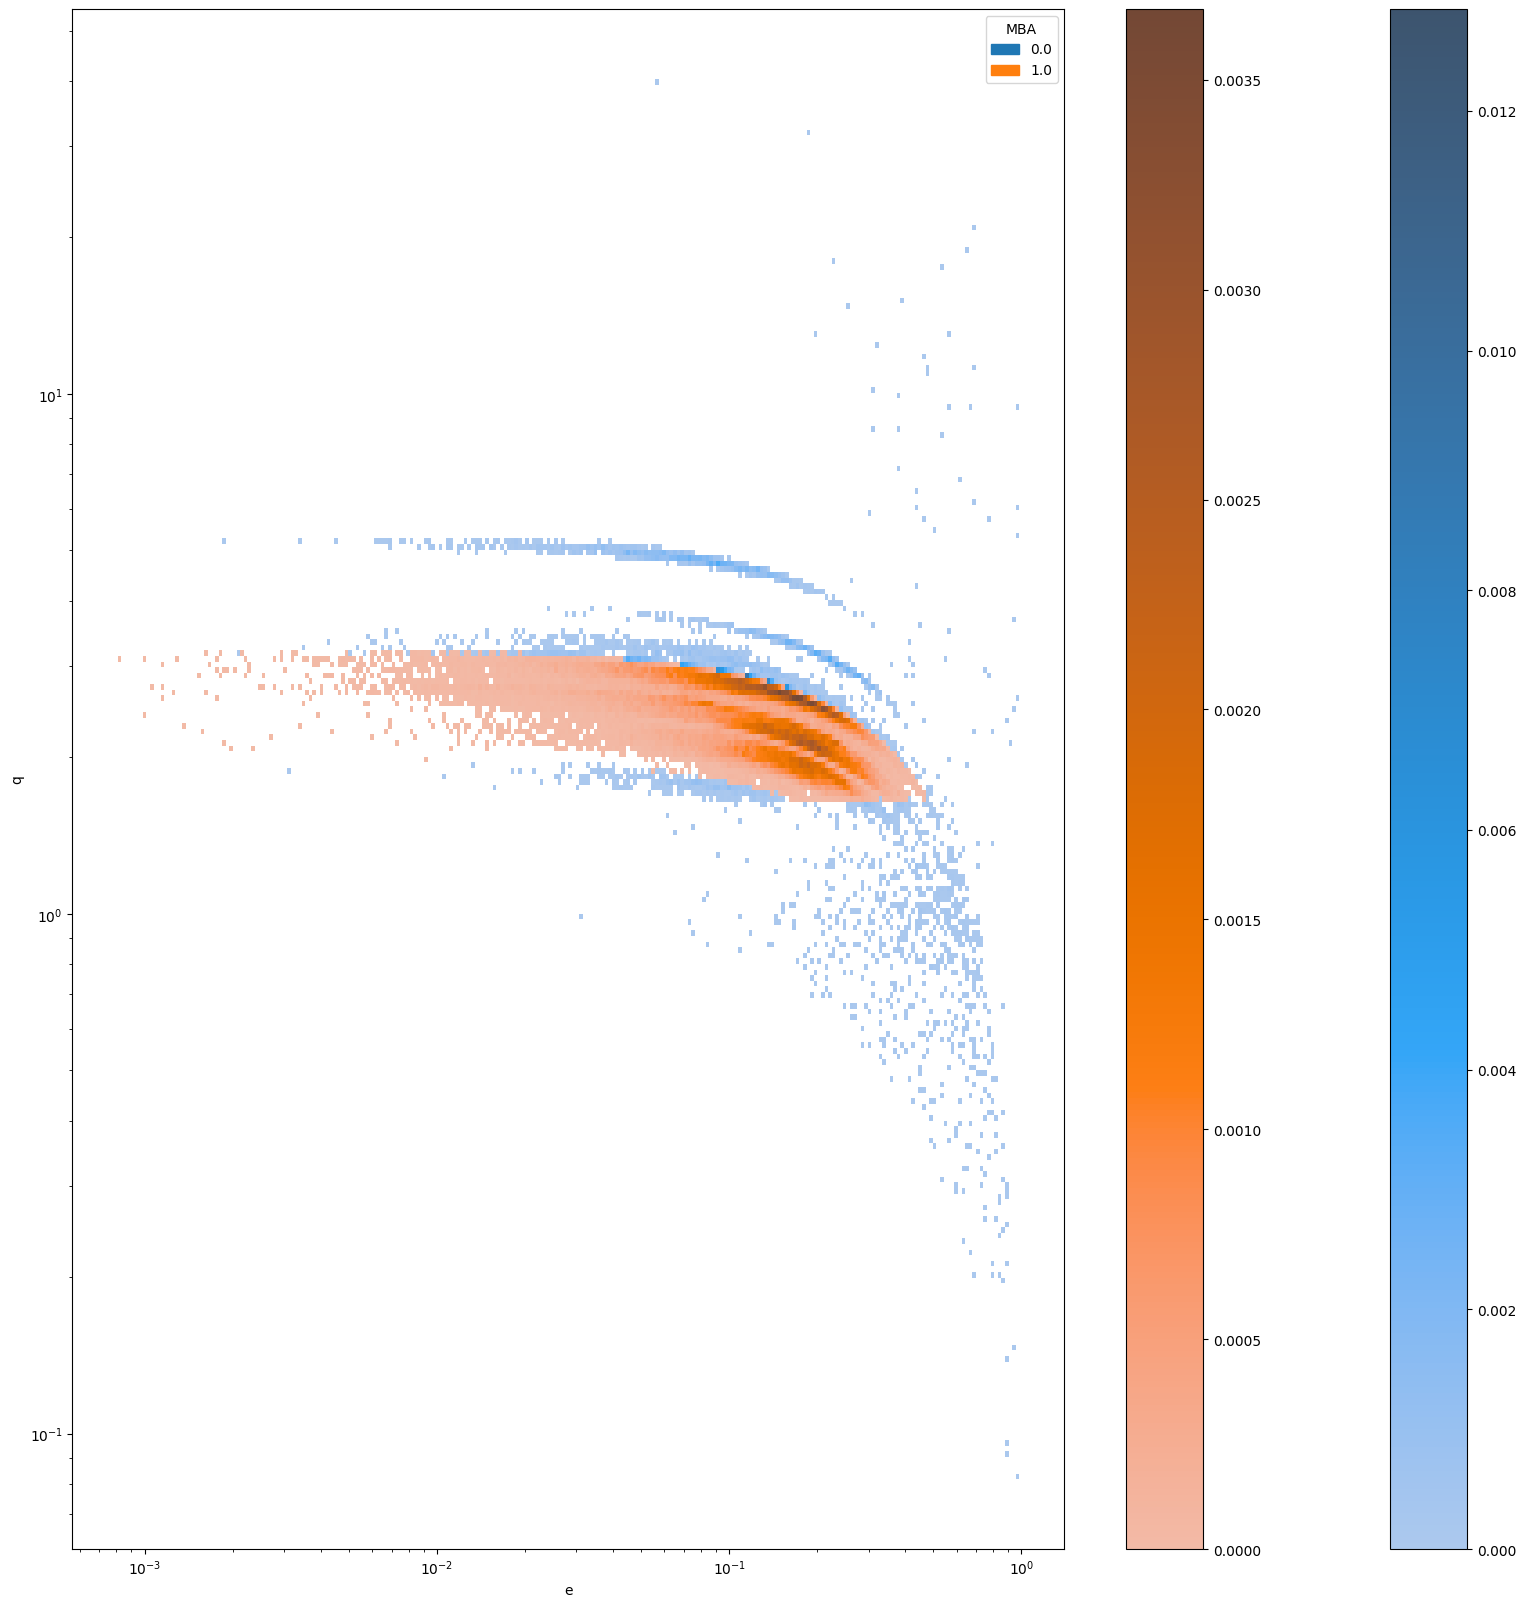

In [28]:
# Visualise the 2D histplot distributions:
sns.histplot(data = Train_Dataset, x = "e", y = "q", stat = "proportion", hue = "MBA", common_norm = False, log_scale = (True, True), cbar = True, bins = 250)

<Axes: xlabel='H', ylabel='diameter'>

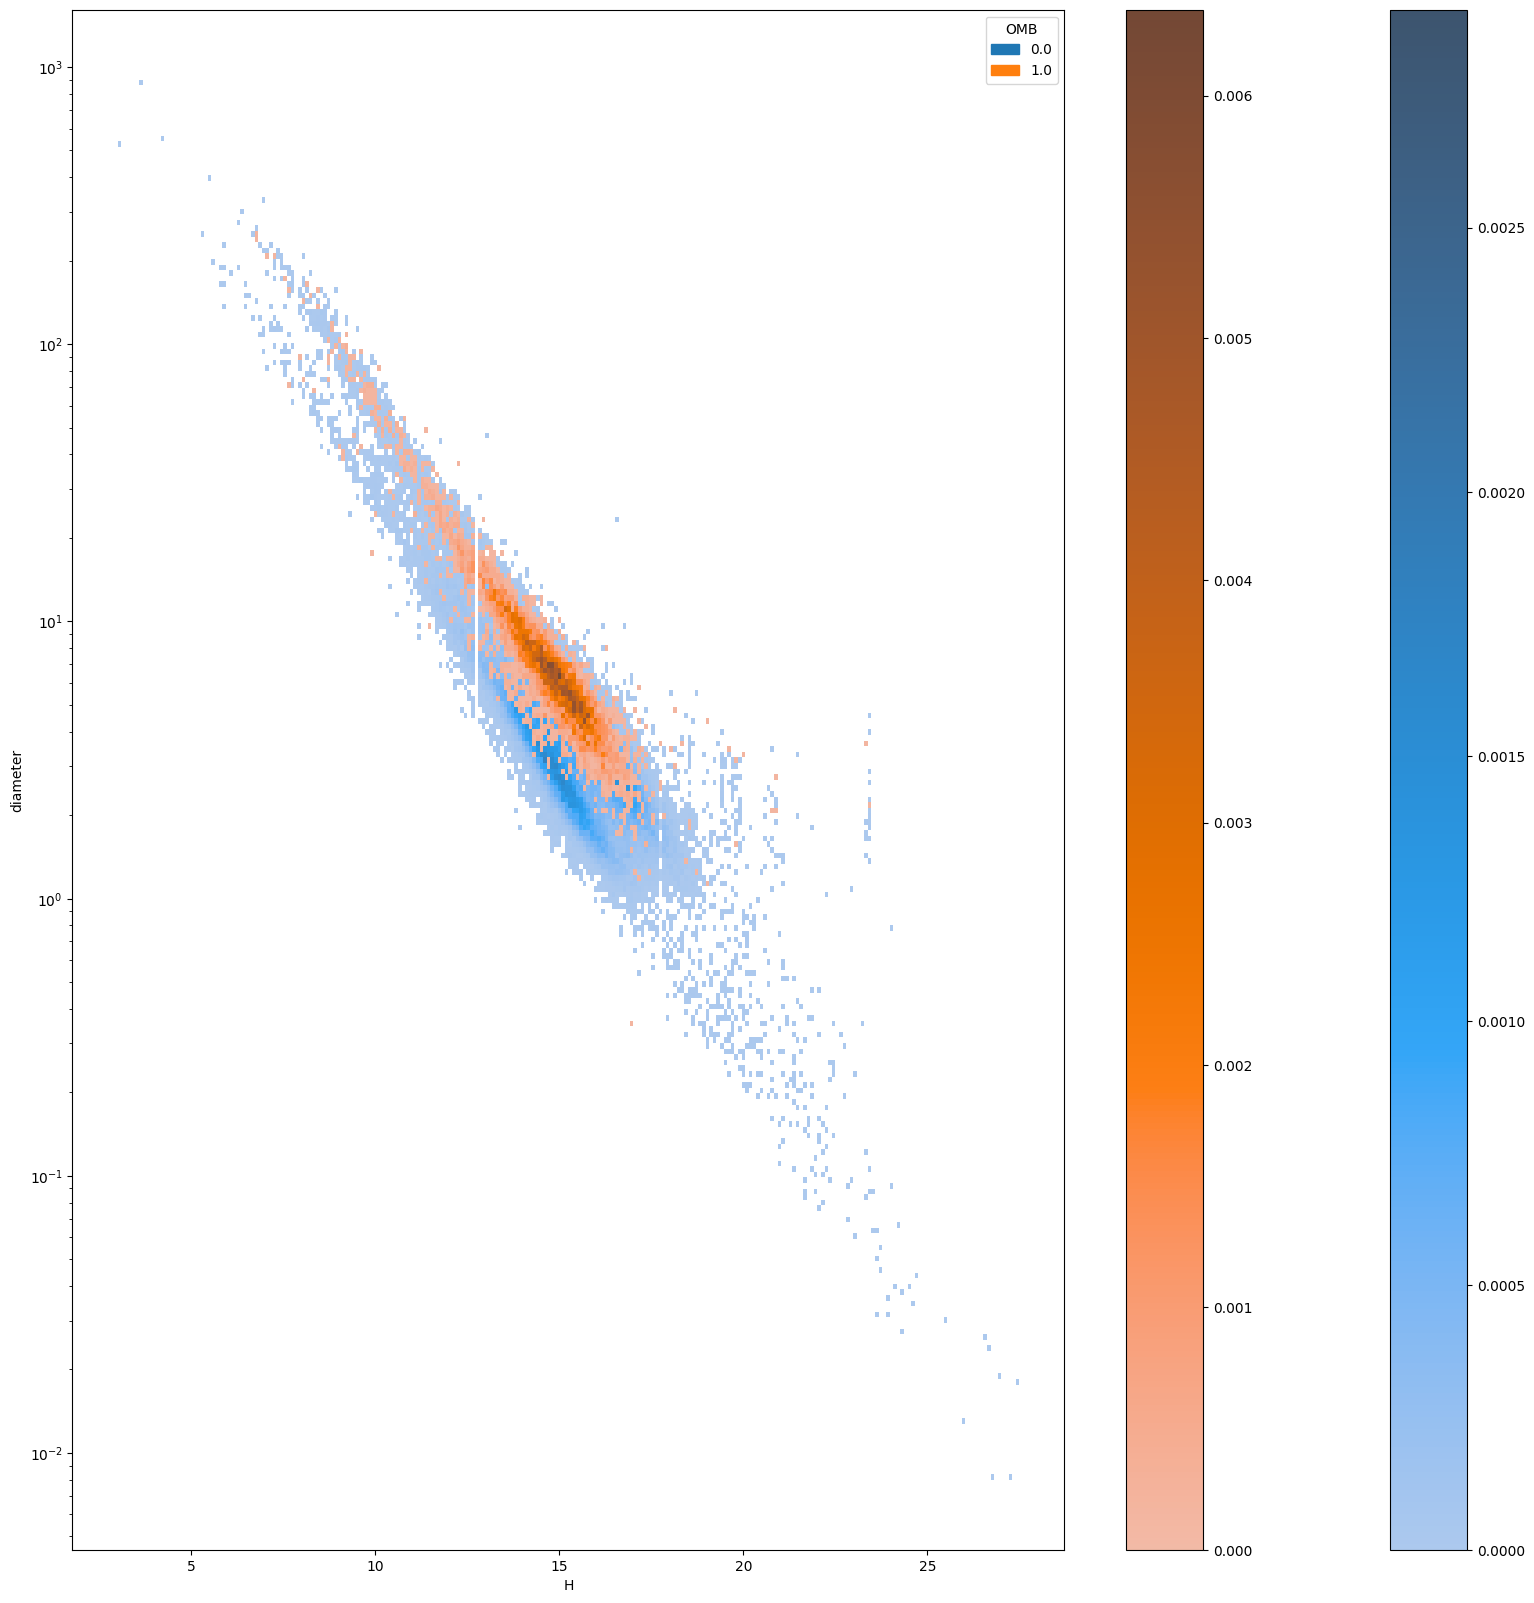

In [29]:
# Visualise the 2D histplot distributions:
sns.histplot(data = Train_Dataset, x = "H", y = "diameter", stat = "proportion", hue = "OMB", common_norm = False, log_scale = (False, True), cbar = True, bins = 250)

<Axes: xlabel='H', ylabel='diameter'>

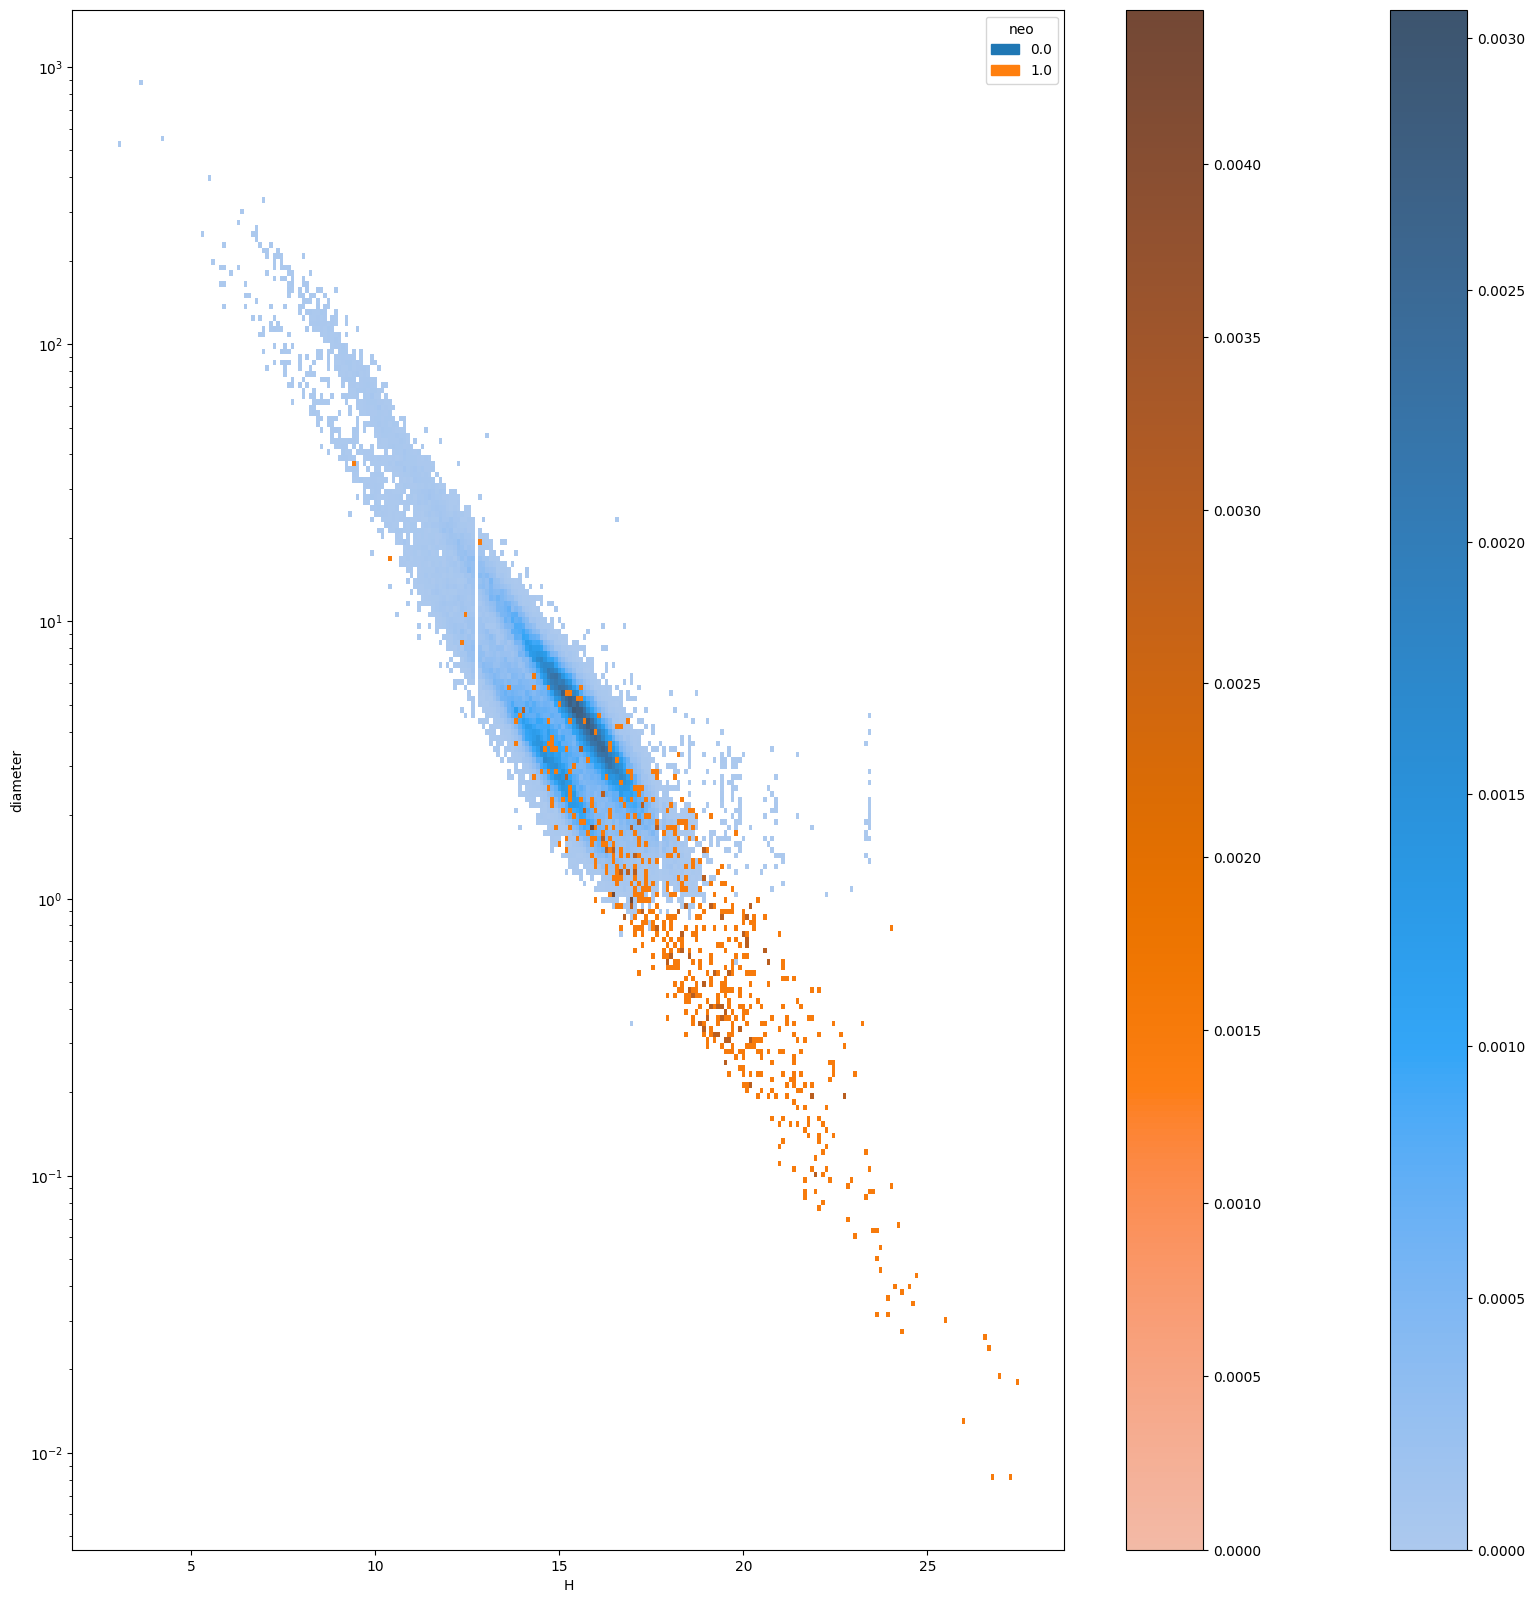

In [30]:
# Visualise the 2D histplot distributions:
sns.histplot(data = Train_Dataset, x = "H", y = "diameter", stat = "proportion", hue = "neo", common_norm = False, log_scale = (False, True), cbar = True, bins = 250)

<Axes: xlabel='H', ylabel='diameter'>

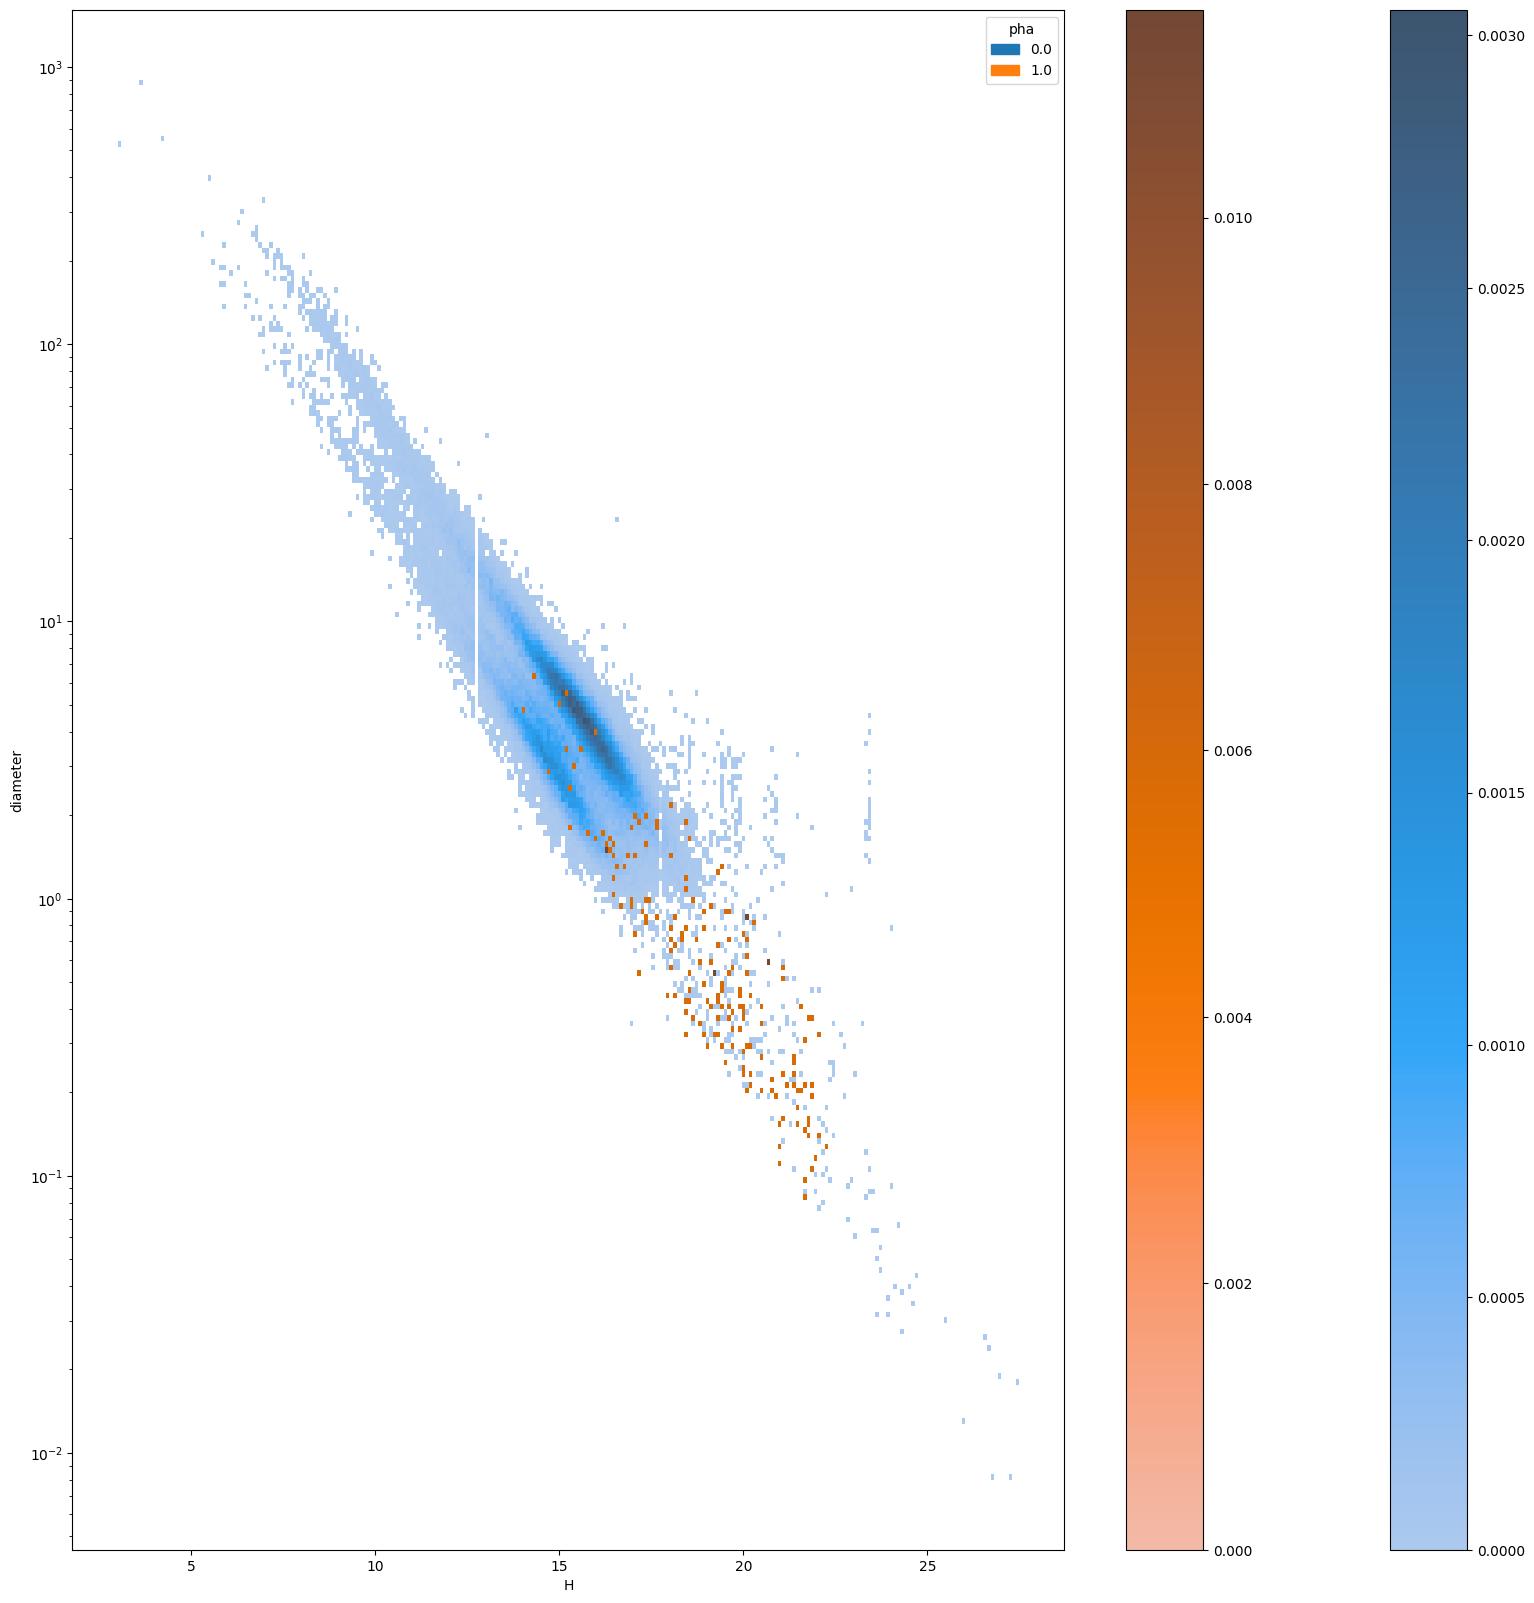

In [31]:
# Visualise the 2D histplot distributions:
sns.histplot(data = Train_Dataset, x = "H", y = "diameter", stat = "proportion", hue = "pha", common_norm = False, log_scale = (False, True), cbar = True, bins = 250)

<Axes: xlabel='albedo', ylabel='diameter'>

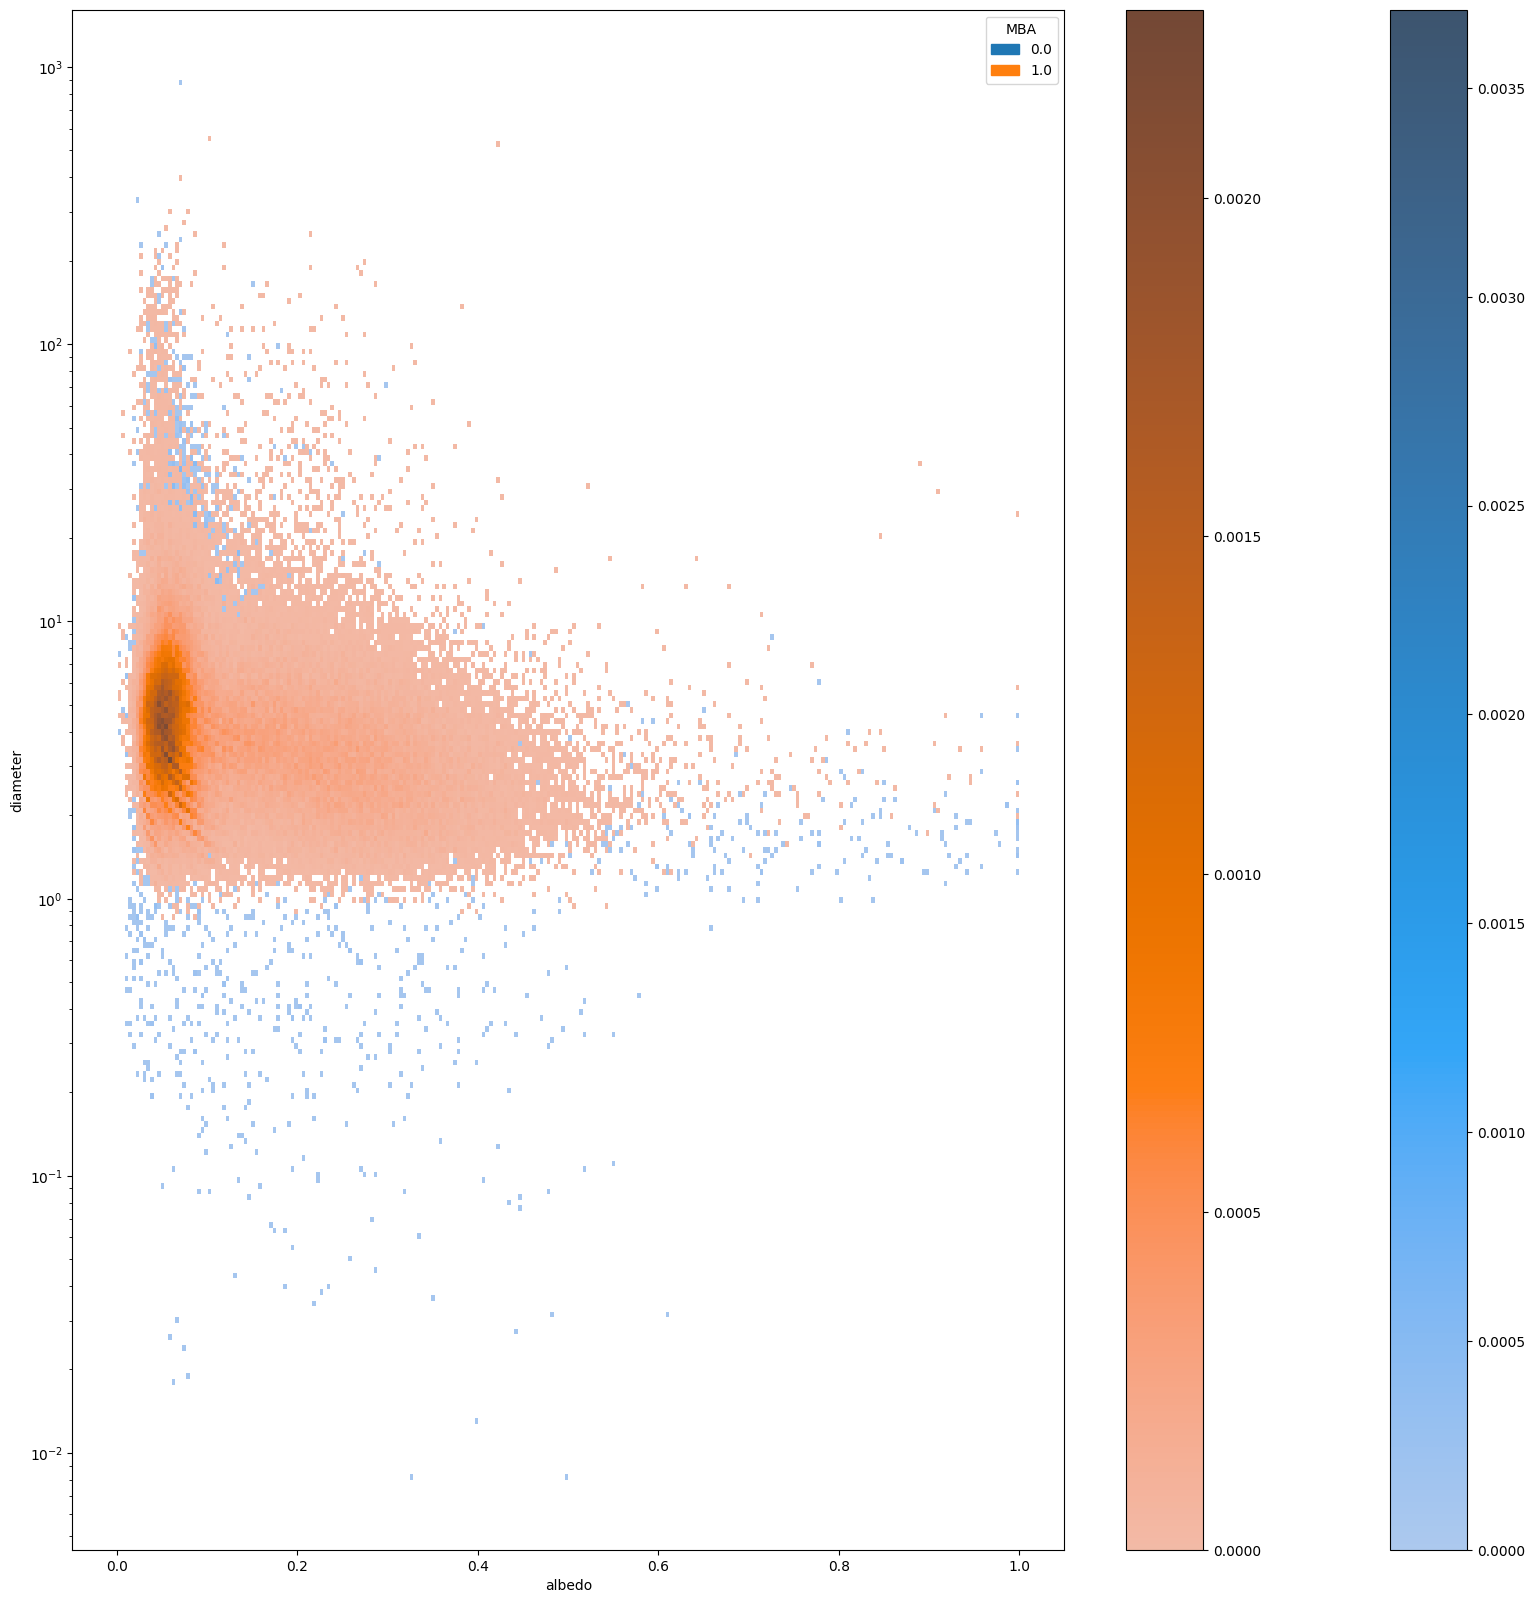

In [32]:
# Visualise the 2D histplot distributions:
sns.histplot(data = Train_Dataset, x = "albedo", y = "diameter", stat = "proportion", hue = "MBA", common_norm = False, log_scale = (False, True), cbar = True, bins = 250)

<Axes: xlabel='albedo', ylabel='diameter'>

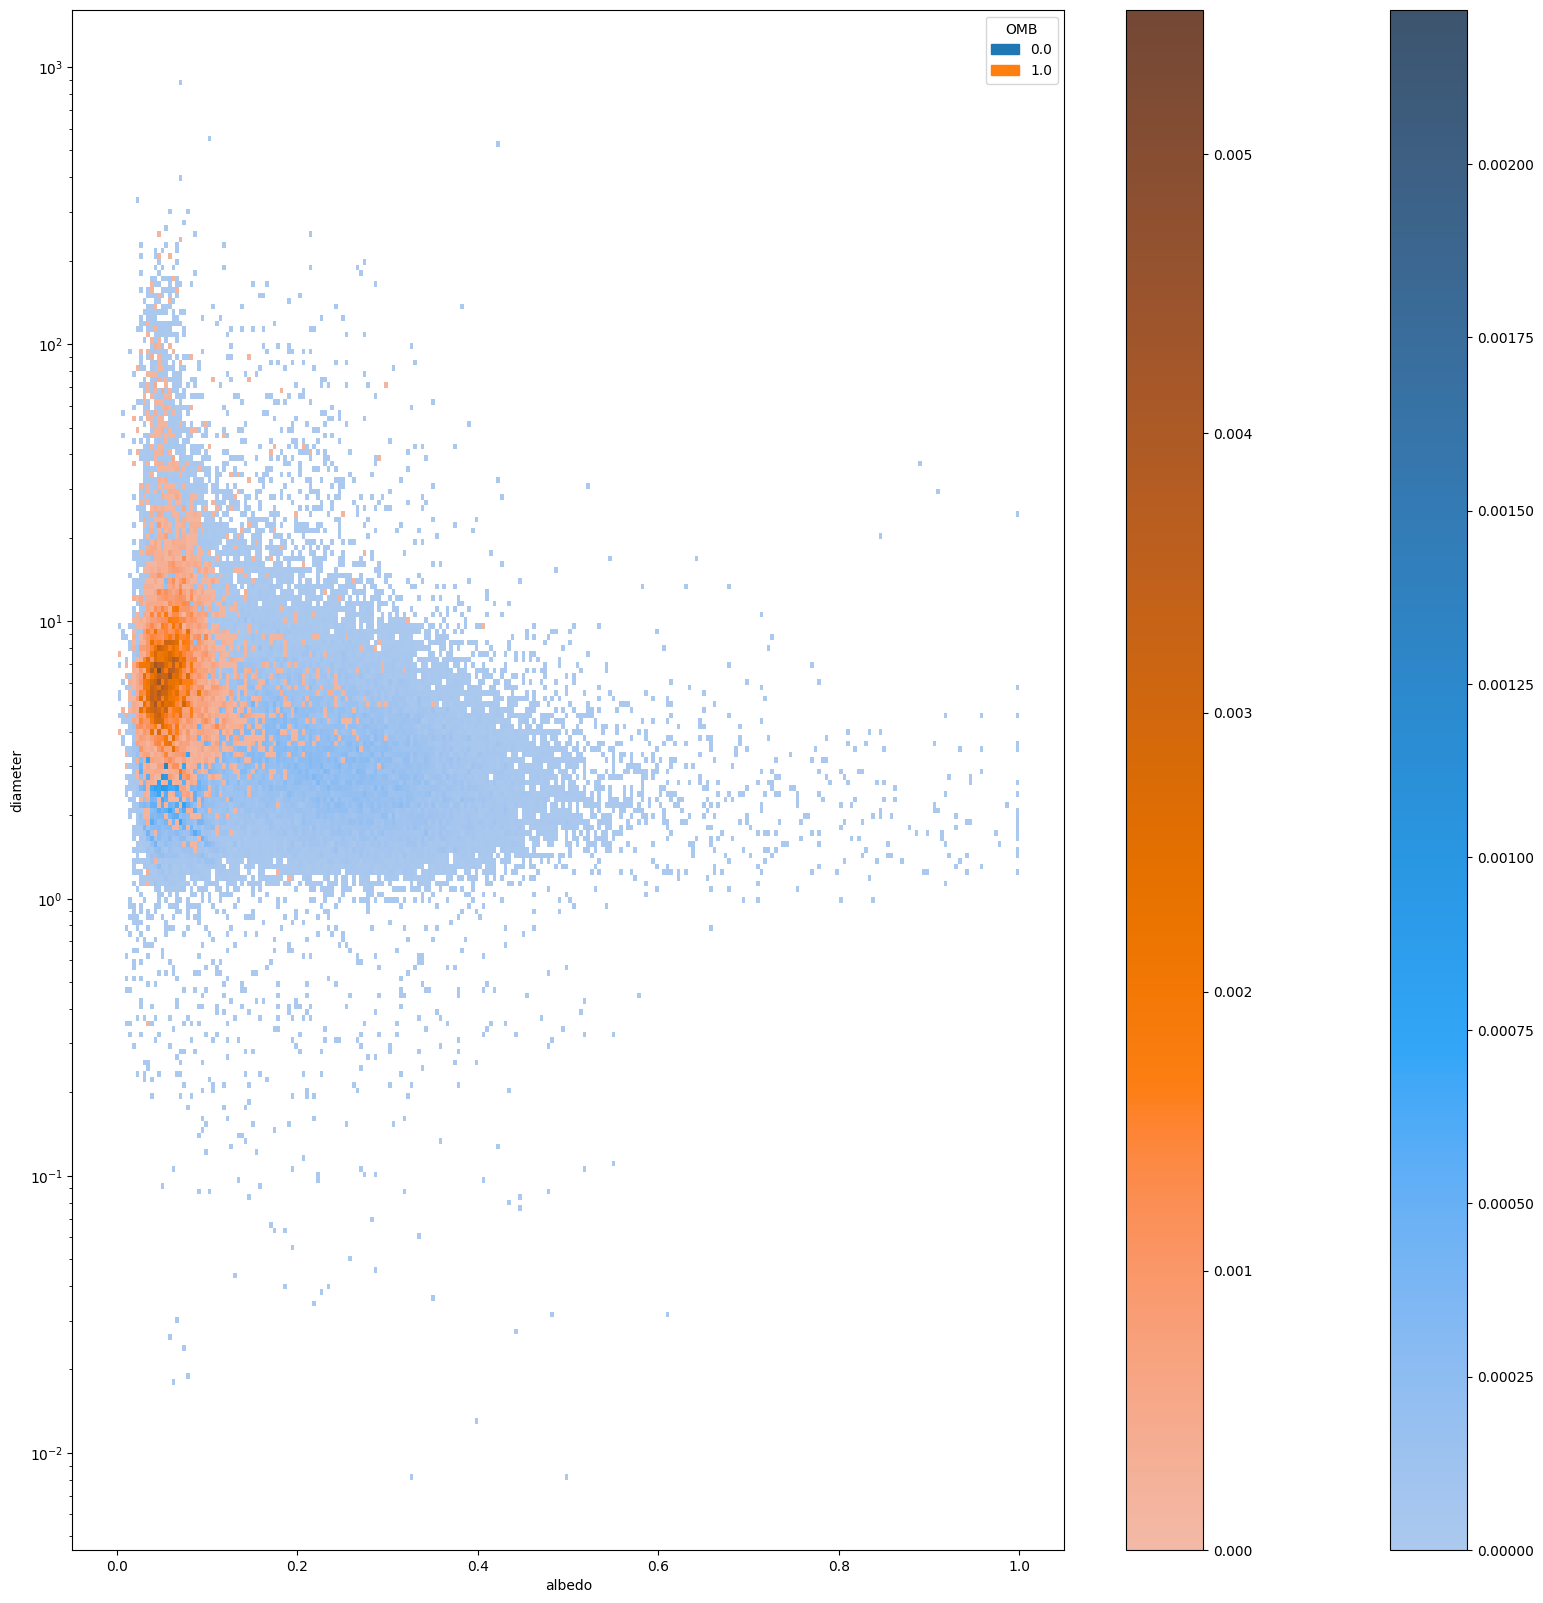

In [33]:
# Visualise the 2D histplot distributions:
sns.histplot(data = Train_Dataset, x = "albedo", y = "diameter", stat = "proportion", hue = "OMB",common_norm = False, log_scale = (False, True), cbar = True, bins = 250)

<Axes: xlabel='H', ylabel='e'>

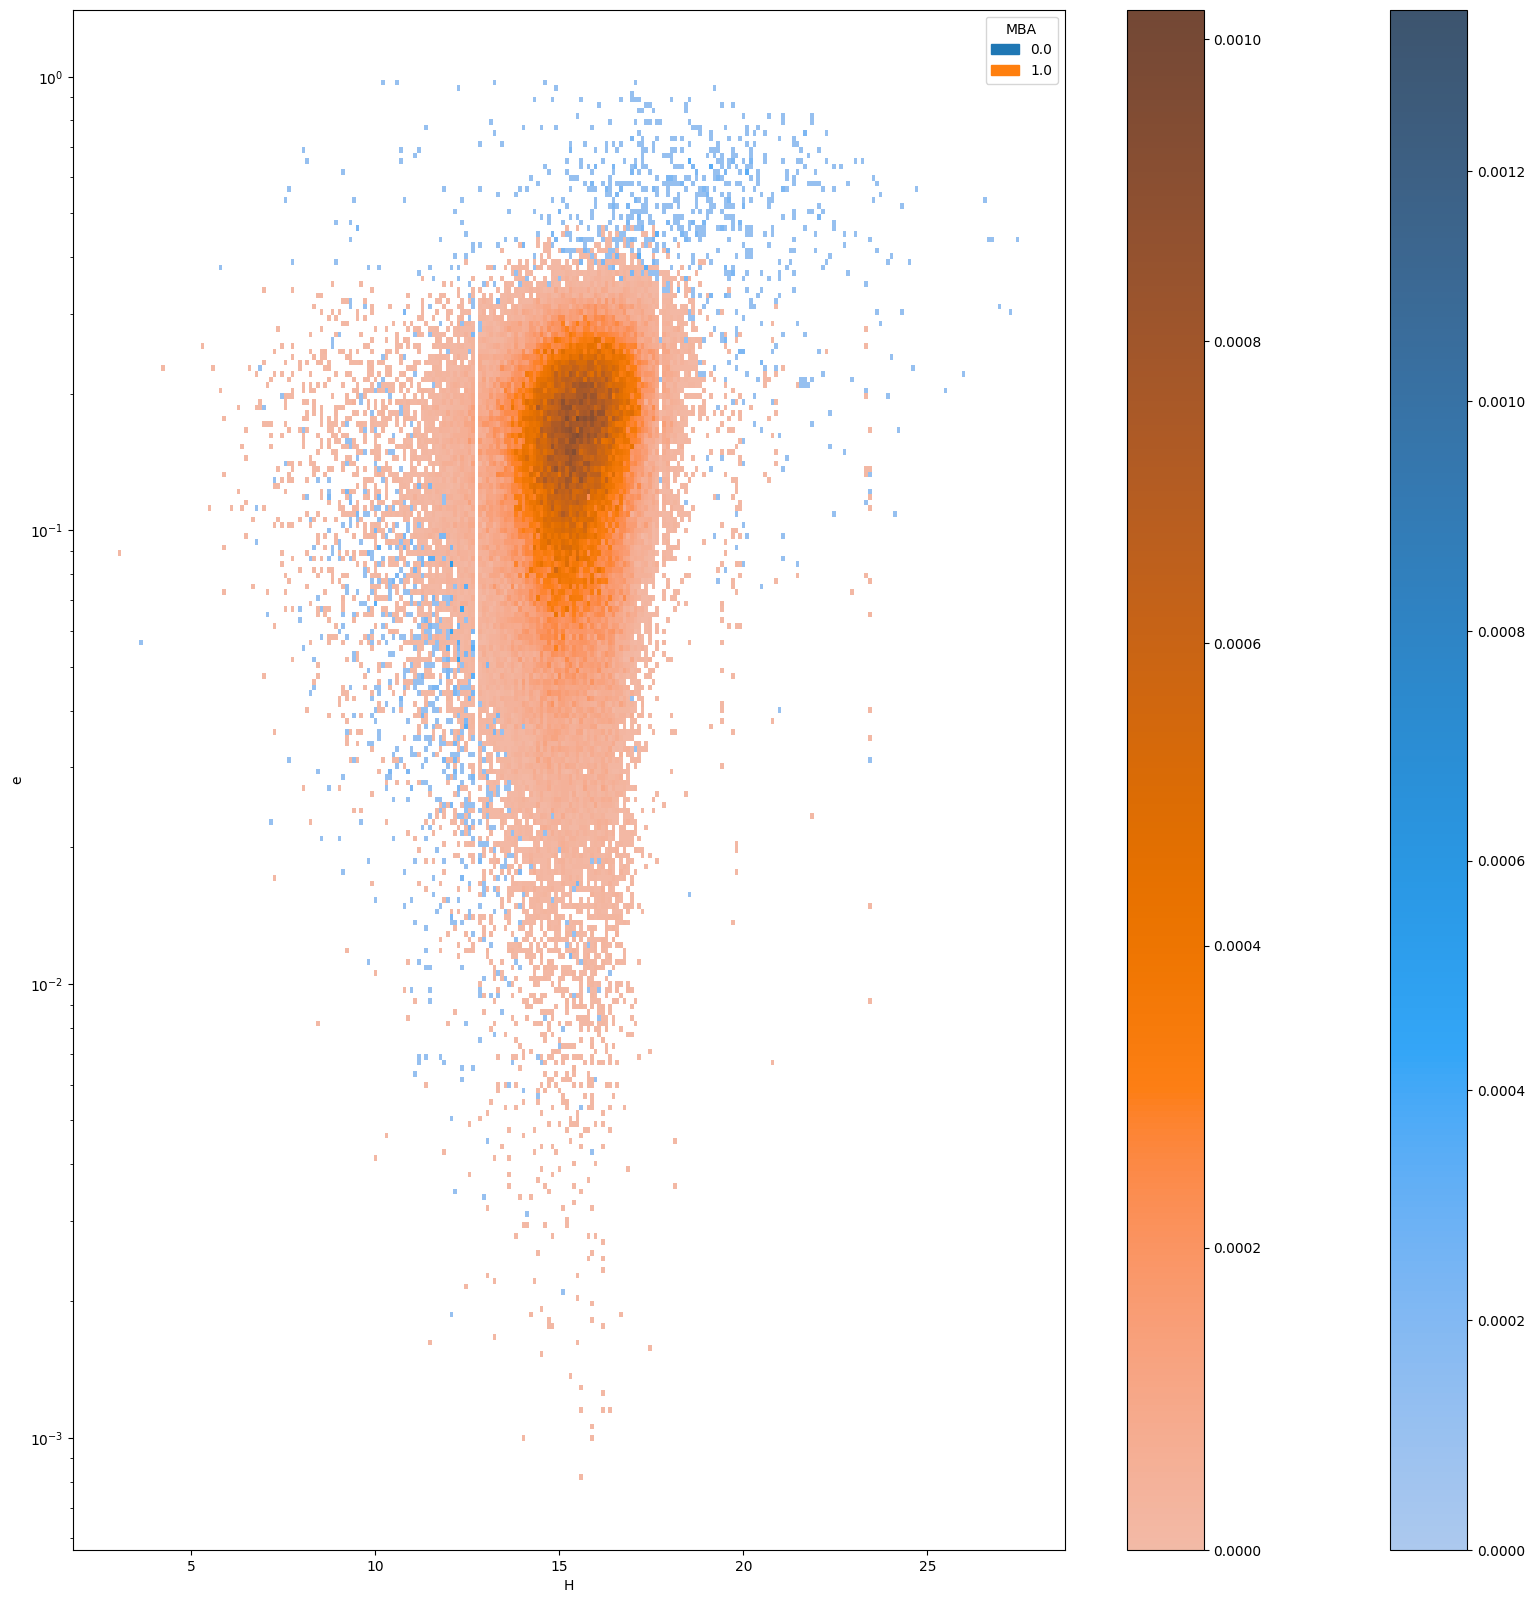

In [34]:
# Visualise the 2D histplot distributions:
sns.histplot(data = Train_Dataset, x = "H", y = "e", stat = "proportion", hue = "MBA", common_norm = False, log_scale = (False, True), cbar = True, bins = 250)

<Axes: xlabel='H', ylabel='e'>

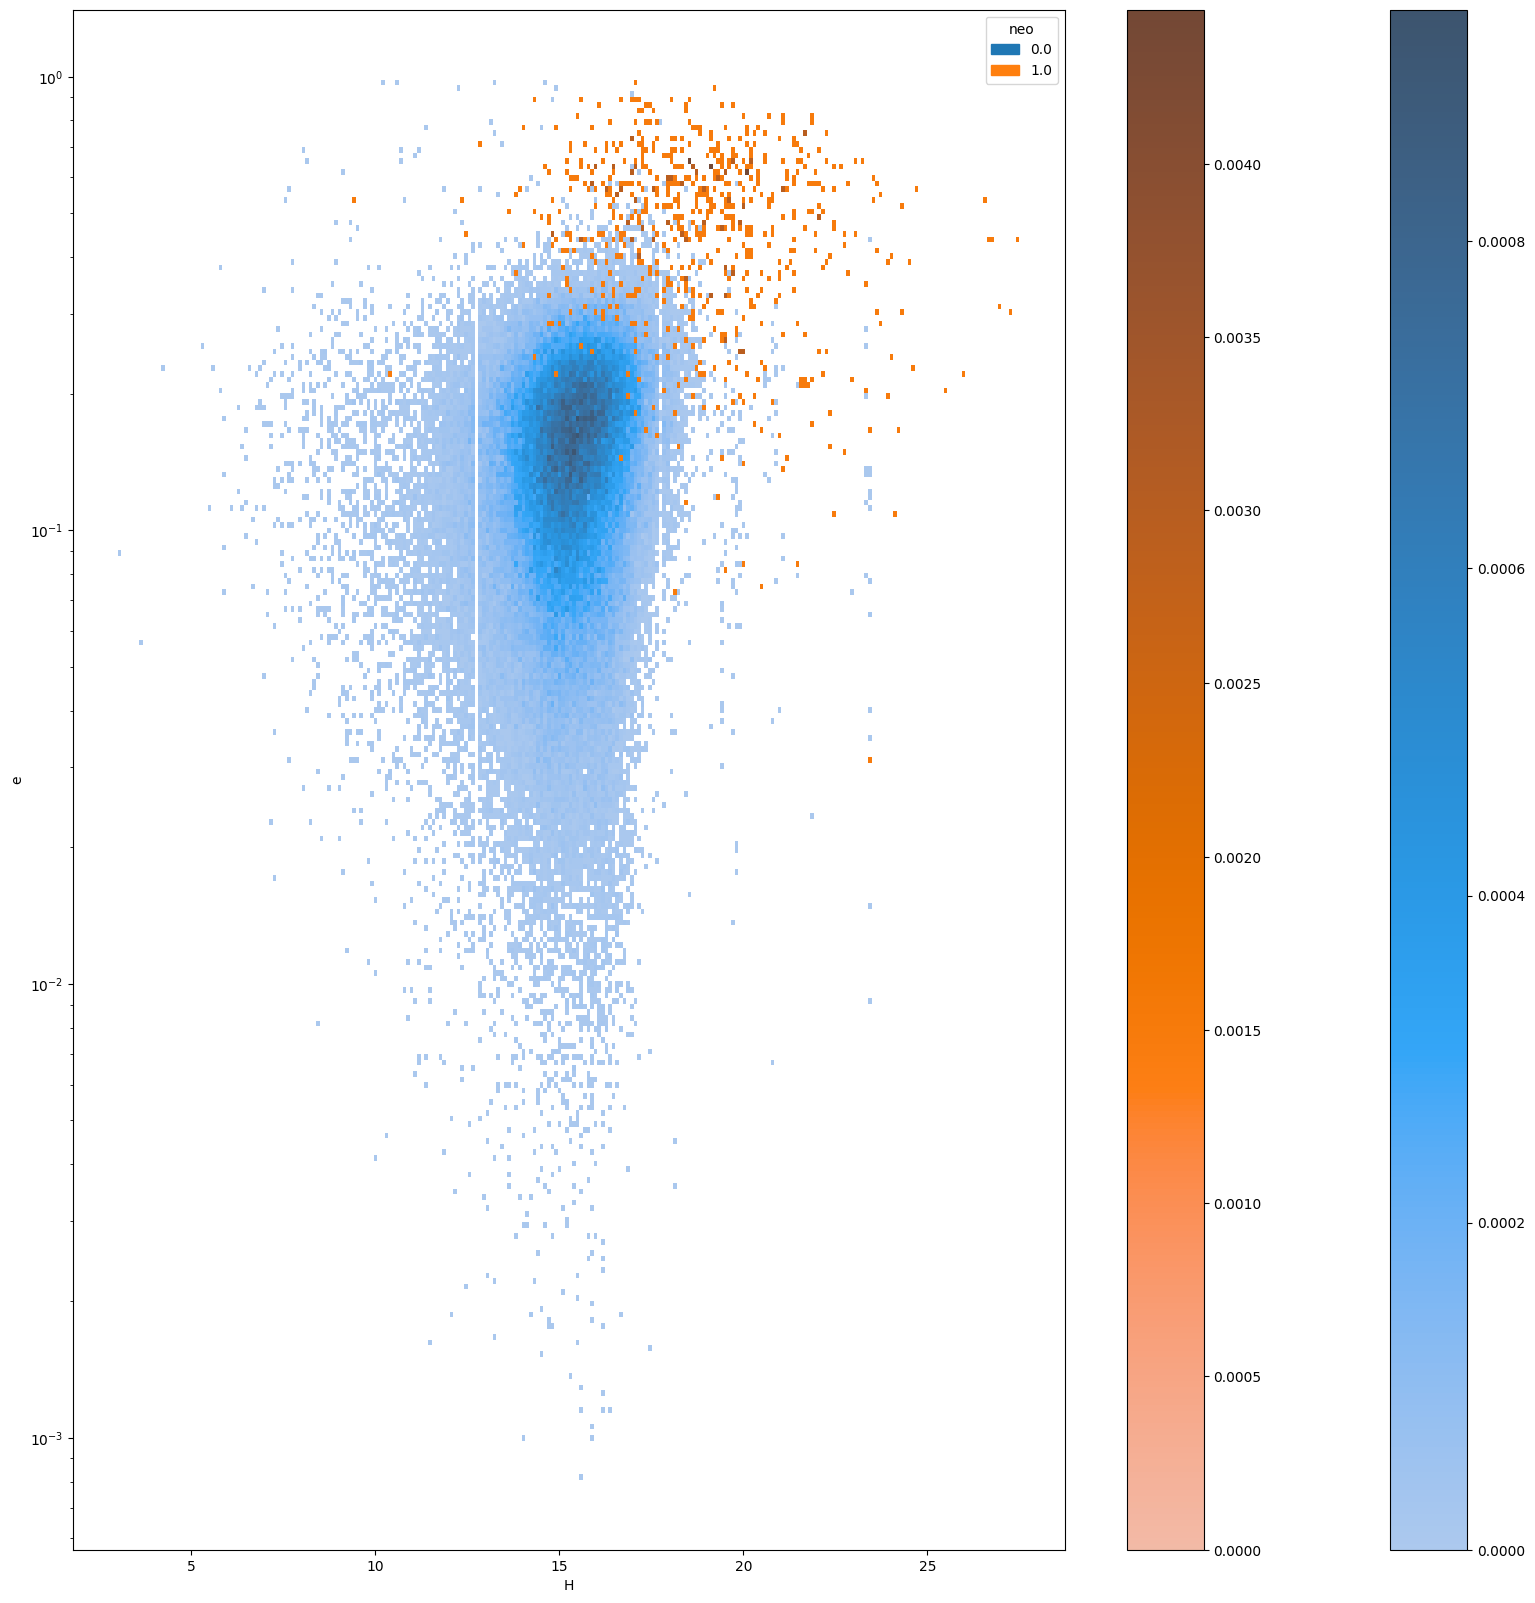

In [35]:
# Visualise the 2D histplot distributions:
sns.histplot(data = Train_Dataset, x = "H", y = "e", stat = "proportion", hue = "neo", common_norm = False, log_scale = (False, True), cbar = True, bins = 250)

In [36]:
# Add Discovered Logarithmically Varying Features:
Train_Dataset["Log_Diameter"] = np.log(np.maximum(Train_Dataset["diameter"], 1e-5))
Train_Dataset["log_e"] = np.log(np.maximum(Train_Dataset["e"], 1e-5))
Train_Dataset["log_q"] = np.log(np.maximum(Train_Dataset["q"], 1e-5))
Train_Dataset["log_n"] = np.log(np.maximum(Train_Dataset["n"], 1e-5))
Train_Dataset["log_moid"] = np.log(np.maximum(Train_Dataset["moid"], 1e-5))

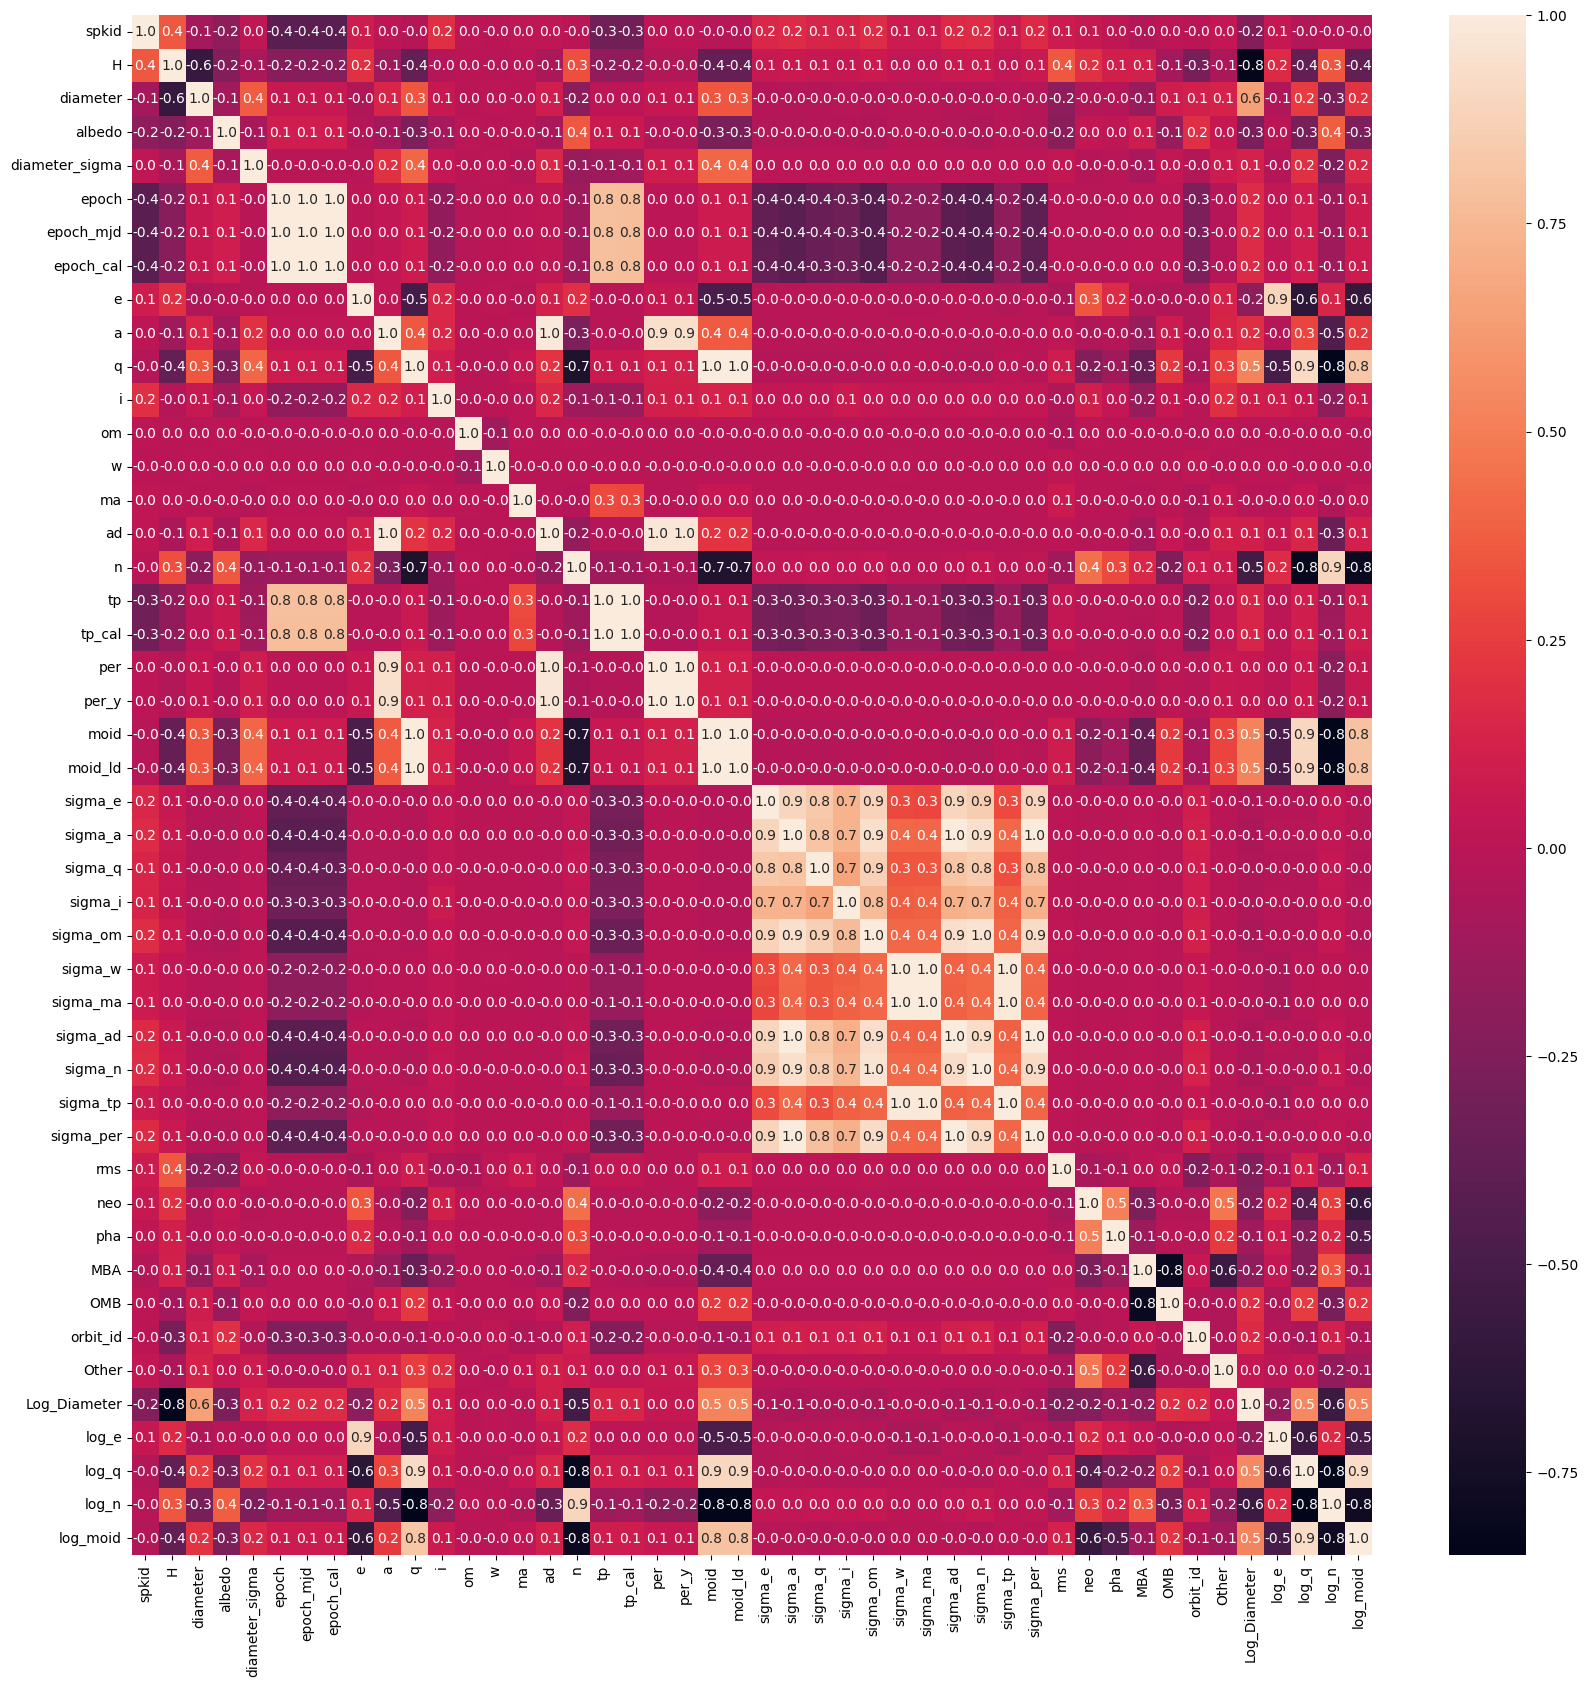

In [37]:
# Compute The Correlation_Matrix, check for multicollinarity and potential explanatory variables
sns.heatmap(Train_Dataset.corr(), annot = True, fmt = ".1f") # Suggests low to medium multicollinerity especially with uncertainties! PCA needed
plt.show()

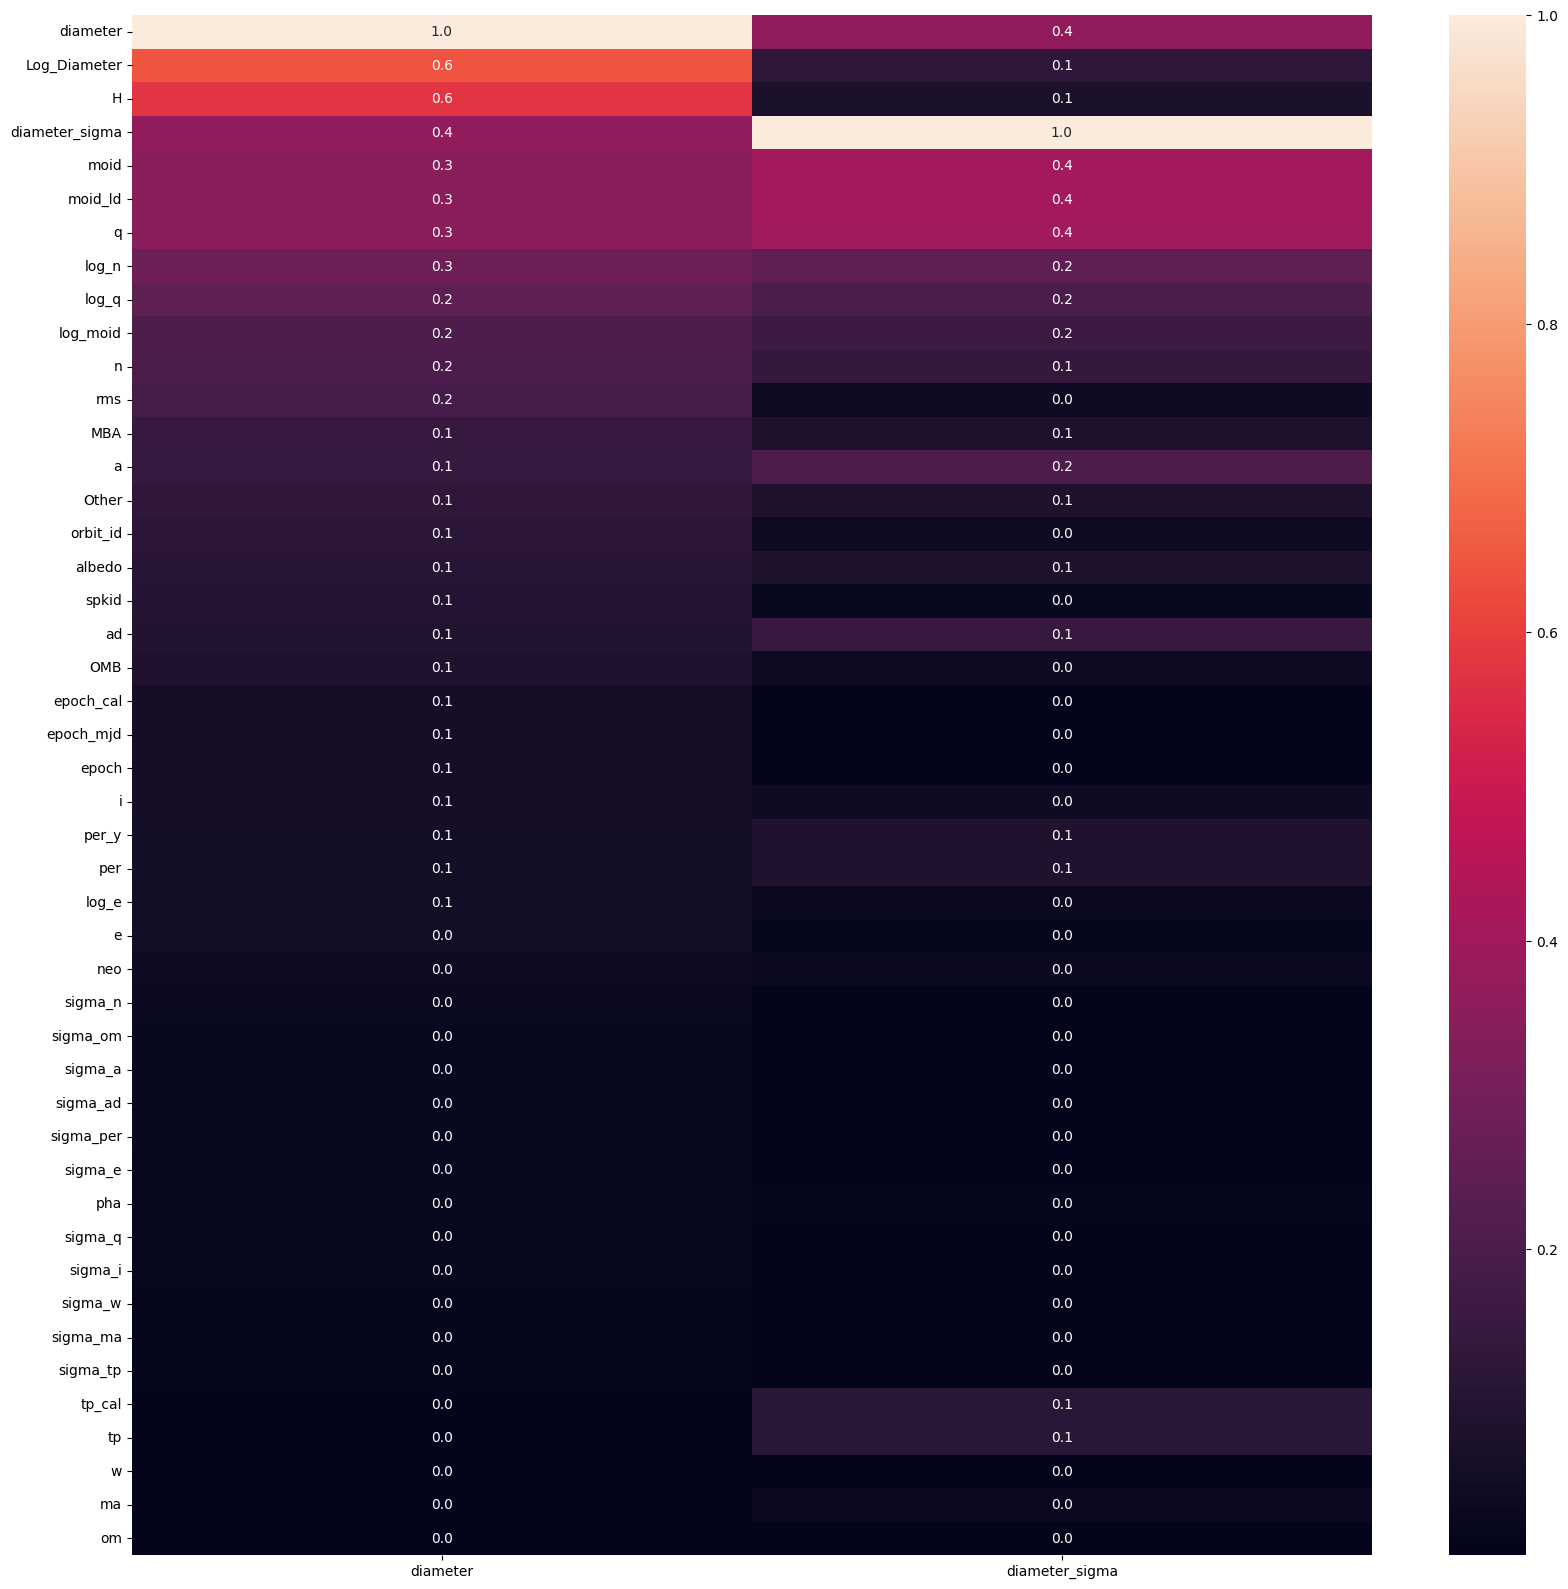

In [38]:
# Compute The Correlation_Matrix for targets
sns.heatmap(np.abs(Train_Dataset.corr()).sort_values(by = "diameter", ascending = False).loc[:,Regression_Targets], annot = True, fmt = ".1f") # Absolute Magnitude Strongest Indicator of Diameter
plt.show()

In [39]:
# Create a Mask for the Classification_Tasks
Boolean_Mask = []
for column_name in Train_Dataset.columns:
    if column_name in Classification_Targets:
        Boolean_Mask.append(True)
    else:
        Boolean_Mask.append(False)

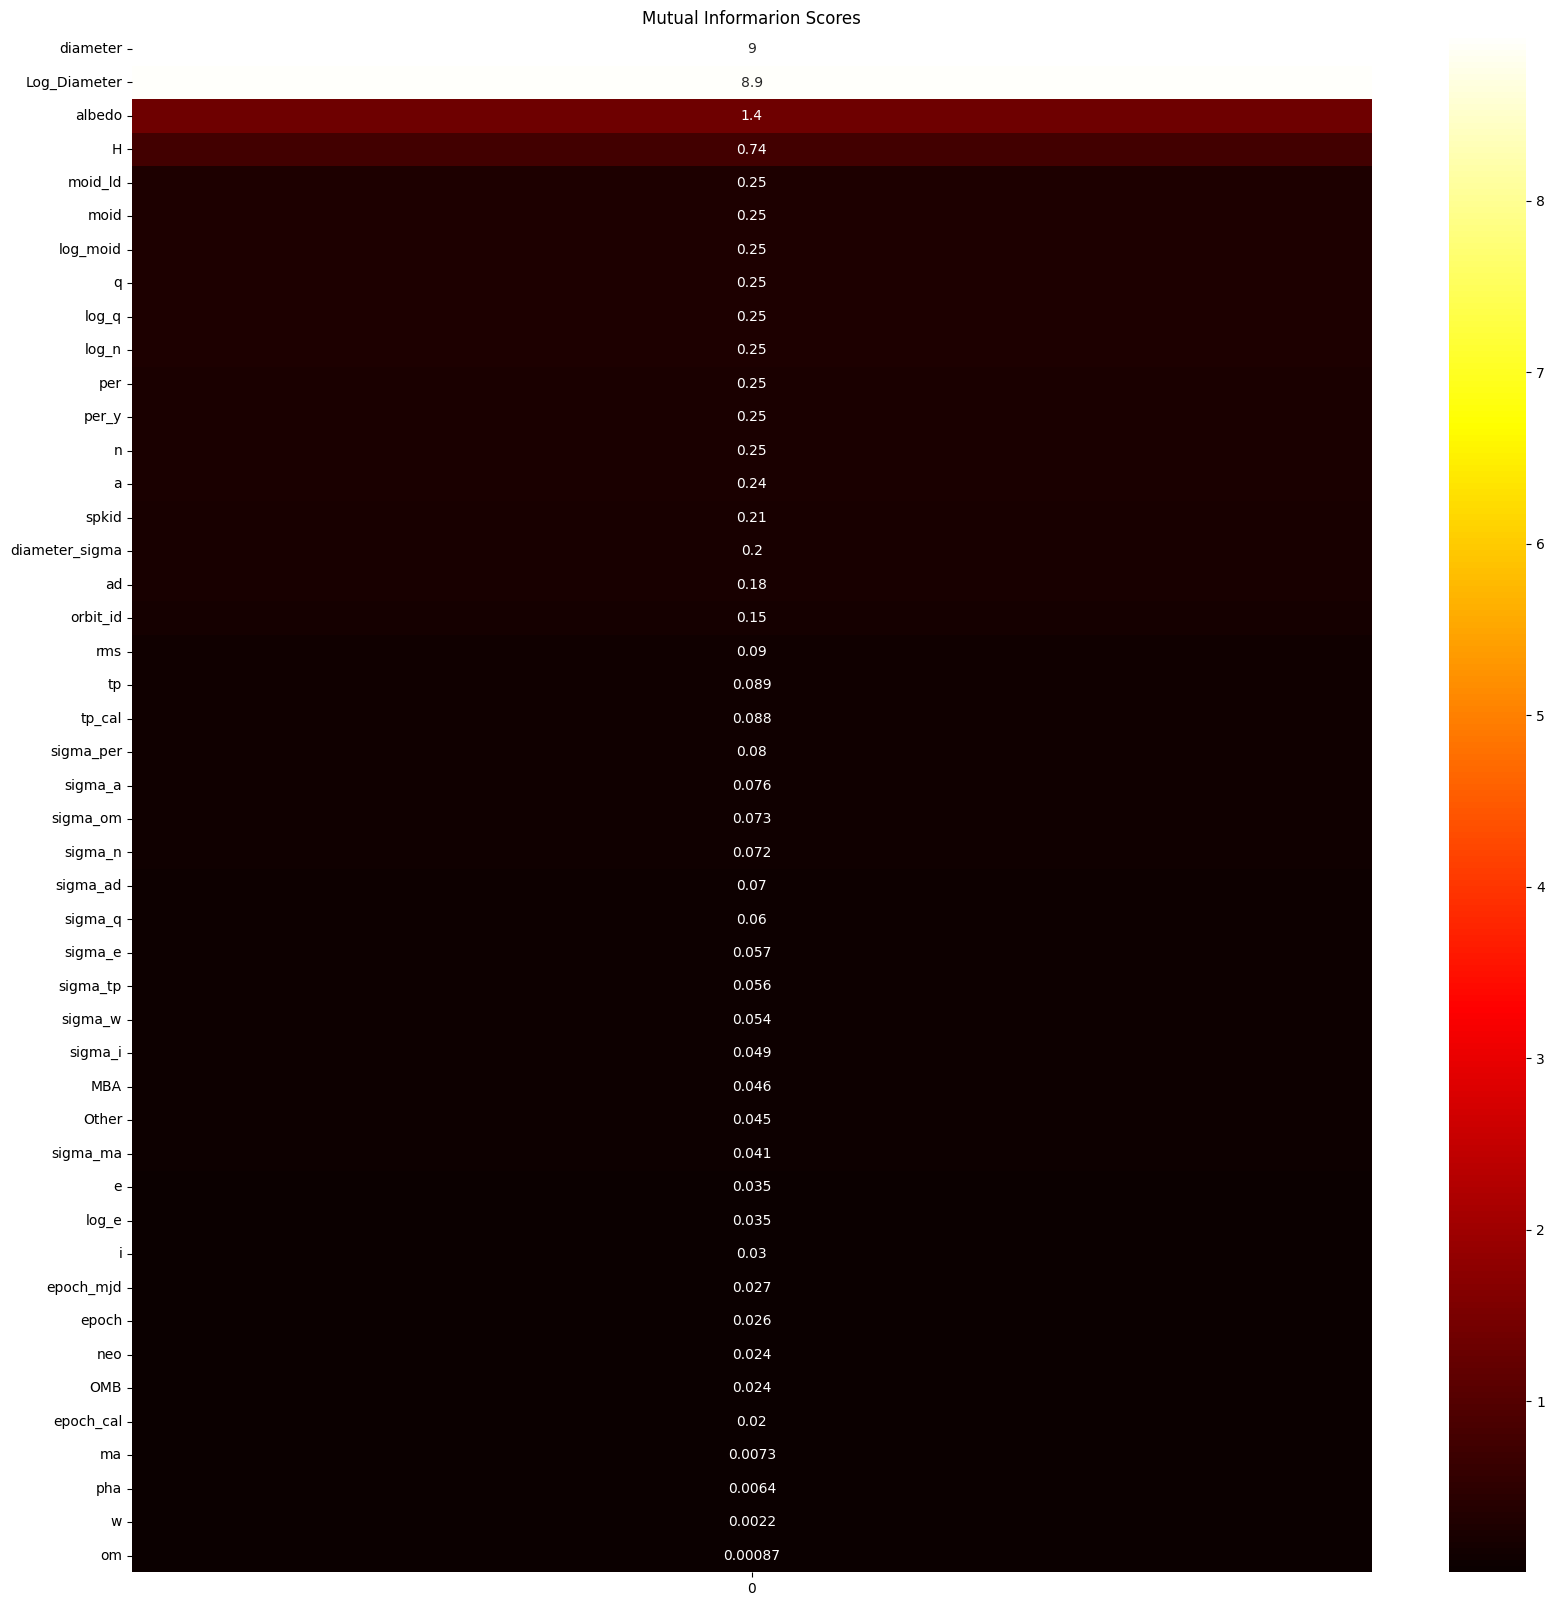

In [40]:
# Compute the Mutual Information Scores to reinforce conclusions:

# Regression
mutual_information_reg = make_mi_scores(Train_Dataset, Train_Dataset["diameter"], categoric_values = Boolean_Mask)
plot_mi_scores(mutual_information_reg, cmap = "hot")

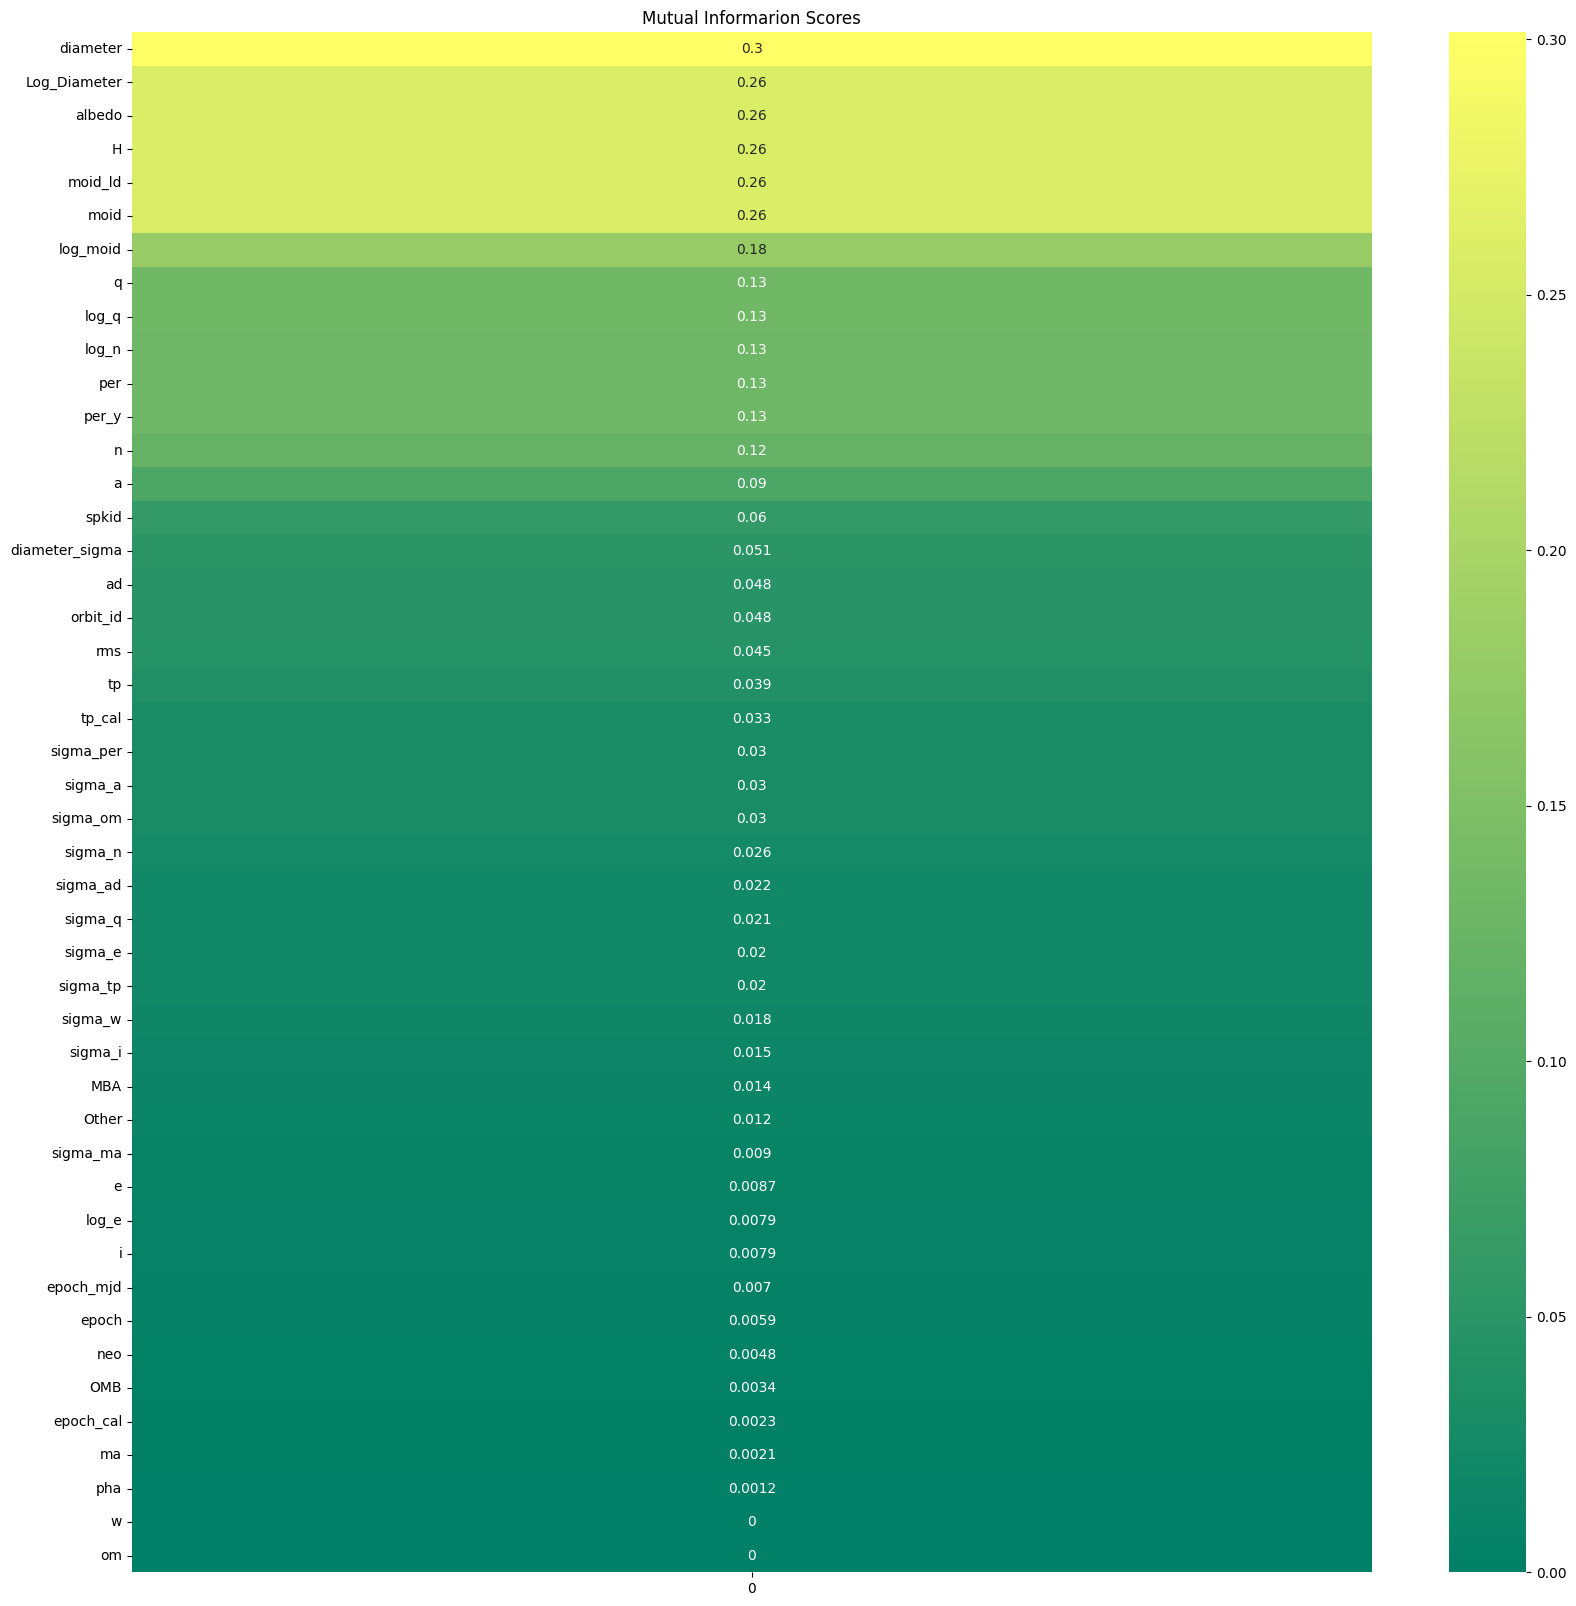

In [41]:
# Compute the Mutual __annotations__Information Scores to reinforce conclusions:

# Classification
mutual_information_cla = make_mi_scores(Train_Dataset, Train_Dataset["MBA"], categoric_values = Boolean_Mask)
plot_mi_scores(mutual_information_cla, cmap = "summer")

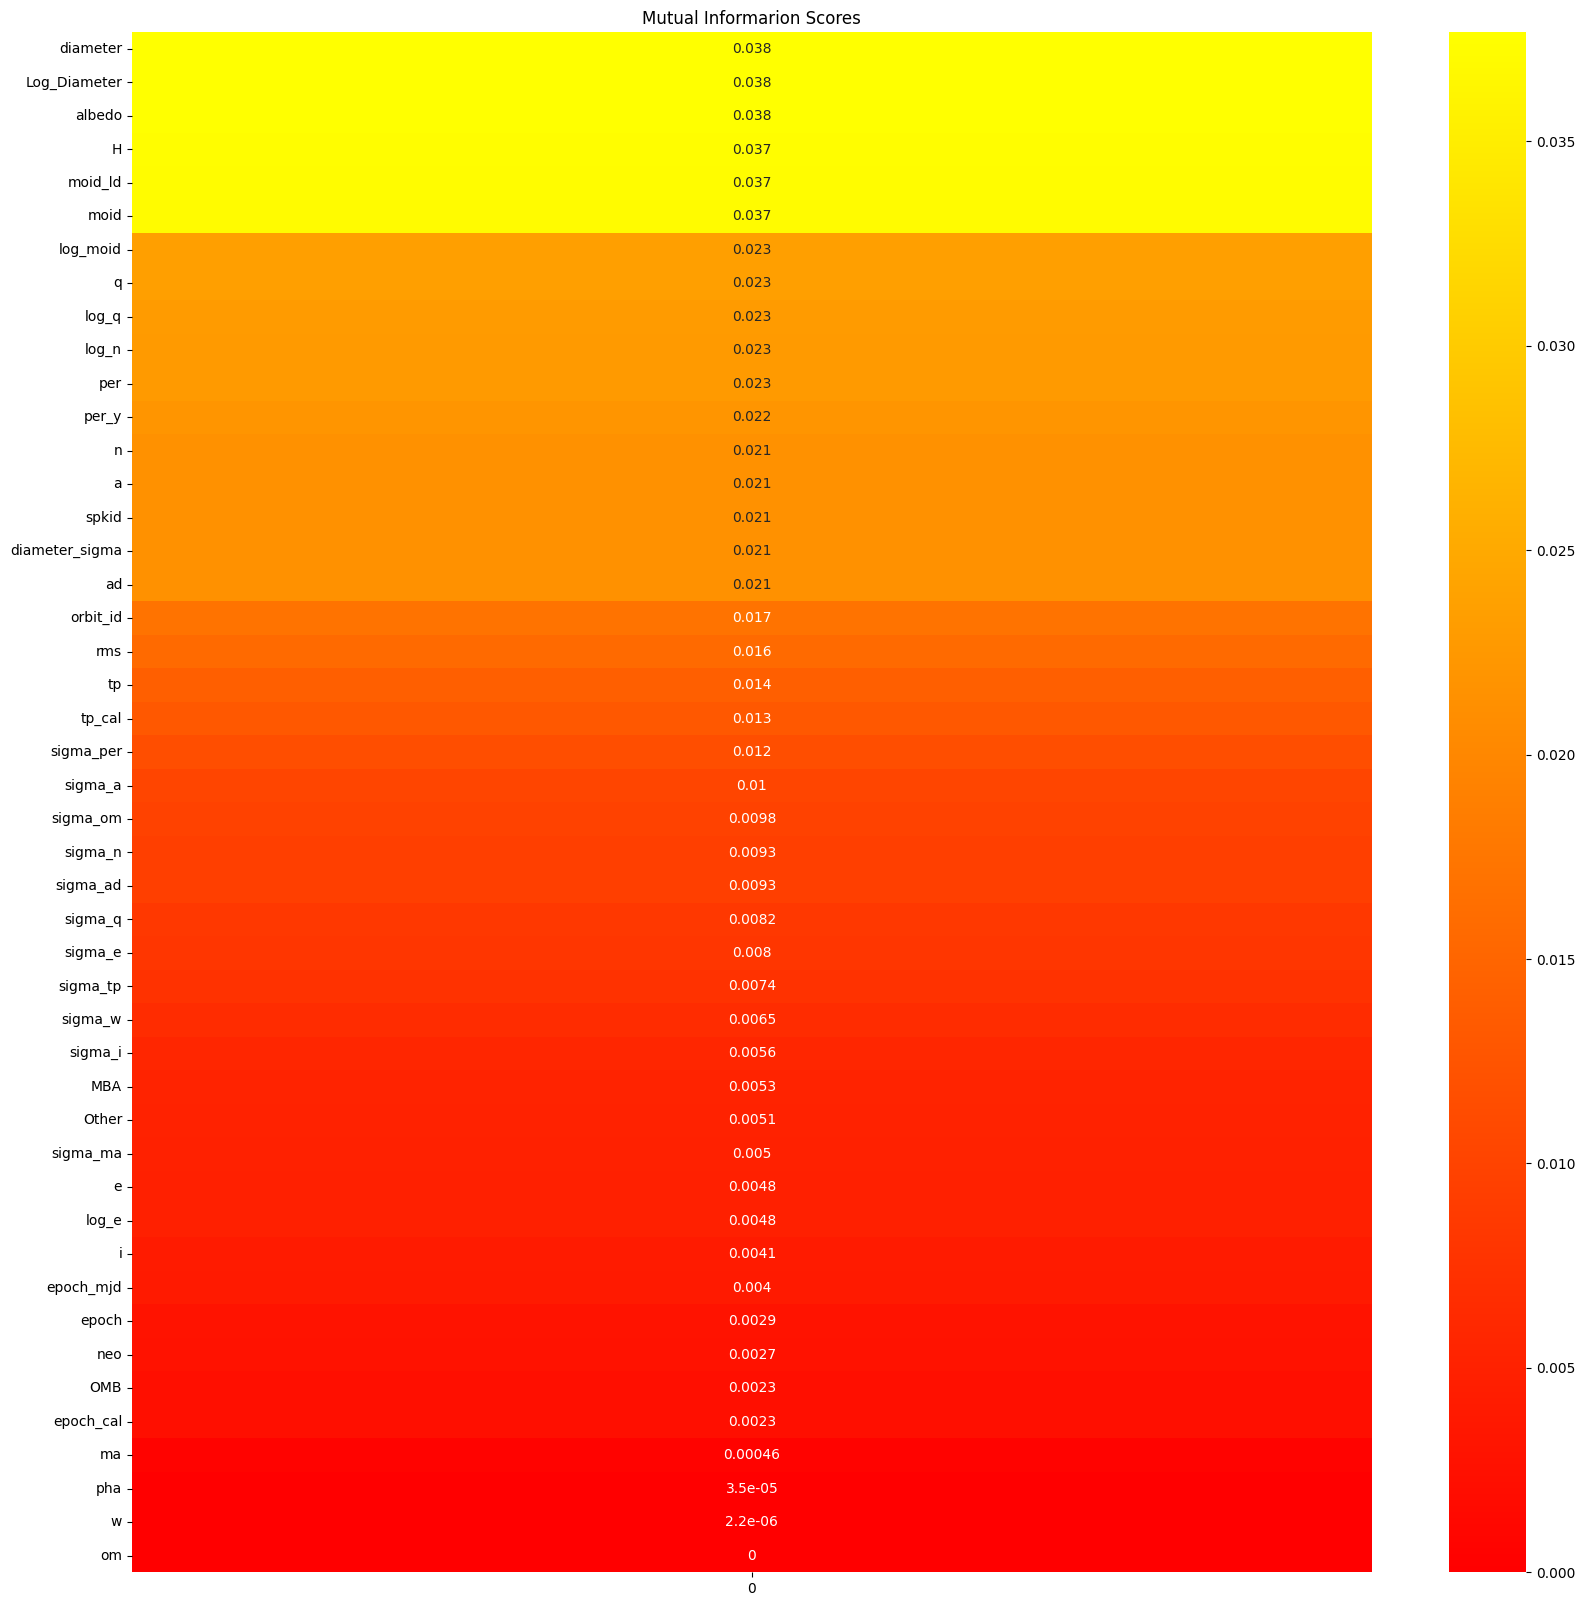

In [42]:
# Compute the Mutual Information Scores to reinforce conclusions:

# Classification
mutual_information_cla = make_mi_scores(Train_Dataset, Train_Dataset["neo"], categoric_values = Boolean_Mask)
plot_mi_scores(mutual_information_cla, cmap = "autumn")

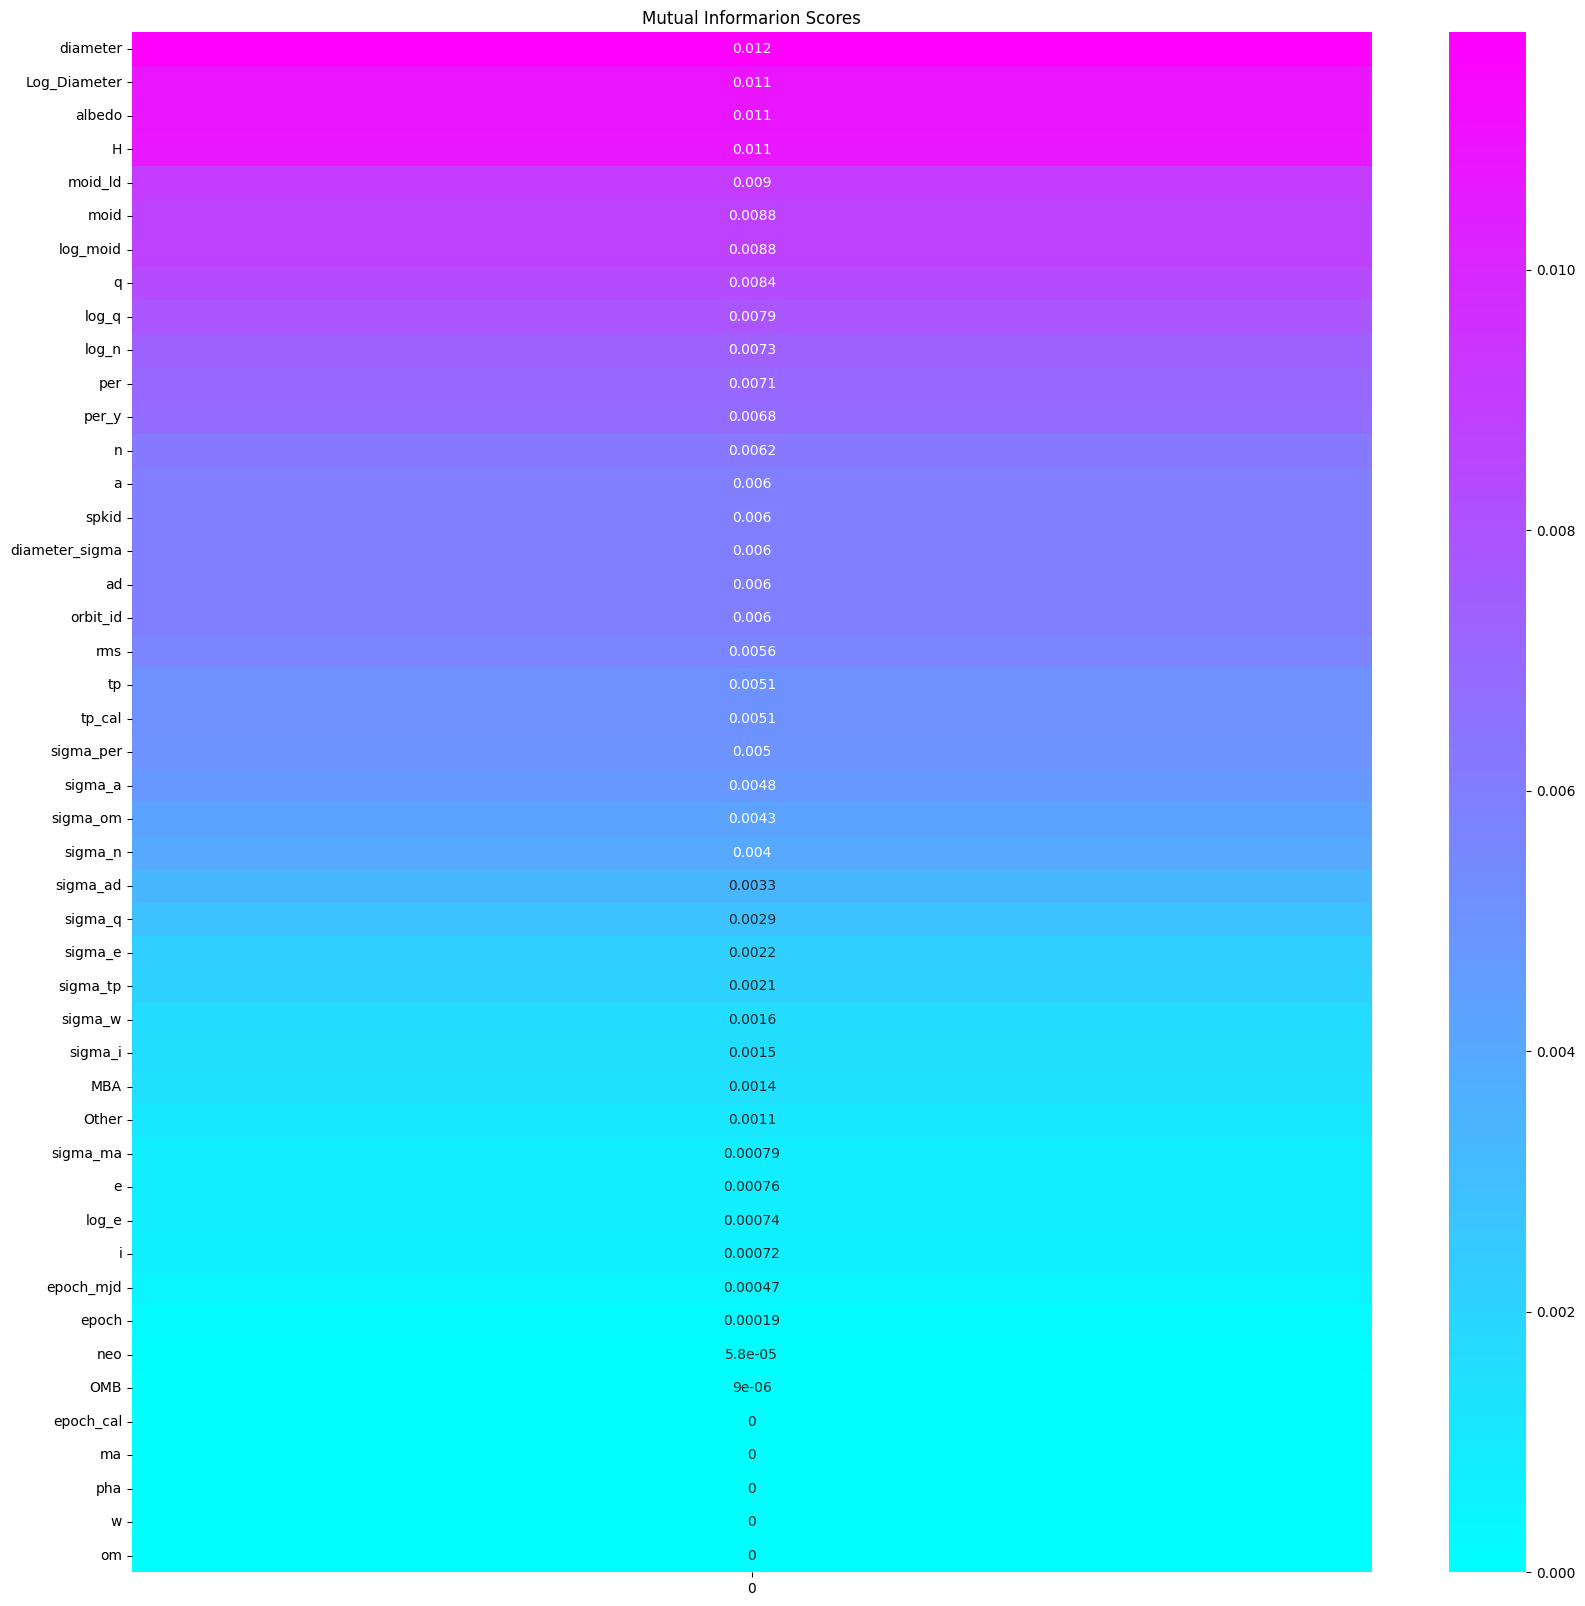

In [43]:
# Compute the Mutual Information Scores to reinforce conclusions:

# Classification
mutual_information_cla = make_mi_scores(Train_Dataset, Train_Dataset["pha"], categoric_values = Boolean_Mask)
plot_mi_scores(mutual_information_cla, cmap = "cool")

<Axes: >

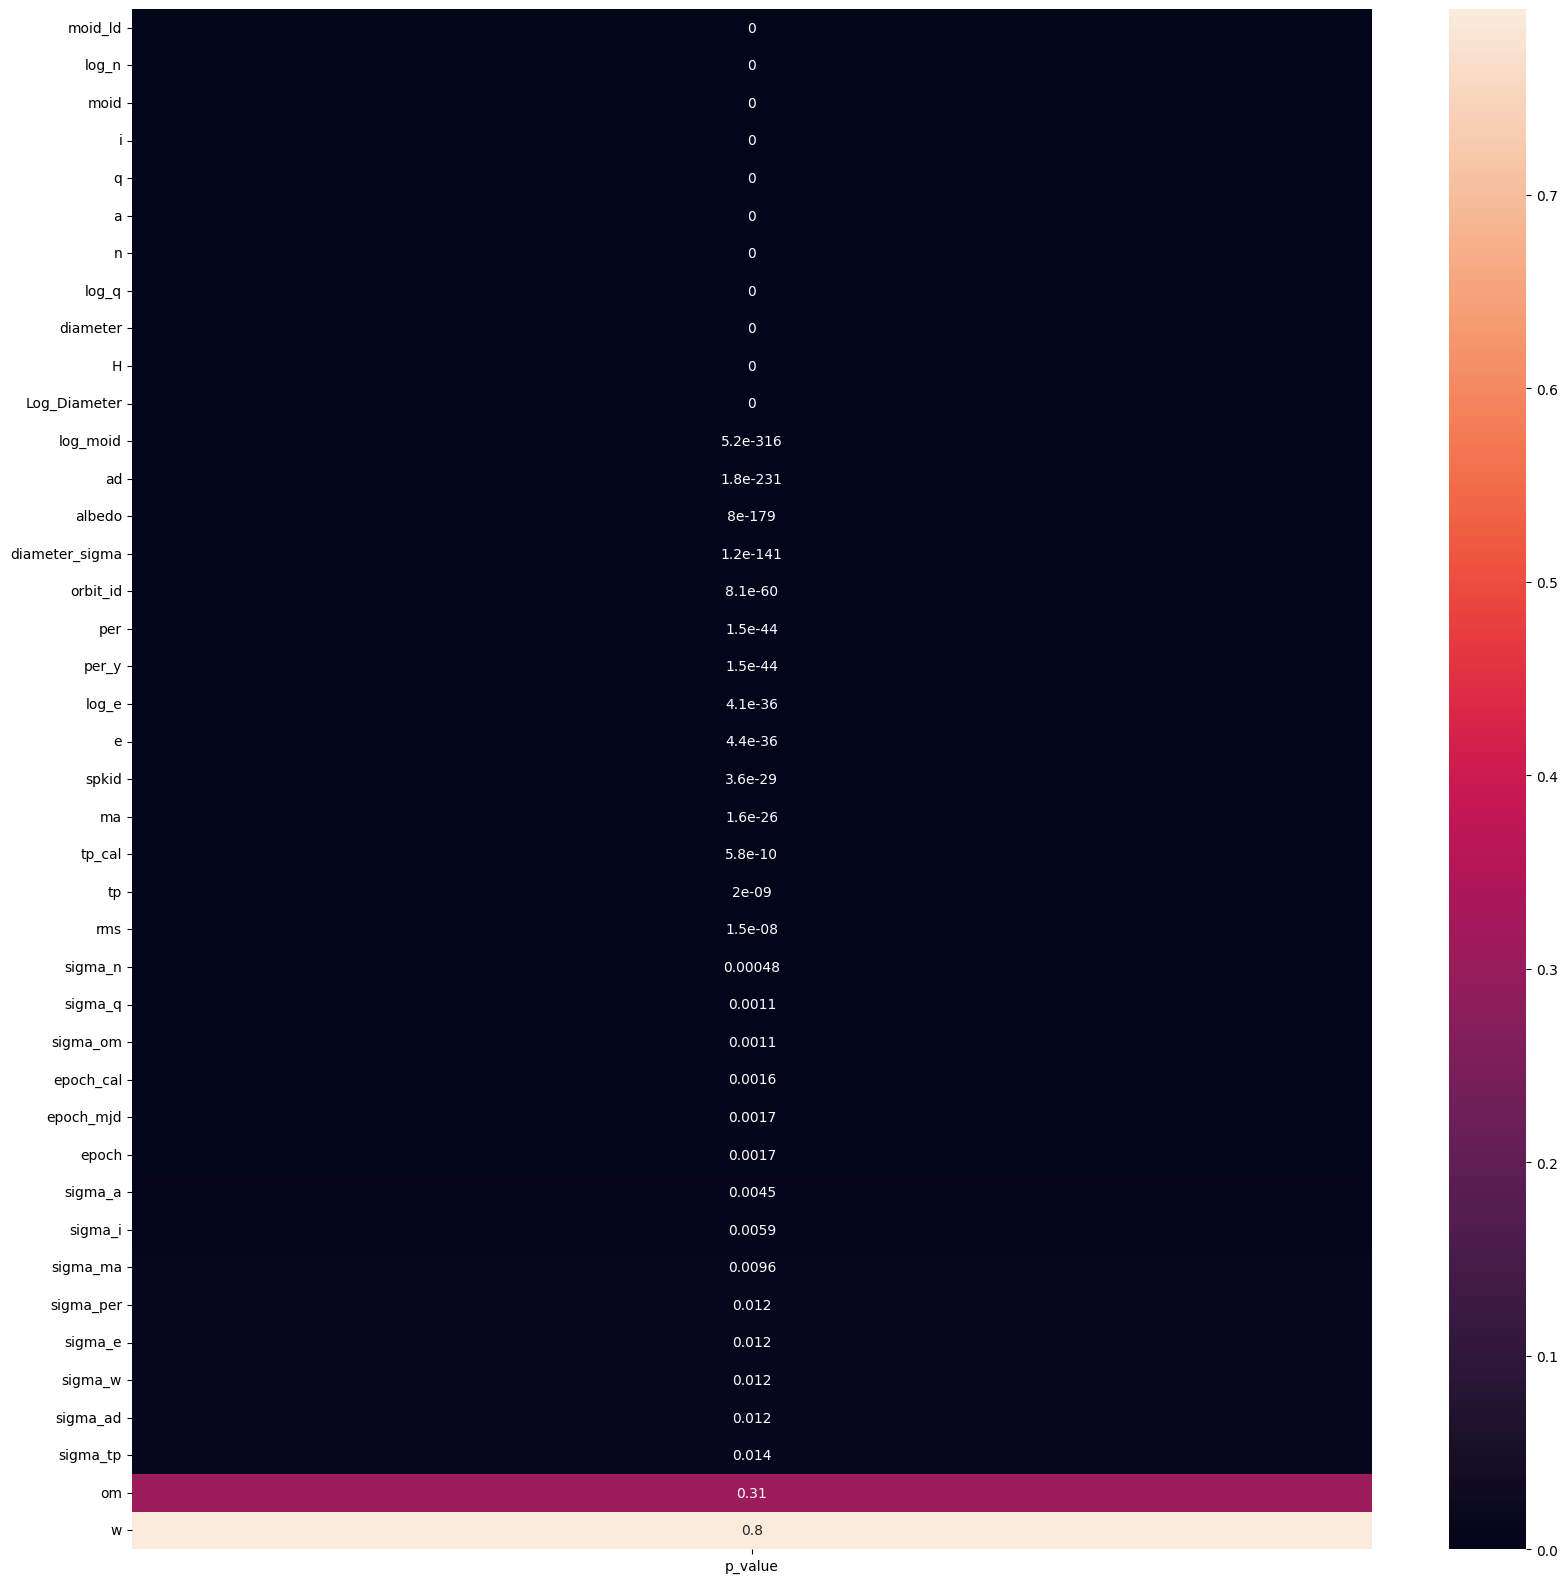

In [44]:
# Print the corresponding p values from ANOVA testing to show statistical Significance:
f_statistic, p_values = f_classif(Train_Dataset.loc[:, ~Train_Dataset.columns.isin(Classification_Targets)], Train_Dataset["MBA"])
sns.heatmap(pd.DataFrame(p_values.reshape(-1,1), columns = ["p_value"], index = Train_Dataset.loc[:, ~Train_Dataset.columns.isin(Classification_Targets)].columns).sort_values(by = "p_value"), annot = True)

<Axes: >

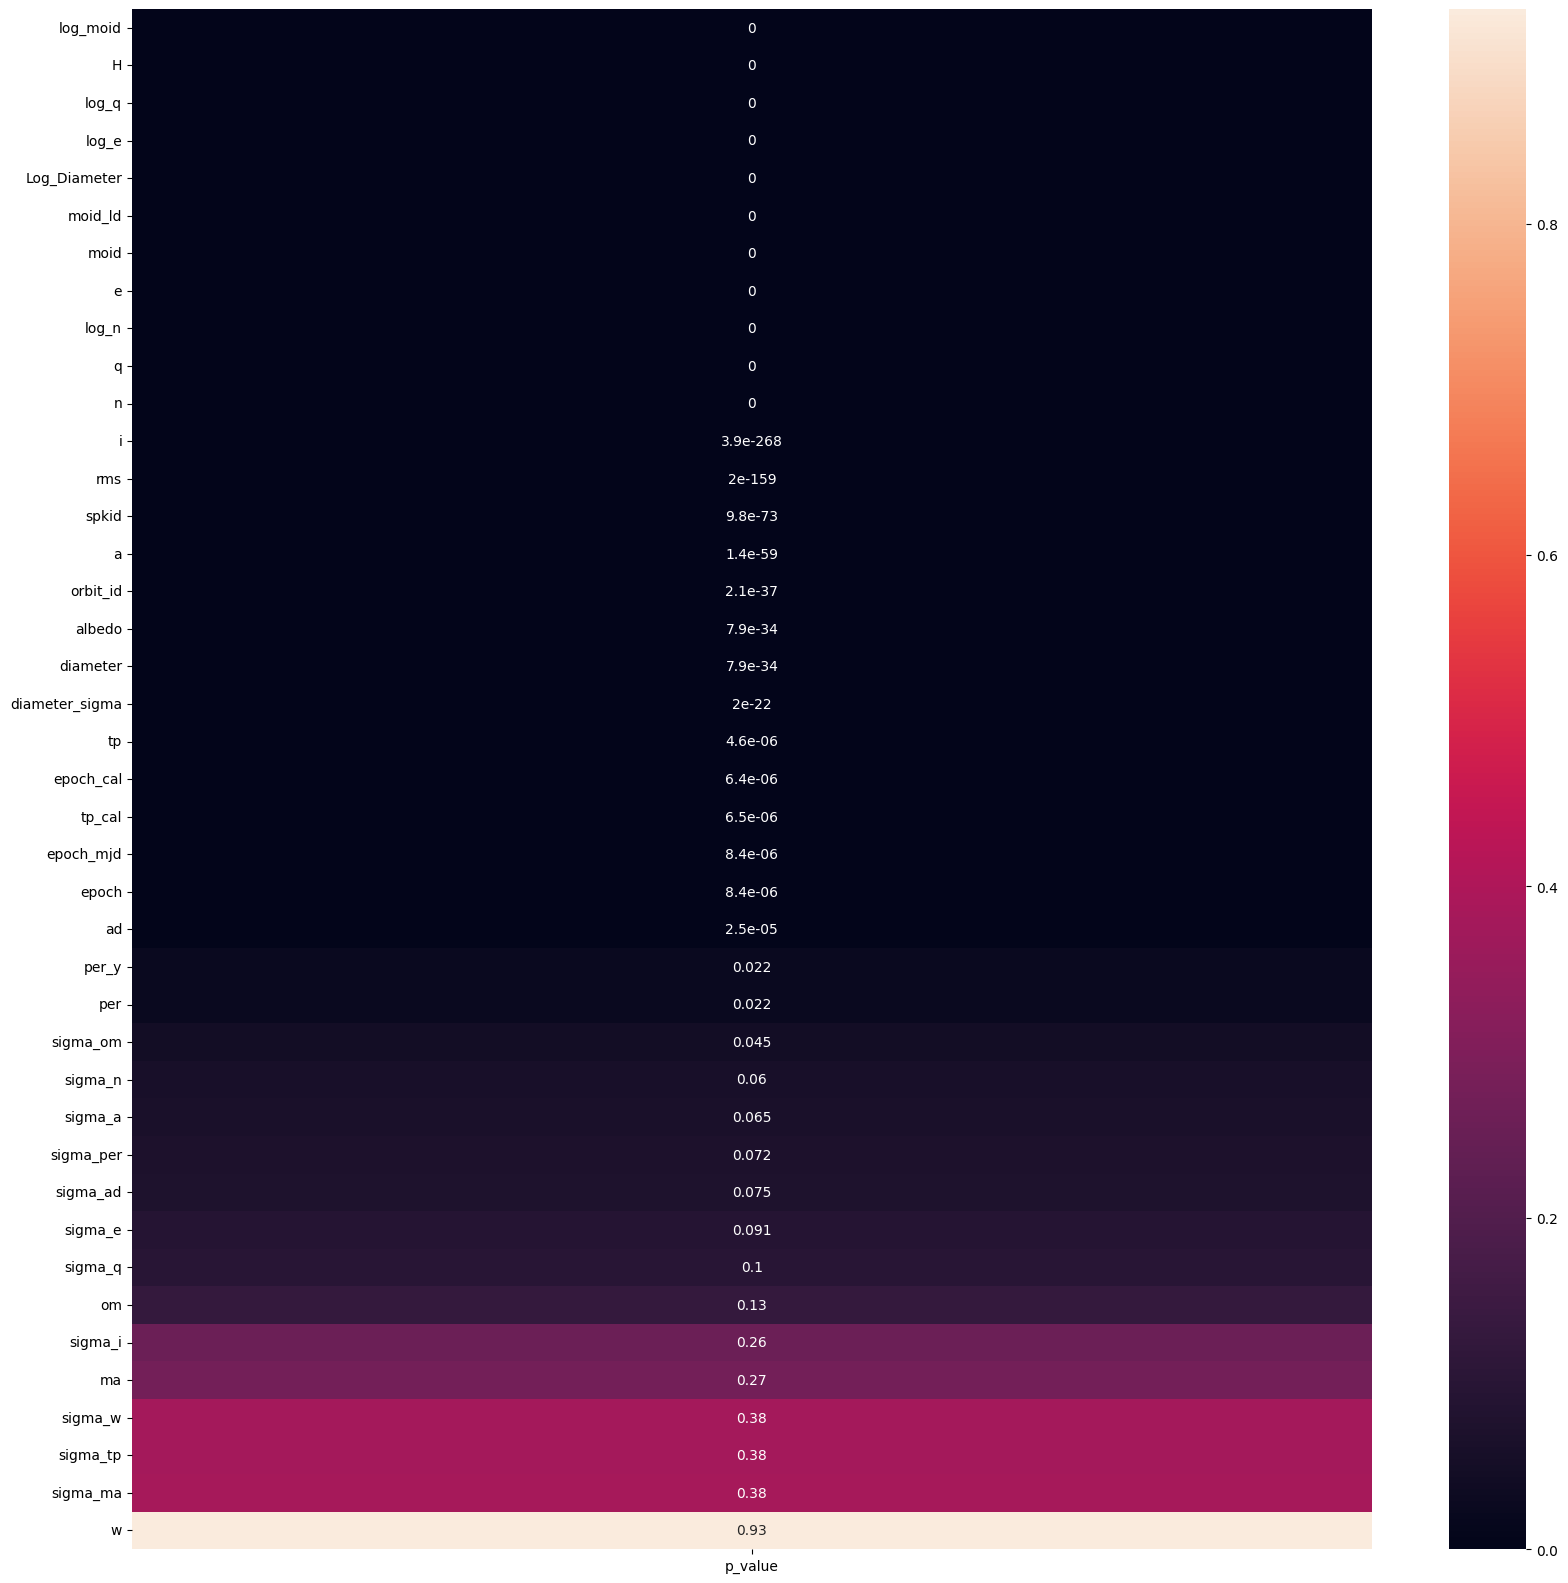

In [45]:
# Print the corresponding p values from ANOVA testing to show statistical Significance:
f_statistic, p_values = f_classif(Train_Dataset.loc[:, ~Train_Dataset.columns.isin(Classification_Targets)], Train_Dataset["neo"])
sns.heatmap(pd.DataFrame(p_values.reshape(-1,1), columns = ["p_value"], index = Train_Dataset.loc[:, ~Train_Dataset.columns.isin(Classification_Targets)].columns).sort_values(by = "p_value"), annot = True)

<Axes: >

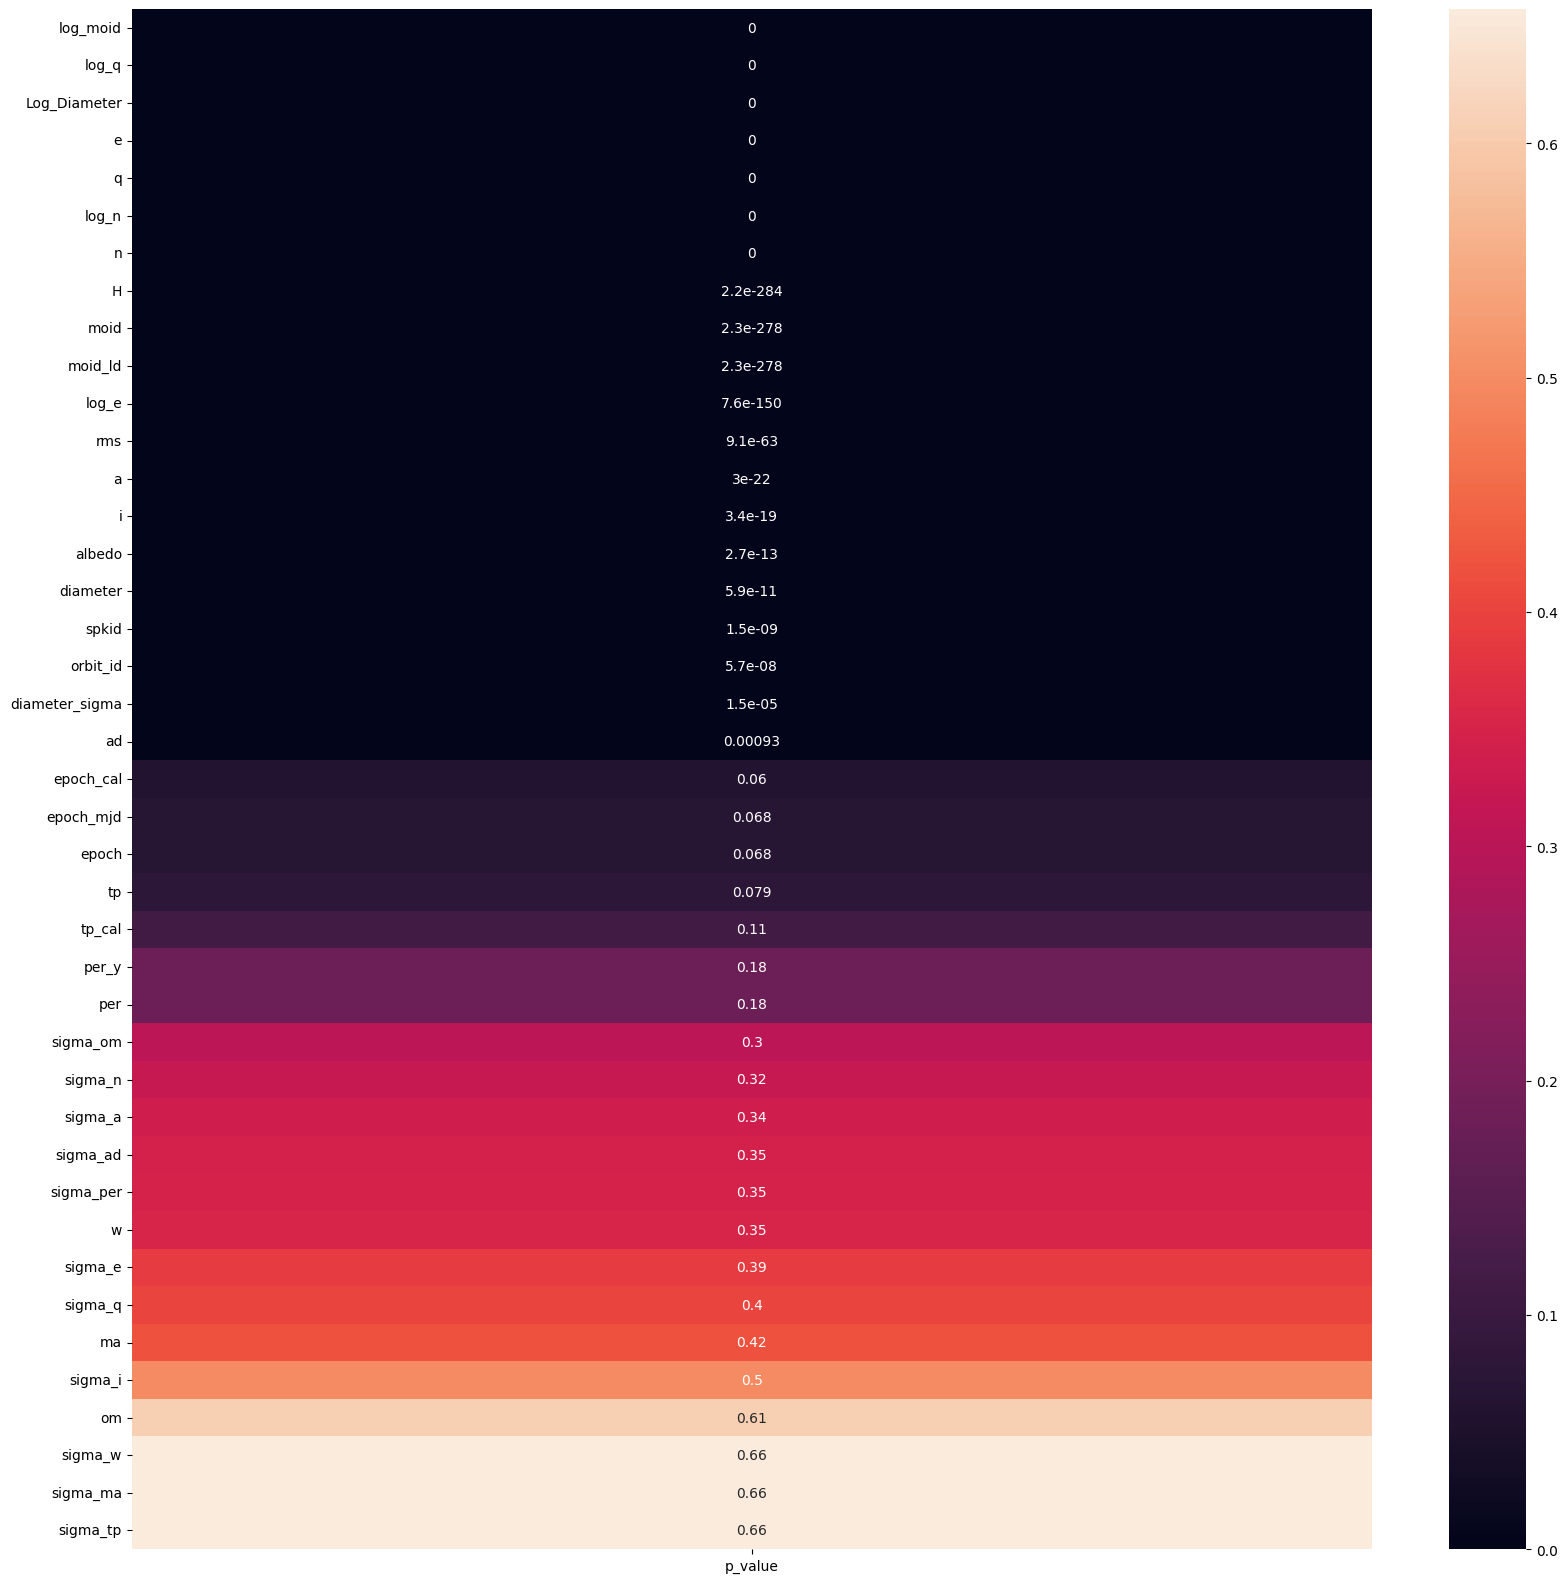

In [46]:
# Print the corresponding p values from ANOVA testing to show statistical Significance:
f_statistic, p_values = f_classif(Train_Dataset.loc[:, ~Train_Dataset.columns.isin(Classification_Targets)], Train_Dataset["pha"])
sns.heatmap(pd.DataFrame(p_values.reshape(-1,1), columns = ["p_value"], index = Train_Dataset.loc[:, ~Train_Dataset.columns.isin(Classification_Targets)].columns).sort_values(by = "p_value"), annot = True)

# Conclusion
In the exploratory data analysis stage of research the goal is find potential patterns within the data that can later form the basis for feature engineering, debugging ML algorithms, data preprocessing and data presentation. Knowing what the main variations in the dataset are can help narrow down which ML algorithms are best suited to the task based on the assumptions they make on the data. 

In this notebook, from expecting the correlation, mutual information scores and ANOVA test scores, we have identifield what are the strongest explanatory variables (ignoring interactions between the features). We also shown that the correlation matrix between features is mostly sparse with only some strong dependences between the uncertainties and a minority of features. 

We have shown using the mutual information scores and correlation scores that their are currently a large portion of features that do not covariate strongly with the targets, opening the doors to either filter selection methods or dimensionality techniques such as PCA. 

For the classification targets, we used histograms to show how the distribution of certain properties of the asteroids shifts for different classes.

For the classification targets, analysis showed the presence of a strong class imbalance, which if unaccounted for will lead to high accuracy scores at the cost of precision. This motivates the use of class weights to balance the importance of each class to ML models used down the pipeline. 